In [9]:
import os
import sys
sys.path.insert(0, './../')
import bbdc2021 as bbdc

In [10]:
pipe_param = {'data_folder': './../data/',
                  'wav_files_folder': 'final_pre_dataset', # fft parameter
                  'window_length': 1024, 'window_overlap': 523,
                  'band_size': 4, 'sample_rate': 16000,
                  'dev_csv': 'dev-labels.csv', # filelisten, falls man doch auf kleinerem probieren moechte
                  'eval_csv': 'challenge_filelist_dummy.csv',
                  'scaling': 'no', # 'standard', 'minmax' oder 'no' wenn kein scaling sein soll
                  'test_split_range': (9000, -1), # index anfang und ende aus dev set 
                  'prediction_path': './', # wo prediction csvs gespeichert werden sollen
                  'post_processing': 'fill', # 'fill' is das von Jannes
                  'submission_file_path': './challenge_submission.csv'}
unet_param = {'channels': [32, 64, 64],
              'lessParameter': True,
              'kernel_size': 3,
              'first_kernel_size': 3,
              'val_split_fraction': 1/9, # 1/9 damit man 1000 von den 9000 abzweigt
              'loss': 'categorical_crossentropy', # bbdc.dice_loss moeglich
              'learning_rate': 0.001,
              'batch_size': 15,
              'epochs': 100,
              'model_save_path': './',
              'load_path': None} # Wenn trainiert werden soll: None; Submission 1: 'model9561.h5'

In [4]:
def pipeline_u_net_1(pipe_param, model_param):
    """Current u_net pipeline from loading data to prediction.
    Takes paramater dictionary as argument"""
    print('Pipeline parameter:', pipe_param)
    print('Model parameter:', model_param)
    # load
    x_dev, y_dev, timep, filelist_dev, x_ch, filelist_ch = bbdc.loading_block1(pipe_param)
    # split (tv=train and val set)
    x_tv, x_test, y_tv, y_test, filelist_test = bbdc.split_block1(x_dev, y_dev, timep, filelist_dev, pipe_param)
    # model fit (or load)
    history, model = bbdc.model_block1_unet(x_tv, y_tv, unet_param)
    # evaluate
    scores_list, model_psds = bbdc.evaluation_block1(x_test, y_test, timep, filelist_test, model, pipe_param)
    # post processing and its evaluation
    pp_pred_test, pp_pred_ch, pp_psds = bbdc.postprocessing_with_evaluation_block1(x_test, y_test, timep,
                                                                                   filelist_test, x_ch,
                                                                                   filelist_ch, model, pipe_param)
    # challenge prediction
    bbdc.challenge_prediction_block1(pp_pred_ch, timep, filelist_ch, pipe_param)
    return scores_list, model_psds, pp_psds

In [5]:
def cross_val(pipeline, pipeparam, modelparam, testindexlist):
    """Cross validates a given pipepline."""
    all_scores_list = []
    all_model_psds = []
    all_pp_psds = []
    for indices in testindexlist:
        pipe_param['test_split_range'] = indices
        print('Test Split:', indices)
        scores_list, model_psds, pp_psds = pipeline(pipeparam, modelparam)
        all_scores_list.append(scores_list)
        all_model_psds.append(model_psds)
        all_pp_psds.append(pp_psds)
        print('\n\n\n')
    fold = len(test_index_list)
    print('Cross validation summary:')
    print('Loss ', [elem[0] for elem in all_scores_list])
    print('Mean Loss', sum([elem[0] for elem in all_scores_list])/fold)
    print('')
    print('MAE', [elem[1] for elem in all_scores_list])
    print('Mean MAE', sum([elem[1] for elem in all_scores_list])/fold)
    print('')
    print('Accuracy', [elem[2] for elem in all_scores_list])
    print('Mean Accuracy', sum([elem[2] for elem in all_scores_list])/fold)
    print('')
    print('Model PSDS', all_model_psds)
    print('Mean model PSDS', sum(all_model_psds)/fold)
    print('')
    print('Post processed PSDS', all_pp_psds)
    print('Mean Post processed PSDS', sum(all_pp_psds)/fold)

# Cross validation for submission1 file

Test Split: (0, 2000)
Csv from wav files already existend. Skipping calc_fft.
Scaled numpy files already existend. Skipping scaling and load_data function.
Splitting test set at indices 0 to 2000 from dev set.
Existing model.h5 removed.
Tensorflow version: 2.4.1
Epoch 1/100
475/475 [==============================] - 40s 66ms/step - loss: 1.5457 - mae: 0.0927 - accuracy: 0.5899 - val_loss: 2.5895 - val_mae: 0.1201 - val_accuracy: 0.2933

Epoch 00001: val_loss improved from inf to 2.58950, saving model to model.h5
Epoch 2/100
475/475 [==============================] - 30s 63ms/step - loss: 0.8088 - mae: 0.0514 - accuracy: 0.7598 - val_loss: 3.8230 - val_mae: 0.1294 - val_accuracy: 0.1775

Epoch 00002: val_loss did not improve from 2.58950
Epoch 3/100
475/475 [==============================] - 30s 63ms/step - loss: 0.6666 - mae: 0.0434 - accuracy: 0.8016 - val_loss: 4.6626 - val_mae: 0.1294 - val_accuracy: 0.1726

Epoch 00003: val_loss did not improve from 2.58950
Epoch 4/100
475/475 [===

475/475 [==============================] - 28s 58ms/step - loss: 0.2364 - mae: 0.0167 - accuracy: 0.9274 - val_loss: 3.9317 - val_mae: 0.1060 - val_accuracy: 0.3205

Epoch 00035: val_loss did not improve from 0.53818
Epoch 36/100
475/475 [==============================] - 28s 58ms/step - loss: 0.2409 - mae: 0.0167 - accuracy: 0.9259 - val_loss: 3.6982 - val_mae: 0.1075 - val_accuracy: 0.3119

Epoch 00036: val_loss did not improve from 0.53818
Epoch 37/100
475/475 [==============================] - 28s 58ms/step - loss: 0.2134 - mae: 0.0152 - accuracy: 0.9343 - val_loss: 2.3057 - val_mae: 0.0880 - val_accuracy: 0.4464

Epoch 00037: val_loss did not improve from 0.53818
Epoch 38/100
475/475 [==============================] - 28s 58ms/step - loss: 0.2168 - mae: 0.0153 - accuracy: 0.9327 - val_loss: 1.9059 - val_mae: 0.0744 - val_accuracy: 0.5472

Epoch 00038: val_loss did not improve from 0.53818
Epoch 39/100
475/475 [==============================] - 28s 58ms/step - loss: 0.2171 - mae: 0


Epoch 00070: val_loss did not improve from 0.37932
Epoch 71/100
475/475 [==============================] - 27s 57ms/step - loss: 0.1945 - mae: 0.0135 - accuracy: 0.9400 - val_loss: 3.3960 - val_mae: 0.0916 - val_accuracy: 0.4113

Epoch 00071: val_loss did not improve from 0.37932
Epoch 72/100
475/475 [==============================] - 27s 58ms/step - loss: 0.1581 - mae: 0.0115 - accuracy: 0.9499 - val_loss: 1.5040 - val_mae: 0.0610 - val_accuracy: 0.6377

Epoch 00072: val_loss did not improve from 0.37932
Epoch 73/100
475/475 [==============================] - 31s 65ms/step - loss: 0.1879 - mae: 0.0133 - accuracy: 0.9411 - val_loss: 7.3148 - val_mae: 0.1253 - val_accuracy: 0.1881

Epoch 00073: val_loss did not improve from 0.37932
Epoch 74/100
475/475 [==============================] - 31s 66ms/step - loss: 0.1922 - mae: 0.0137 - accuracy: 0.9402 - val_loss: 0.4333 - val_mae: 0.0237 - val_accuracy: 0.8806

Epoch 00074: val_loss did not improve from 0.37932
Epoch 75/100
475/475 [======

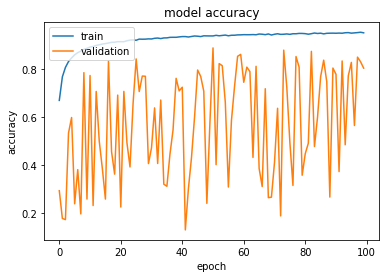

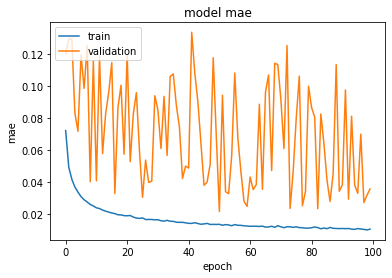

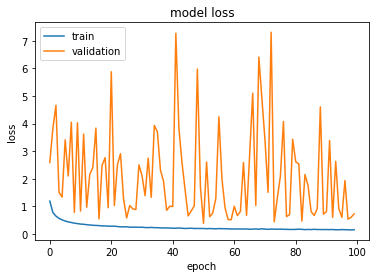

63/63 [==============================] - 2s 24ms/step - loss: 0.7315 - mae: 0.0359 - accuracy: 0.8061

Evaluation:
Loss, MAE, Accuracy [0.7315242886543274, 0.035944677889347076, 0.8061140775680542]
PSDS (0.06383967876584747, 'Valid file')

Filling post processing used.
PSDS (0.45965378737457535, 'Valid file')


/home/alex/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/alex/.local/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Submission file saved at ./challenge_submission.csv




Test Split: (2000, 4000)
Csv from wav files already existend. Skipping calc_fft.
Scaled numpy files already existend. Skipping scaling and load_data function.
Splitting test set at indices 2000 to 4000 from dev set.
Existing model.h5 removed.
Tensorflow version: 2.4.1
Epoch 1/100
475/475 [==============================] - 52s 73ms/step - loss: 1.4489 - mae: 0.0870 - accuracy: 0.5991 - val_loss: 2.3277 - val_mae: 0.1211 - val_accuracy: 0.2703

Epoch 00001: val_loss improved from inf to 2.32775, saving model to model.h5
Epoch 2/100
475/475 [==============================] - 27s 58ms/step - loss: 0.8247 - mae: 0.0522 - accuracy: 0.7538 - val_loss: 1.8235 - val_mae: 0.0955 - val_accuracy: 0.4598

Epoch 00002: val_loss improved from 2.32775 to 1.82355, saving model to model.h5
Epoch 3/100
475/475 [==============================] - 26s 54ms/step - loss: 0.6752 - mae: 0.0441 - accuracy: 0.7949 - val_loss: 1.4894 - val_mae: 0.0871 - val_a

475/475 [==============================] - 29s 61ms/step - loss: 0.1820 - mae: 0.0130 - accuracy: 0.9425 - val_loss: 1.4340 - val_mae: 0.0623 - val_accuracy: 0.6293

Epoch 00069: val_loss did not improve from 0.47433
Epoch 70/100
475/475 [==============================] - 29s 61ms/step - loss: 0.1849 - mae: 0.0134 - accuracy: 0.9419 - val_loss: 1.1194 - val_mae: 0.0516 - val_accuracy: 0.6990

Epoch 00070: val_loss did not improve from 0.47433
Epoch 71/100
475/475 [==============================] - 29s 61ms/step - loss: 0.1809 - mae: 0.0130 - accuracy: 0.9428 - val_loss: 0.4210 - val_mae: 0.0202 - val_accuracy: 0.8883

Epoch 00071: val_loss improved from 0.47433 to 0.42104, saving model to model.h5
Epoch 72/100
475/475 [==============================] - 28s 59ms/step - loss: 0.1665 - mae: 0.0121 - accuracy: 0.9473 - val_loss: 0.5165 - val_mae: 0.0226 - val_accuracy: 0.8757

Epoch 00072: val_loss did not improve from 0.42104
Epoch 73/100
475/475 [==============================] - 28s 58m

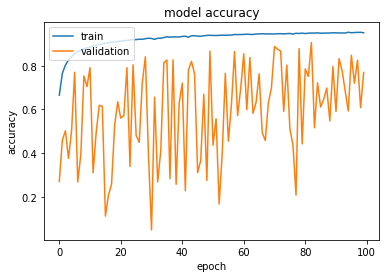

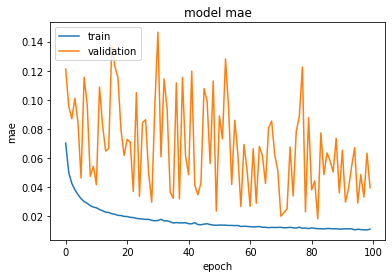

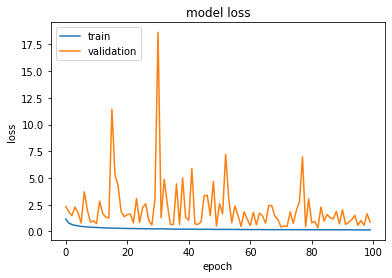

63/63 [==============================] - 2s 26ms/step - loss: 0.9047 - mae: 0.0400 - accuracy: 0.7677

Evaluation:
Loss, MAE, Accuracy [0.9047466516494751, 0.040009915828704834, 0.7677249908447266]
PSDS (0.09935546495913834, 'Valid file')

Filling post processing used.
PSDS (nan, "Each file needs to have at least one label. 1 file(s) missing, e.g. ['03055_mix.wav']")


/home/alex/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/alex/.local/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Submission file saved at ./challenge_submission.csv




Test Split: (4000, 6000)
Csv from wav files already existend. Skipping calc_fft.
Scaled numpy files already existend. Skipping scaling and load_data function.
Splitting test set at indices 4000 to 6000 from dev set.
Existing model.h5 removed.
Tensorflow version: 2.4.1
Epoch 1/100
475/475 [==============================] - 40s 70ms/step - loss: 1.5518 - mae: 0.0928 - accuracy: 0.5778 - val_loss: 3.2894 - val_mae: 0.1351 - val_accuracy: 0.1289

Epoch 00001: val_loss improved from inf to 3.28941, saving model to model.h5
Epoch 2/100
475/475 [==============================] - 30s 63ms/step - loss: 0.8511 - mae: 0.0541 - accuracy: 0.7448 - val_loss: 6.1696 - val_mae: 0.1303 - val_accuracy: 0.1724

Epoch 00002: val_loss did not improve from 3.28941
Epoch 3/100
475/475 [==============================] - 30s 63ms/step - loss: 0.6831 - mae: 0.0446 - accuracy: 0.7944 - val_loss: 5.2981 - val_mae: 0.1339 - val_accuracy: 0.1330

Epoch 00003: 


Epoch 00034: val_loss did not improve from 0.66242
Epoch 35/100
475/475 [==============================] - 30s 64ms/step - loss: 0.2443 - mae: 0.0171 - accuracy: 0.9247 - val_loss: 0.7698 - val_mae: 0.0394 - val_accuracy: 0.7825

Epoch 00035: val_loss did not improve from 0.66242
Epoch 36/100
475/475 [==============================] - 31s 65ms/step - loss: 0.2212 - mae: 0.0156 - accuracy: 0.9317 - val_loss: 0.7300 - val_mae: 0.0344 - val_accuracy: 0.8165

Epoch 00036: val_loss did not improve from 0.66242
Epoch 37/100
475/475 [==============================] - 29s 61ms/step - loss: 0.2273 - mae: 0.0160 - accuracy: 0.9296 - val_loss: 0.6123 - val_mae: 0.0392 - val_accuracy: 0.8118

Epoch 00037: val_loss improved from 0.66242 to 0.61228, saving model to model.h5
Epoch 38/100
475/475 [==============================] - 26s 55ms/step - loss: 0.2165 - mae: 0.0155 - accuracy: 0.9325 - val_loss: 2.3228 - val_mae: 0.0872 - val_accuracy: 0.4466

Epoch 00038: val_loss did not improve from 0.6122

475/475 [==============================] - 28s 59ms/step - loss: 0.1803 - mae: 0.0131 - accuracy: 0.9432 - val_loss: 0.9566 - val_mae: 0.0459 - val_accuracy: 0.7355

Epoch 00070: val_loss did not improve from 0.52407
Epoch 71/100
475/475 [==============================] - 28s 58ms/step - loss: 0.1740 - mae: 0.0125 - accuracy: 0.9456 - val_loss: 0.3035 - val_mae: 0.0168 - val_accuracy: 0.9133

Epoch 00071: val_loss improved from 0.52407 to 0.30349, saving model to model.h5
Epoch 72/100
475/475 [==============================] - 28s 58ms/step - loss: 0.1676 - mae: 0.0121 - accuracy: 0.9472 - val_loss: 7.0811 - val_mae: 0.1269 - val_accuracy: 0.1788

Epoch 00072: val_loss did not improve from 0.30349
Epoch 73/100
475/475 [==============================] - 28s 59ms/step - loss: 0.1762 - mae: 0.0126 - accuracy: 0.9447 - val_loss: 1.4790 - val_mae: 0.0612 - val_accuracy: 0.6308

Epoch 00073: val_loss did not improve from 0.30349
Epoch 74/100
475/475 [==============================] - 28s 58m

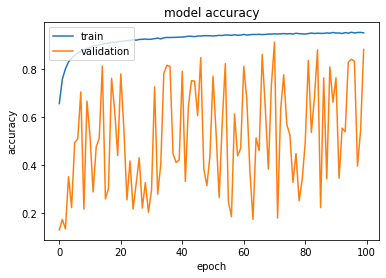

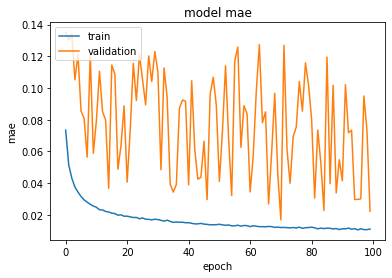

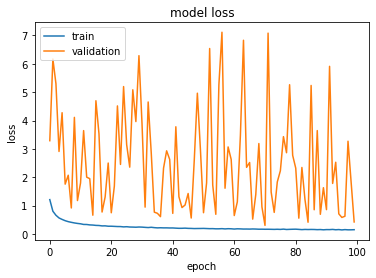

63/63 [==============================] - 2s 24ms/step - loss: 0.4252 - mae: 0.0223 - accuracy: 0.8820

Evaluation:
Loss, MAE, Accuracy [0.42524805665016174, 0.022327791899442673, 0.8820078372955322]
PSDS (0.09746690807811459, 'Valid file')

Filling post processing used.
PSDS (0.7099699615152879, 'Valid file')


/home/alex/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/alex/.local/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Submission file saved at ./challenge_submission.csv




Test Split: (6000, 8000)
Csv from wav files already existend. Skipping calc_fft.
Scaled numpy files already existend. Skipping scaling and load_data function.
Splitting test set at indices 6000 to 8000 from dev set.
Existing model.h5 removed.
Tensorflow version: 2.4.1
Epoch 1/100
475/475 [==============================] - 45s 71ms/step - loss: 1.4816 - mae: 0.0887 - accuracy: 0.5961 - val_loss: 5.0183 - val_mae: 0.1350 - val_accuracy: 0.1390

Epoch 00001: val_loss improved from inf to 5.01828, saving model to model.h5
Epoch 2/100
475/475 [==============================] - 31s 64ms/step - loss: 0.8227 - mae: 0.0518 - accuracy: 0.7560 - val_loss: 2.6425 - val_mae: 0.1130 - val_accuracy: 0.2940

Epoch 00002: val_loss improved from 5.01828 to 2.64249, saving model to model.h5
Epoch 3/100
475/475 [==============================] - 31s 66ms/step - loss: 0.6520 - mae: 0.0427 - accuracy: 0.8033 - val_loss: 1.8796 - val_mae: 0.0899 - val_a


Epoch 00034: val_loss did not improve from 0.59222
Epoch 35/100
475/475 [==============================] - 28s 59ms/step - loss: 0.2388 - mae: 0.0170 - accuracy: 0.9257 - val_loss: 2.0407 - val_mae: 0.0767 - val_accuracy: 0.5325

Epoch 00035: val_loss did not improve from 0.59222
Epoch 36/100
475/475 [==============================] - 28s 59ms/step - loss: 0.2438 - mae: 0.0170 - accuracy: 0.9253 - val_loss: 1.0129 - val_mae: 0.0434 - val_accuracy: 0.7552

Epoch 00036: val_loss did not improve from 0.59222
Epoch 37/100
475/475 [==============================] - 28s 59ms/step - loss: 0.2338 - mae: 0.0166 - accuracy: 0.9275 - val_loss: 0.5263 - val_mae: 0.0258 - val_accuracy: 0.8571

Epoch 00037: val_loss improved from 0.59222 to 0.52627, saving model to model.h5
Epoch 38/100
475/475 [==============================] - 28s 59ms/step - loss: 0.2097 - mae: 0.0151 - accuracy: 0.9345 - val_loss: 3.4440 - val_mae: 0.1107 - val_accuracy: 0.2860

Epoch 00038: val_loss did not improve from 0.5262

475/475 [==============================] - 28s 58ms/step - loss: 0.1766 - mae: 0.0127 - accuracy: 0.9447 - val_loss: 1.4533 - val_mae: 0.0696 - val_accuracy: 0.5854

Epoch 00070: val_loss did not improve from 0.37153
Epoch 71/100
475/475 [==============================] - 28s 58ms/step - loss: 0.1635 - mae: 0.0118 - accuracy: 0.9490 - val_loss: 1.1132 - val_mae: 0.0408 - val_accuracy: 0.7678

Epoch 00071: val_loss did not improve from 0.37153
Epoch 72/100
475/475 [==============================] - 28s 58ms/step - loss: 0.1791 - mae: 0.0129 - accuracy: 0.9435 - val_loss: 0.4580 - val_mae: 0.0231 - val_accuracy: 0.8775

Epoch 00072: val_loss did not improve from 0.37153
Epoch 73/100
475/475 [==============================] - 28s 58ms/step - loss: 0.2134 - mae: 0.0145 - accuracy: 0.9351 - val_loss: 1.4738 - val_mae: 0.0590 - val_accuracy: 0.6536

Epoch 00073: val_loss did not improve from 0.37153
Epoch 74/100
475/475 [==============================] - 28s 59ms/step - loss: 0.1861 - mae: 0

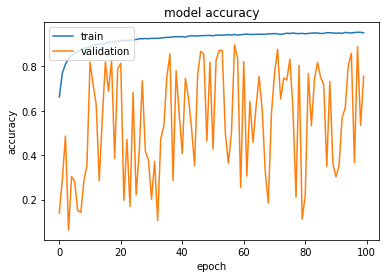

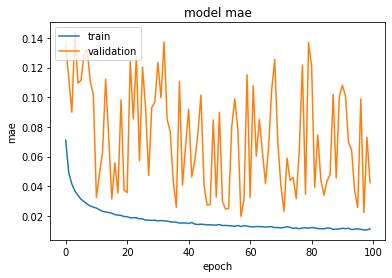

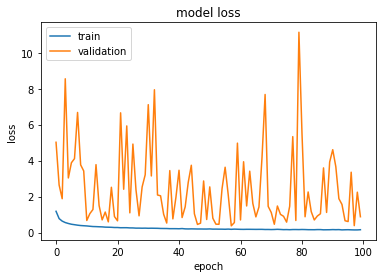

63/63 [==============================] - 2s 24ms/step - loss: 0.9003 - mae: 0.0426 - accuracy: 0.7551

Evaluation:
Loss, MAE, Accuracy [0.9003149271011353, 0.042586326599121094, 0.755078136920929]
PSDS (0.16418473692249985, 'Valid file')

Filling post processing used.
PSDS (0.5071703478616282, 'Valid file')


/home/alex/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/alex/.local/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Submission file saved at ./challenge_submission.csv




Test Split: (8000, -1)
Csv from wav files already existend. Skipping calc_fft.
Scaled numpy files already existend. Skipping scaling and load_data function.
Splitting test set at indices 8000 to -1 from dev set.
Existing model.h5 removed.
Tensorflow version: 2.4.1
Epoch 1/100
593/593 [==============================] - 50s 65ms/step - loss: 1.3992 - mae: 0.0846 - accuracy: 0.6200 - val_loss: 4.1076 - val_mae: 0.1270 - val_accuracy: 0.1855

Epoch 00001: val_loss improved from inf to 4.10759, saving model to model.h5
Epoch 2/100
593/593 [==============================] - 35s 59ms/step - loss: 0.7627 - mae: 0.0490 - accuracy: 0.7735 - val_loss: 4.3161 - val_mae: 0.1279 - val_accuracy: 0.1735

Epoch 00002: val_loss did not improve from 4.10759
Epoch 3/100
593/593 [==============================] - 34s 58ms/step - loss: 0.6030 - mae: 0.0397 - accuracy: 0.8207 - val_loss: 4.1103 - val_mae: 0.1206 - val_accuracy: 0.2225

Epoch 00003: val_


Epoch 00034: val_loss did not improve from 0.45060
Epoch 35/100
593/593 [==============================] - 35s 58ms/step - loss: 0.2023 - mae: 0.0145 - accuracy: 0.9371 - val_loss: 1.9860 - val_mae: 0.0783 - val_accuracy: 0.5183

Epoch 00035: val_loss did not improve from 0.45060
Epoch 36/100
593/593 [==============================] - 35s 59ms/step - loss: 0.1993 - mae: 0.0143 - accuracy: 0.9374 - val_loss: 0.6786 - val_mae: 0.0309 - val_accuracy: 0.8262

Epoch 00036: val_loss did not improve from 0.45060
Epoch 37/100
593/593 [==============================] - 35s 59ms/step - loss: 0.1966 - mae: 0.0140 - accuracy: 0.9391 - val_loss: 5.6141 - val_mae: 0.1188 - val_accuracy: 0.2310

Epoch 00037: val_loss did not improve from 0.45060
Epoch 38/100
593/593 [==============================] - 35s 59ms/step - loss: 0.1908 - mae: 0.0138 - accuracy: 0.9405 - val_loss: 4.1274 - val_mae: 0.0993 - val_accuracy: 0.3642

Epoch 00038: val_loss did not improve from 0.45060
Epoch 39/100
593/593 [======

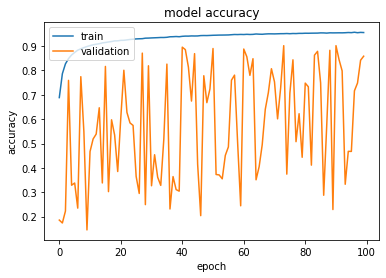

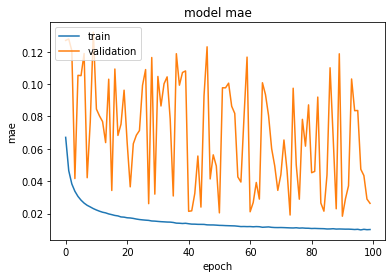

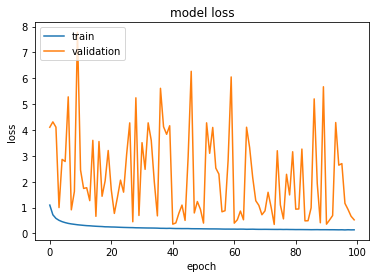

63/63 [==============================] - 2s 25ms/step - loss: 0.4936 - mae: 0.0254 - accuracy: 0.8649

Evaluation:
Loss, MAE, Accuracy [0.4935591220855713, 0.02535342611372471, 0.8648715019226074]
PSDS (0.11984024441944331, 'Valid file')

Filling post processing used.
PSDS (0.6609266539241164, 'Valid file')


/home/alex/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/alex/.local/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Submission file saved at ./challenge_submission.csv




Cross validation summary:
Loss  [0.7315242886543274, 0.9047466516494751, 0.42524805665016174, 0.9003149271011353, 0.4935591220855713]
Mean Loss 0.6910786092281341

MAE [0.035944677889347076, 0.040009915828704834, 0.022327791899442673, 0.042586326599121094, 0.02535342611372471]
Mean MAE 0.033244427666068076

Accuracy [0.8061140775680542, 0.7677249908447266, 0.8820078372955322, 0.755078136920929, 0.8648715019226074]
Mean Accuracy 0.8151593089103699

Model PSDS [0.06383967876584747, 0.09935546495913834, 0.09746690807811459, 0.16418473692249985, 0.11984024441944331]
Mean model PSDS 0.10893740662900872

Post processed PSDS [0.45965378737457535, nan, 0.7099699615152879, 0.5071703478616282, 0.6609266539241164]
Mean Post processed PSDS nan


In [4]:
# cross validation 5 fold
test_index_list = [(0, 2000), (2000, 4000), (4000, 6000), (6000, 8000), (8000,  -1)]
cross_val(pipeline_u_net_1, pipe_param, unet_param, test_index_list)

Test Split: (0, 2000)
Csv from wav files already existend. Skipping calc_fft.
Scaled numpy files already existend. Skipping scaling and load_data function.
Splitting test set at indices 0 to 2000 from dev set.
Existing model.h5 removed.
Tensorflow version: 2.4.1
Epoch 1/100
427/427 [==============================] - 45s 78ms/step - loss: 1.5129 - mae: 0.0894 - accuracy: 0.5873 - val_loss: 1.9439 - val_mae: 0.1098 - val_accuracy: 0.4020

Epoch 00001: val_loss improved from inf to 1.94386, saving model to model.h5
Epoch 2/100
427/427 [==============================] - 27s 63ms/step - loss: 0.8901 - mae: 0.0560 - accuracy: 0.7312 - val_loss: 5.7030 - val_mae: 0.1343 - val_accuracy: 0.1401

Epoch 00002: val_loss did not improve from 1.94386
Epoch 3/100
427/427 [==============================] - 26s 62ms/step - loss: 0.6959 - mae: 0.0454 - accuracy: 0.7903 - val_loss: 4.9807 - val_mae: 0.1332 - val_accuracy: 0.1359

Epoch 00003: val_loss did not improve from 1.94386
Epoch 4/100
427/427 [===


Epoch 00034: val_loss did not improve from 0.62035
Epoch 35/100
427/427 [==============================] - 25s 59ms/step - loss: 0.2207 - mae: 0.0158 - accuracy: 0.9313 - val_loss: 0.6063 - val_mae: 0.0309 - val_accuracy: 0.8342

Epoch 00035: val_loss improved from 0.62035 to 0.60629, saving model to model.h5
Epoch 36/100
427/427 [==============================] - 25s 59ms/step - loss: 0.2179 - mae: 0.0155 - accuracy: 0.9327 - val_loss: 4.8281 - val_mae: 0.1203 - val_accuracy: 0.2207

Epoch 00036: val_loss did not improve from 0.60629
Epoch 37/100
427/427 [==============================] - 25s 60ms/step - loss: 0.2157 - mae: 0.0155 - accuracy: 0.9326 - val_loss: 4.5095 - val_mae: 0.1131 - val_accuracy: 0.2652

Epoch 00037: val_loss did not improve from 0.60629
Epoch 38/100
427/427 [==============================] - 25s 59ms/step - loss: 0.2044 - mae: 0.0148 - accuracy: 0.9360 - val_loss: 1.9484 - val_mae: 0.0703 - val_accuracy: 0.5822

Epoch 00038: val_loss did not improve from 0.6062

427/427 [==============================] - 25s 60ms/step - loss: 0.1714 - mae: 0.0124 - accuracy: 0.9455 - val_loss: 7.3025 - val_mae: 0.1206 - val_accuracy: 0.2198

Epoch 00070: val_loss did not improve from 0.47082
Epoch 71/100
427/427 [==============================] - 25s 59ms/step - loss: 0.1601 - mae: 0.0118 - accuracy: 0.9492 - val_loss: 1.0297 - val_mae: 0.0454 - val_accuracy: 0.7364

Epoch 00071: val_loss did not improve from 0.47082
Epoch 72/100
427/427 [==============================] - 25s 60ms/step - loss: 0.1538 - mae: 0.0114 - accuracy: 0.9515 - val_loss: 1.7677 - val_mae: 0.0634 - val_accuracy: 0.6064

Epoch 00072: val_loss did not improve from 0.47082
Epoch 73/100
427/427 [==============================] - 26s 60ms/step - loss: 0.1568 - mae: 0.0114 - accuracy: 0.9507 - val_loss: 1.6594 - val_mae: 0.0651 - val_accuracy: 0.6064

Epoch 00073: val_loss did not improve from 0.47082
Epoch 74/100
427/427 [==============================] - 26s 60ms/step - loss: 0.1574 - mae: 0

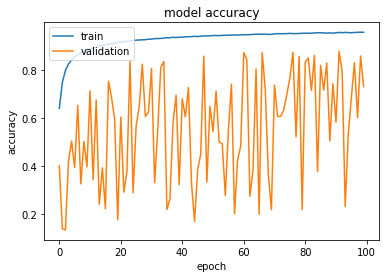

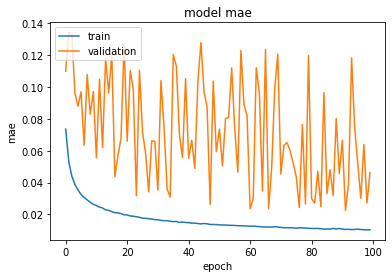

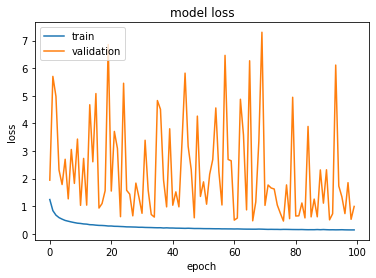

63/63 [==============================] - 2s 24ms/step - loss: 1.0217 - mae: 0.0478 - accuracy: 0.7203

Evaluation:
Loss, MAE, Accuracy [1.0216865539550781, 0.04782867059111595, 0.7202890515327454]
PSDS (0.09594540398599179, 'Valid file')

Filling post processing used.
PSDS (0.5516651675421026, 'Valid file')


/home/alex/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/alex/.local/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Submission file saved at ./challenge_submission.csv




Test Split: (2000, 4000)
Csv from wav files already existend. Skipping calc_fft.
Scaled numpy files already existend. Skipping scaling and load_data function.
Splitting test set at indices 2000 to 4000 from dev set.
Existing model.h5 removed.
Tensorflow version: 2.4.1
Epoch 1/100
427/427 [==============================] - 42s 70ms/step - loss: 1.5176 - mae: 0.0912 - accuracy: 0.5996 - val_loss: 1.6849 - val_mae: 0.0902 - val_accuracy: 0.4903

Epoch 00001: val_loss improved from inf to 1.68489, saving model to model.h5
Epoch 2/100
427/427 [==============================] - 26s 61ms/step - loss: 0.8216 - mae: 0.0518 - accuracy: 0.7596 - val_loss: 2.0407 - val_mae: 0.1028 - val_accuracy: 0.4136

Epoch 00002: val_loss did not improve from 1.68489
Epoch 3/100
427/427 [==============================] - 26s 60ms/step - loss: 0.6785 - mae: 0.0444 - accuracy: 0.7962 - val_loss: 1.4210 - val_mae: 0.0605 - val_accuracy: 0.6391

Epoch 00003: 


Epoch 00034: val_loss did not improve from 0.55019
Epoch 35/100
427/427 [==============================] - 26s 60ms/step - loss: 0.2164 - mae: 0.0155 - accuracy: 0.9328 - val_loss: 1.6862 - val_mae: 0.0691 - val_accuracy: 0.5839

Epoch 00035: val_loss did not improve from 0.55019
Epoch 36/100
427/427 [==============================] - 26s 60ms/step - loss: 0.2135 - mae: 0.0153 - accuracy: 0.9344 - val_loss: 1.2042 - val_mae: 0.0552 - val_accuracy: 0.6781

Epoch 00036: val_loss did not improve from 0.55019
Epoch 37/100
427/427 [==============================] - 26s 60ms/step - loss: 0.2143 - mae: 0.0153 - accuracy: 0.9338 - val_loss: 1.1081 - val_mae: 0.0552 - val_accuracy: 0.6837

Epoch 00037: val_loss did not improve from 0.55019
Epoch 38/100
427/427 [==============================] - 26s 60ms/step - loss: 0.2123 - mae: 0.0152 - accuracy: 0.9336 - val_loss: 4.3823 - val_mae: 0.1113 - val_accuracy: 0.2832

Epoch 00038: val_loss did not improve from 0.55019
Epoch 39/100
427/427 [======

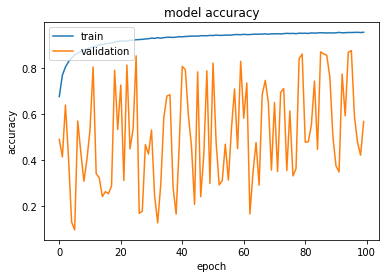

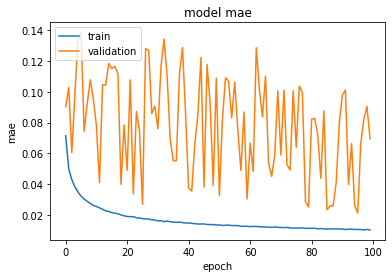

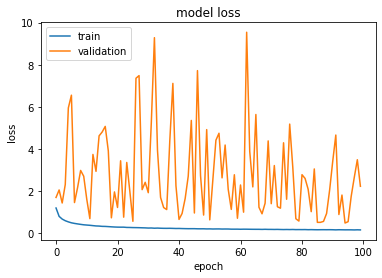

63/63 [==============================] - 2s 24ms/step - loss: 2.1623 - mae: 0.0697 - accuracy: 0.5665

Evaluation:
Loss, MAE, Accuracy [2.162334680557251, 0.0697191134095192, 0.5665203332901001]
PSDS (0.07695642586123076, 'Valid file')

Filling post processing used.
PSDS (0.3539525128217223, 'Valid file')


/home/alex/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/alex/.local/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Submission file saved at ./challenge_submission.csv




Test Split: (4000, 6000)
Csv from wav files already existend. Skipping calc_fft.
Scaled numpy files already existend. Skipping scaling and load_data function.
Splitting test set at indices 4000 to 6000 from dev set.
Existing model.h5 removed.
Tensorflow version: 2.4.1
Epoch 1/100
427/427 [==============================] - 42s 71ms/step - loss: 1.5464 - mae: 0.0927 - accuracy: 0.5956 - val_loss: 2.9701 - val_mae: 0.1294 - val_accuracy: 0.1891

Epoch 00001: val_loss improved from inf to 2.97011, saving model to model.h5
Epoch 2/100
427/427 [==============================] - 26s 61ms/step - loss: 0.8349 - mae: 0.0522 - accuracy: 0.7542 - val_loss: 4.9422 - val_mae: 0.1358 - val_accuracy: 0.1188

Epoch 00002: val_loss did not improve from 2.97011
Epoch 3/100
427/427 [==============================] - 26s 61ms/step - loss: 0.6790 - mae: 0.0440 - accuracy: 0.7974 - val_loss: 1.8943 - val_mae: 0.0913 - val_accuracy: 0.4585

Epoch 00003: 


Epoch 00069: val_loss did not improve from 0.54112
Epoch 70/100
427/427 [==============================] - 26s 61ms/step - loss: 0.1656 - mae: 0.0120 - accuracy: 0.9479 - val_loss: 1.2364 - val_mae: 0.0525 - val_accuracy: 0.6945

Epoch 00070: val_loss did not improve from 0.54112
Epoch 71/100
427/427 [==============================] - 26s 61ms/step - loss: 0.1667 - mae: 0.0120 - accuracy: 0.9480 - val_loss: 4.5749 - val_mae: 0.1053 - val_accuracy: 0.3206

Epoch 00071: val_loss did not improve from 0.54112
Epoch 72/100
427/427 [==============================] - 26s 61ms/step - loss: 0.1586 - mae: 0.0117 - accuracy: 0.9498 - val_loss: 0.7166 - val_mae: 0.0393 - val_accuracy: 0.7826

Epoch 00072: val_loss did not improve from 0.54112
Epoch 73/100
427/427 [==============================] - 25s 59ms/step - loss: 0.1591 - mae: 0.0115 - accuracy: 0.9499 - val_loss: 1.4540 - val_mae: 0.0643 - val_accuracy: 0.6131

Epoch 00073: val_loss did not improve from 0.54112
Epoch 74/100
427/427 [======

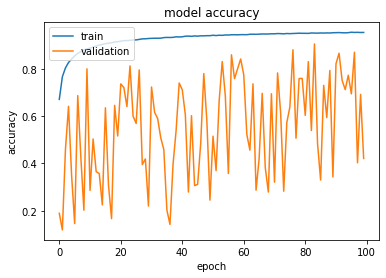

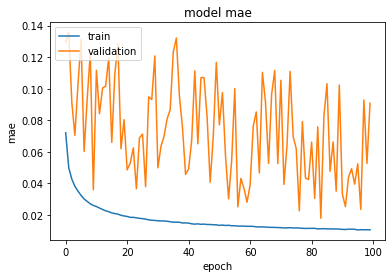

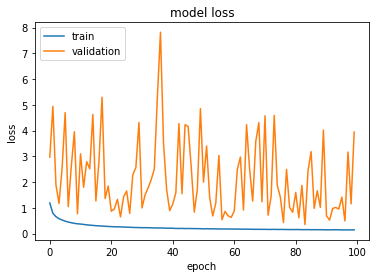

63/63 [==============================] - 2s 24ms/step - loss: 4.0446 - mae: 0.0923 - accuracy: 0.4114

Evaluation:
Loss, MAE, Accuracy [4.0446295738220215, 0.09226659685373306, 0.4114375114440918]
PSDS (0.013610339409260961, 'Valid file')

Filling post processing used.
PSDS (0.28452920366631895, 'Valid file')


/home/alex/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/alex/.local/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Submission file saved at ./challenge_submission.csv




Test Split: (6000, 8000)
Csv from wav files already existend. Skipping calc_fft.
Scaled numpy files already existend. Skipping scaling and load_data function.
Splitting test set at indices 6000 to 8000 from dev set.
Existing model.h5 removed.
Tensorflow version: 2.4.1
Epoch 1/100
427/427 [==============================] - 43s 79ms/step - loss: 1.4846 - mae: 0.0890 - accuracy: 0.5971 - val_loss: 2.8812 - val_mae: 0.1263 - val_accuracy: 0.2232

Epoch 00001: val_loss improved from inf to 2.88118, saving model to model.h5
Epoch 2/100
427/427 [==============================] - 26s 62ms/step - loss: 0.8266 - mae: 0.0525 - accuracy: 0.7522 - val_loss: 2.1335 - val_mae: 0.1084 - val_accuracy: 0.3519

Epoch 00002: val_loss improved from 2.88118 to 2.13347, saving model to model.h5
Epoch 3/100
427/427 [==============================] - 26s 62ms/step - loss: 0.6887 - mae: 0.0451 - accuracy: 0.7909 - val_loss: 2.1324 - val_mae: 0.0968 - val_a


Epoch 00069: val_loss did not improve from 0.52542
Epoch 70/100
427/427 [==============================] - 26s 60ms/step - loss: 0.1591 - mae: 0.0117 - accuracy: 0.9489 - val_loss: 1.6001 - val_mae: 0.0653 - val_accuracy: 0.6023

Epoch 00070: val_loss did not improve from 0.52542
Epoch 71/100
427/427 [==============================] - 25s 60ms/step - loss: 0.1611 - mae: 0.0117 - accuracy: 0.9493 - val_loss: 1.7845 - val_mae: 0.0659 - val_accuracy: 0.5955

Epoch 00071: val_loss did not improve from 0.52542
Epoch 72/100
427/427 [==============================] - 25s 59ms/step - loss: 0.1592 - mae: 0.0117 - accuracy: 0.9495 - val_loss: 1.0081 - val_mae: 0.0444 - val_accuracy: 0.7390

Epoch 00072: val_loss did not improve from 0.52542
Epoch 73/100
427/427 [==============================] - 25s 59ms/step - loss: 0.1559 - mae: 0.0114 - accuracy: 0.9506 - val_loss: 1.1180 - val_mae: 0.0422 - val_accuracy: 0.7530

Epoch 00073: val_loss did not improve from 0.52542
Epoch 74/100
427/427 [======

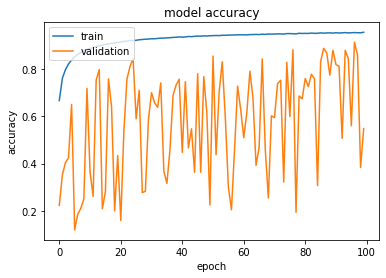

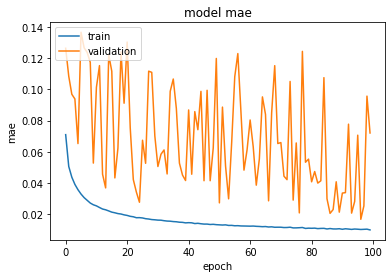

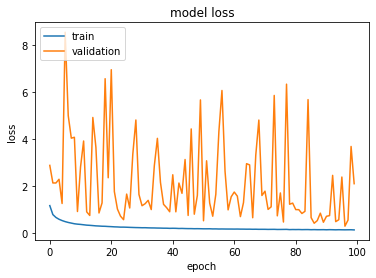

63/63 [==============================] - 2s 25ms/step - loss: 2.1163 - mae: 0.0725 - accuracy: 0.5457

Evaluation:
Loss, MAE, Accuracy [2.1162967681884766, 0.07248115539550781, 0.545703113079071]
PSDS (0.05075232871033103, 'Valid file')

Filling post processing used.
PSDS (0.28061432548945603, 'Valid file')


/home/alex/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/alex/.local/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Submission file saved at ./challenge_submission.csv




Test Split: (8000, -1)
Csv from wav files already existend. Skipping calc_fft.
Scaled numpy files already existend. Skipping scaling and load_data function.
Splitting test set at indices 8000 to -1 from dev set.
Existing model.h5 removed.
Tensorflow version: 2.4.1
Epoch 1/100
534/534 [==============================] - 54s 67ms/step - loss: 1.4210 - mae: 0.0855 - accuracy: 0.6233 - val_loss: 2.1950 - val_mae: 0.1013 - val_accuracy: 0.3592

Epoch 00001: val_loss improved from inf to 2.19499, saving model to model.h5
Epoch 2/100
534/534 [==============================] - 32s 61ms/step - loss: 0.7578 - mae: 0.0485 - accuracy: 0.7753 - val_loss: 2.7538 - val_mae: 0.1082 - val_accuracy: 0.3213

Epoch 00002: val_loss did not improve from 2.19499
Epoch 3/100
534/534 [==============================] - 32s 60ms/step - loss: 0.6177 - mae: 0.0405 - accuracy: 0.8143 - val_loss: 3.7634 - val_mae: 0.1255 - val_accuracy: 0.1844

Epoch 00003: val_


Epoch 00034: val_loss did not improve from 0.50694
Epoch 35/100
534/534 [==============================] - 32s 61ms/step - loss: 0.2046 - mae: 0.0146 - accuracy: 0.9366 - val_loss: 2.3318 - val_mae: 0.0807 - val_accuracy: 0.4902

Epoch 00035: val_loss did not improve from 0.50694
Epoch 36/100
534/534 [==============================] - 32s 60ms/step - loss: 0.2061 - mae: 0.0148 - accuracy: 0.9353 - val_loss: 1.5094 - val_mae: 0.0704 - val_accuracy: 0.5943

Epoch 00036: val_loss did not improve from 0.50694
Epoch 37/100
534/534 [==============================] - 32s 60ms/step - loss: 0.1989 - mae: 0.0143 - accuracy: 0.9380 - val_loss: 0.5357 - val_mae: 0.0298 - val_accuracy: 0.8485

Epoch 00037: val_loss did not improve from 0.50694
Epoch 38/100
534/534 [==============================] - 32s 60ms/step - loss: 0.1943 - mae: 0.0140 - accuracy: 0.9392 - val_loss: 1.9065 - val_mae: 0.0791 - val_accuracy: 0.4958

Epoch 00038: val_loss did not improve from 0.50694
Epoch 39/100
534/534 [======

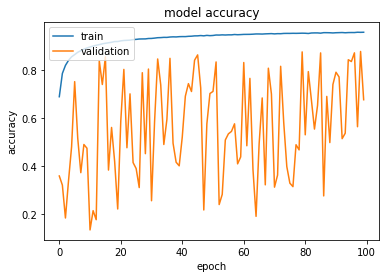

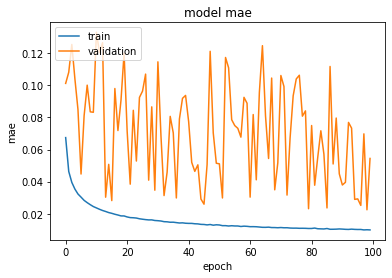

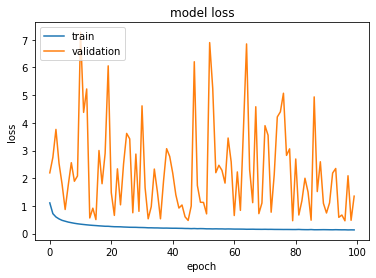

63/63 [==============================] - 1s 23ms/step - loss: 1.3532 - mae: 0.0545 - accuracy: 0.6763

Evaluation:
Loss, MAE, Accuracy [1.3532155752182007, 0.05445510149002075, 0.6763272285461426]
PSDS (0.033891732812479786, 'Valid file')

Filling post processing used.
PSDS (0.31484301806850495, 'Valid file')


/home/alex/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/alex/.local/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Submission file saved at ./challenge_submission.csv




Cross validation summary:
Loss  [1.0216865539550781, 2.162334680557251, 4.0446295738220215, 2.1162967681884766, 1.3532155752182007]
Mean Loss 2.1396326303482054

MAE [0.04782867059111595, 0.0697191134095192, 0.09226659685373306, 0.07248115539550781, 0.05445510149002075]
Mean MAE 0.06735012754797935

Accuracy [0.7202890515327454, 0.5665203332901001, 0.4114375114440918, 0.545703113079071, 0.6763272285461426]
Mean Accuracy 0.5840554475784302

Model PSDS [0.09594540398599179, 0.07695642586123076, 0.013610339409260961, 0.05075232871033103, 0.033891732812479786]
Mean model PSDS 0.05423124615585886

Post processed PSDS [0.5516651675421026, 0.3539525128217223, 0.28452920366631895, 0.28061432548945603, 0.31484301806850495]
Mean Post processed PSDS 0.35712084551762097


In [6]:
# cross validation  5 fold mit val test split 0.2
unet_param['val_split_fraction'] = 0.2
test_index_list = [(0, 2000), (2000, 4000), (4000, 6000), (6000, 8000), (8000,  -1)]
cross_val(pipeline_u_net_1, pipe_param, unet_param, test_index_list)

Test Split: (0, 1000)
Csv from wav files already existend. Skipping calc_fft.
Scaled numpy files already existend. Skipping scaling and load_data function.
Splitting test set at indices 0 to 1000 from dev set.
Existing model.h5 removed.
Tensorflow version: 2.4.1
Epoch 1/100
480/480 [==============================] - 52s 67ms/step - loss: 1.4901 - mae: 0.0901 - accuracy: 0.5872 - val_loss: 1.4216 - val_mae: 0.0955 - val_accuracy: 0.5662

Epoch 00001: val_loss improved from inf to 1.42157, saving model to model.h5
Epoch 2/100
480/480 [==============================] - 28s 58ms/step - loss: 0.7832 - mae: 0.0500 - accuracy: 0.7692 - val_loss: 1.1165 - val_mae: 0.0683 - val_accuracy: 0.6545

Epoch 00002: val_loss improved from 1.42157 to 1.11650, saving model to model.h5
Epoch 3/100
480/480 [==============================] - 28s 58ms/step - loss: 0.6476 - mae: 0.0425 - accuracy: 0.8051 - val_loss: 2.2457 - val_mae: 0.1011 - val_accuracy: 0.3927

Epoch 00003: val_loss did not improve from 1.

480/480 [==============================] - 27s 56ms/step - loss: 0.1996 - mae: 0.0143 - accuracy: 0.9379 - val_loss: 6.3999 - val_mae: 0.1226 - val_accuracy: 0.2038

Epoch 00035: val_loss did not improve from 0.55015
Epoch 36/100
480/480 [==============================] - 27s 56ms/step - loss: 0.2038 - mae: 0.0146 - accuracy: 0.9368 - val_loss: 2.0190 - val_mae: 0.0725 - val_accuracy: 0.5531

Epoch 00036: val_loss did not improve from 0.55015
Epoch 37/100
480/480 [==============================] - 27s 56ms/step - loss: 0.1990 - mae: 0.0142 - accuracy: 0.9386 - val_loss: 1.6652 - val_mae: 0.0684 - val_accuracy: 0.5787

Epoch 00037: val_loss did not improve from 0.55015
Epoch 38/100
480/480 [==============================] - 27s 56ms/step - loss: 0.1966 - mae: 0.0140 - accuracy: 0.9391 - val_loss: 8.1120 - val_mae: 0.1289 - val_accuracy: 0.1620

Epoch 00038: val_loss did not improve from 0.55015
Epoch 39/100
480/480 [==============================] - 27s 56ms/step - loss: 0.1977 - mae: 0


Epoch 00070: val_loss did not improve from 0.46651
Epoch 71/100
480/480 [==============================] - 27s 56ms/step - loss: 0.1485 - mae: 0.0109 - accuracy: 0.9532 - val_loss: 4.0012 - val_mae: 0.1030 - val_accuracy: 0.3389

Epoch 00071: val_loss did not improve from 0.46651
Epoch 72/100
480/480 [==============================] - 27s 56ms/step - loss: 0.1542 - mae: 0.0112 - accuracy: 0.9512 - val_loss: 0.7928 - val_mae: 0.0379 - val_accuracy: 0.7909

Epoch 00072: val_loss did not improve from 0.46651
Epoch 73/100
480/480 [==============================] - 27s 57ms/step - loss: 0.1451 - mae: 0.0107 - accuracy: 0.9539 - val_loss: 0.4273 - val_mae: 0.0216 - val_accuracy: 0.8840

Epoch 00073: val_loss improved from 0.46651 to 0.42731, saving model to model.h5
Epoch 74/100
480/480 [==============================] - 27s 56ms/step - loss: 0.1467 - mae: 0.0108 - accuracy: 0.9534 - val_loss: 3.5457 - val_mae: 0.0992 - val_accuracy: 0.3580

Epoch 00074: val_loss did not improve from 0.4273

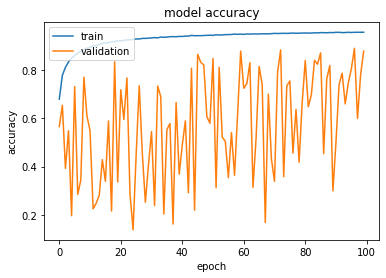

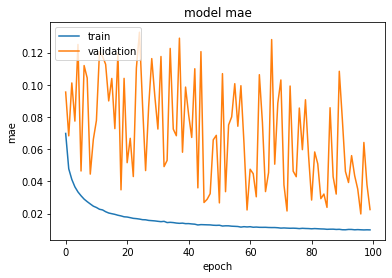

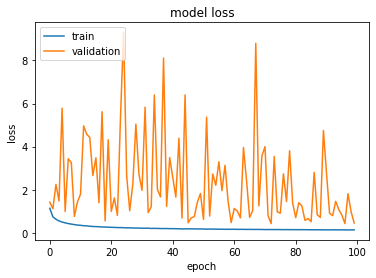

32/32 [==============================] - 1s 24ms/step - loss: 0.4704 - mae: 0.0229 - accuracy: 0.8767

Evaluation:
Loss, MAE, Accuracy [0.470390647649765, 0.022938961163163185, 0.8766531348228455]
PSDS (0.1382104293622132, 'Valid file')

Filling post processing used.
PSDS (0.6772301467205938, 'Valid file')


/home/alex/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/alex/.local/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Submission file saved at ./challenge_submission.csv




Test Split: (1000, 2000)
Csv from wav files already existend. Skipping calc_fft.
Scaled numpy files already existend. Skipping scaling and load_data function.
Splitting test set at indices 1000 to 2000 from dev set.
Existing model.h5 removed.
Tensorflow version: 2.4.1
Epoch 1/100
480/480 [==============================] - 48s 72ms/step - loss: 1.4690 - mae: 0.0881 - accuracy: 0.6007 - val_loss: 2.1433 - val_mae: 0.1089 - val_accuracy: 0.3587

Epoch 00001: val_loss improved from inf to 2.14335, saving model to model.h5
Epoch 2/100
480/480 [==============================] - 29s 60ms/step - loss: 0.8142 - mae: 0.0517 - accuracy: 0.7581 - val_loss: 3.6952 - val_mae: 0.1279 - val_accuracy: 0.1979

Epoch 00002: val_loss did not improve from 2.14335
Epoch 3/100
480/480 [==============================] - 28s 59ms/step - loss: 0.6721 - mae: 0.0437 - accuracy: 0.7984 - val_loss: 7.1028 - val_mae: 0.1424 - val_accuracy: 0.0746

Epoch 00003: 

480/480 [==============================] - 26s 55ms/step - loss: 0.2050 - mae: 0.0146 - accuracy: 0.9365 - val_loss: 3.5342 - val_mae: 0.1034 - val_accuracy: 0.3370

Epoch 00035: val_loss did not improve from 1.15256
Epoch 36/100
480/480 [==============================] - 35s 73ms/step - loss: 0.2063 - mae: 0.0146 - accuracy: 0.9363 - val_loss: 1.2445 - val_mae: 0.0587 - val_accuracy: 0.6695

Epoch 00036: val_loss did not improve from 1.15256
Epoch 37/100
480/480 [==============================] - 27s 56ms/step - loss: 0.2026 - mae: 0.0145 - accuracy: 0.9371 - val_loss: 0.6530 - val_mae: 0.0294 - val_accuracy: 0.8344

Epoch 00037: val_loss improved from 1.15256 to 0.65296, saving model to model.h5
Epoch 38/100
480/480 [==============================] - 27s 56ms/step - loss: 0.1974 - mae: 0.0141 - accuracy: 0.9390 - val_loss: 1.9650 - val_mae: 0.0811 - val_accuracy: 0.4986

Epoch 00038: val_loss did not improve from 0.65296
Epoch 39/100
480/480 [==============================] - 29s 61m

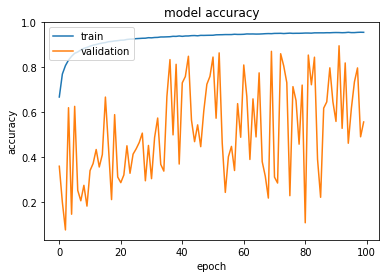

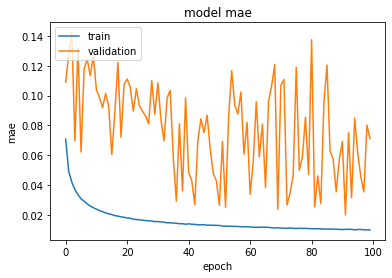

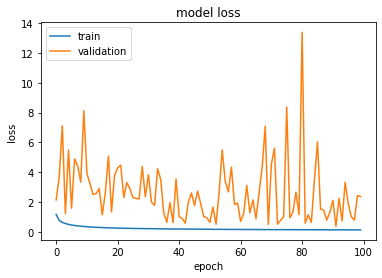

32/32 [==============================] - 1s 22ms/step - loss: 2.4636 - mae: 0.0728 - accuracy: 0.5440

Evaluation:
Loss, MAE, Accuracy [2.4635894298553467, 0.07275959849357605, 0.5439687371253967]
PSDS (0.062206050219440465, 'Valid file')

Filling post processing used.
PSDS (0.3106380035153818, 'Valid file')


/home/alex/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/alex/.local/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Submission file saved at ./challenge_submission.csv




Test Split: (2000, 3000)
Csv from wav files already existend. Skipping calc_fft.
Scaled numpy files already existend. Skipping scaling and load_data function.
Splitting test set at indices 2000 to 3000 from dev set.
Existing model.h5 removed.
Tensorflow version: 2.4.1
Epoch 1/100
480/480 [==============================] - 44s 66ms/step - loss: 1.5388 - mae: 0.0904 - accuracy: 0.5732 - val_loss: 1.2638 - val_mae: 0.0652 - val_accuracy: 0.6441

Epoch 00001: val_loss improved from inf to 1.26382, saving model to model.h5
Epoch 2/100
480/480 [==============================] - 27s 56ms/step - loss: 0.8596 - mae: 0.0541 - accuracy: 0.7445 - val_loss: 4.5394 - val_mae: 0.1289 - val_accuracy: 0.1756

Epoch 00002: val_loss did not improve from 1.26382
Epoch 3/100
480/480 [==============================] - 26s 53ms/step - loss: 0.6810 - mae: 0.0445 - accuracy: 0.7935 - val_loss: 4.9385 - val_mae: 0.1213 - val_accuracy: 0.2305

Epoch 00003: 


Epoch 00034: val_loss did not improve from 0.50341
Epoch 35/100
480/480 [==============================] - 25s 52ms/step - loss: 0.2109 - mae: 0.0152 - accuracy: 0.9341 - val_loss: 1.4449 - val_mae: 0.0671 - val_accuracy: 0.6024

Epoch 00035: val_loss did not improve from 0.50341
Epoch 36/100
480/480 [==============================] - 25s 52ms/step - loss: 0.2086 - mae: 0.0149 - accuracy: 0.9349 - val_loss: 1.4681 - val_mae: 0.0628 - val_accuracy: 0.6311

Epoch 00036: val_loss did not improve from 0.50341
Epoch 37/100
480/480 [==============================] - 25s 52ms/step - loss: 0.2073 - mae: 0.0150 - accuracy: 0.9347 - val_loss: 0.7022 - val_mae: 0.0376 - val_accuracy: 0.7978

Epoch 00037: val_loss did not improve from 0.50341
Epoch 38/100
480/480 [==============================] - 25s 53ms/step - loss: 0.2031 - mae: 0.0146 - accuracy: 0.9367 - val_loss: 0.9233 - val_mae: 0.0498 - val_accuracy: 0.7207

Epoch 00038: val_loss did not improve from 0.50341
Epoch 39/100
480/480 [======

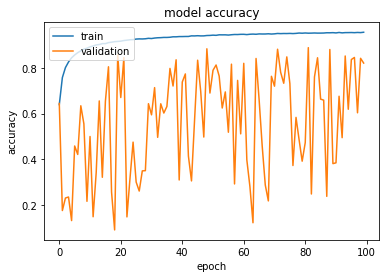

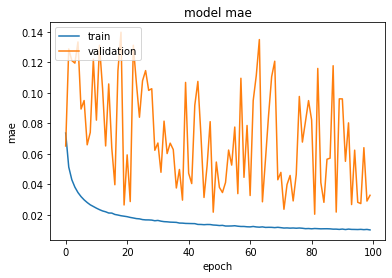

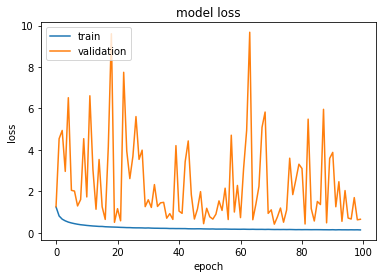

32/32 [==============================] - 1s 22ms/step - loss: 0.6317 - mae: 0.0323 - accuracy: 0.8247

Evaluation:
Loss, MAE, Accuracy [0.6317099332809448, 0.032331548631191254, 0.8246687650680542]
PSDS (0.029155510240533467, 'Valid file')

Filling post processing used.
PSDS (0.5989025601564202, 'Valid file')


/home/alex/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/alex/.local/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Submission file saved at ./challenge_submission.csv




Test Split: (3000, 4000)
Csv from wav files already existend. Skipping calc_fft.
Scaled numpy files already existend. Skipping scaling and load_data function.
Splitting test set at indices 3000 to 4000 from dev set.
Existing model.h5 removed.
Tensorflow version: 2.4.1
Epoch 1/100
480/480 [==============================] - 50s 64ms/step - loss: 1.4915 - mae: 0.0893 - accuracy: 0.5935 - val_loss: 2.2329 - val_mae: 0.1186 - val_accuracy: 0.3263

Epoch 00001: val_loss improved from inf to 2.23287, saving model to model.h5
Epoch 2/100
480/480 [==============================] - 26s 53ms/step - loss: 0.8201 - mae: 0.0521 - accuracy: 0.7595 - val_loss: 2.7166 - val_mae: 0.1112 - val_accuracy: 0.2939

Epoch 00002: val_loss did not improve from 2.23287
Epoch 3/100
480/480 [==============================] - 25s 52ms/step - loss: 0.6472 - mae: 0.0426 - accuracy: 0.8067 - val_loss: 3.6519 - val_mae: 0.1132 - val_accuracy: 0.2824

Epoch 00003: 


Epoch 00069: val_loss did not improve from 0.36363
Epoch 70/100
480/480 [==============================] - 26s 55ms/step - loss: 0.1552 - mae: 0.0113 - accuracy: 0.9511 - val_loss: 4.8958 - val_mae: 0.1039 - val_accuracy: 0.3299

Epoch 00070: val_loss did not improve from 0.36363
Epoch 71/100
480/480 [==============================] - 29s 60ms/step - loss: 0.1584 - mae: 0.0115 - accuracy: 0.9500 - val_loss: 2.0002 - val_mae: 0.0722 - val_accuracy: 0.5446

Epoch 00071: val_loss did not improve from 0.36363
Epoch 72/100
480/480 [==============================] - 30s 62ms/step - loss: 0.1618 - mae: 0.0118 - accuracy: 0.9488 - val_loss: 2.7100 - val_mae: 0.0823 - val_accuracy: 0.4795

Epoch 00072: val_loss did not improve from 0.36363
Epoch 73/100
480/480 [==============================] - 27s 57ms/step - loss: 0.1521 - mae: 0.0111 - accuracy: 0.9517 - val_loss: 0.5163 - val_mae: 0.0255 - val_accuracy: 0.8618

Epoch 00073: val_loss did not improve from 0.36363
Epoch 74/100
480/480 [======

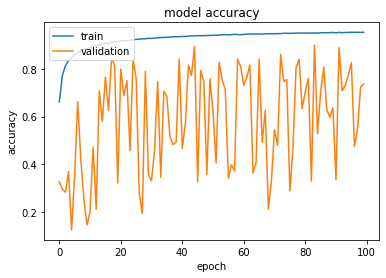

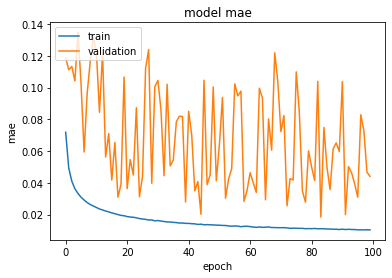

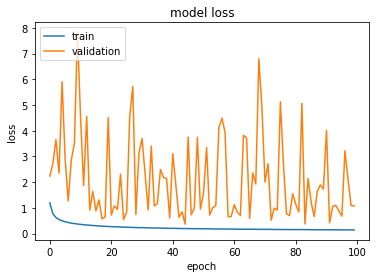

32/32 [==============================] - 1s 25ms/step - loss: 1.0263 - mae: 0.0424 - accuracy: 0.7488

Evaluation:
Loss, MAE, Accuracy [1.0263255834579468, 0.04243346303701401, 0.748828113079071]
PSDS (0.06403869193581947, 'Valid file')

Filling post processing used.
PSDS (nan, "Each file needs to have at least one label. 2 file(s) missing, e.g. ['03389_mix.wav', '03470_mix.wav']")


/home/alex/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/alex/.local/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Submission file saved at ./challenge_submission.csv




Test Split: (4000, 5000)
Csv from wav files already existend. Skipping calc_fft.
Scaled numpy files already existend. Skipping scaling and load_data function.
Splitting test set at indices 4000 to 5000 from dev set.
Existing model.h5 removed.
Tensorflow version: 2.4.1
Epoch 1/100
480/480 [==============================] - 53s 71ms/step - loss: 1.4951 - mae: 0.0899 - accuracy: 0.5905 - val_loss: 1.7105 - val_mae: 0.0960 - val_accuracy: 0.4869

Epoch 00001: val_loss improved from inf to 1.71053, saving model to model.h5
Epoch 2/100
480/480 [==============================] - 29s 61ms/step - loss: 0.8188 - mae: 0.0522 - accuracy: 0.7563 - val_loss: 4.3058 - val_mae: 0.1321 - val_accuracy: 0.1389

Epoch 00002: val_loss did not improve from 1.71053
Epoch 3/100
480/480 [==============================] - 29s 60ms/step - loss: 0.6710 - mae: 0.0436 - accuracy: 0.7996 - val_loss: 3.5823 - val_mae: 0.1164 - val_accuracy: 0.2614

Epoch 00003: 


Epoch 00034: val_loss did not improve from 0.80380
Epoch 35/100
480/480 [==============================] - 29s 61ms/step - loss: 0.2112 - mae: 0.0150 - accuracy: 0.9347 - val_loss: 0.6463 - val_mae: 0.0372 - val_accuracy: 0.8086

Epoch 00035: val_loss improved from 0.80380 to 0.64635, saving model to model.h5
Epoch 36/100
480/480 [==============================] - 29s 61ms/step - loss: 0.2124 - mae: 0.0151 - accuracy: 0.9346 - val_loss: 5.5862 - val_mae: 0.1193 - val_accuracy: 0.2298

Epoch 00036: val_loss did not improve from 0.64635
Epoch 37/100
480/480 [==============================] - 29s 61ms/step - loss: 0.2133 - mae: 0.0152 - accuracy: 0.9338 - val_loss: 1.2275 - val_mae: 0.0514 - val_accuracy: 0.6973

Epoch 00037: val_loss did not improve from 0.64635
Epoch 38/100
480/480 [==============================] - 29s 61ms/step - loss: 0.2060 - mae: 0.0148 - accuracy: 0.9362 - val_loss: 3.2338 - val_mae: 0.0950 - val_accuracy: 0.3973

Epoch 00038: val_loss did not improve from 0.6463

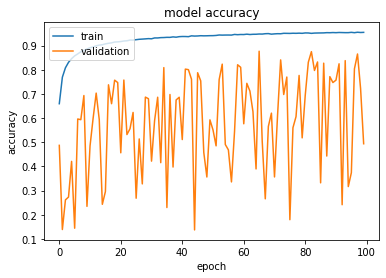

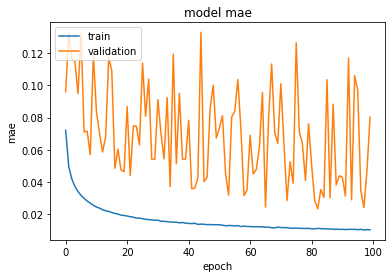

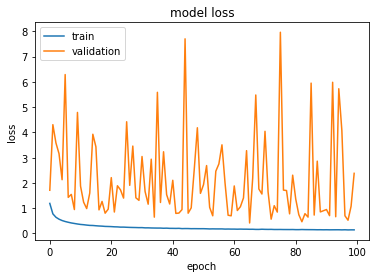

32/32 [==============================] - 1s 26ms/step - loss: 2.4542 - mae: 0.0815 - accuracy: 0.4853

Evaluation:
Loss, MAE, Accuracy [2.454240322113037, 0.08148180693387985, 0.4853406250476837]
PSDS (0.05846081408882844, 'Valid file')

Filling post processing used.
PSDS (0.25722469808843157, 'Valid file')


/home/alex/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/alex/.local/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Submission file saved at ./challenge_submission.csv




Test Split: (5000, 6000)
Csv from wav files already existend. Skipping calc_fft.
Scaled numpy files already existend. Skipping scaling and load_data function.
Splitting test set at indices 5000 to 6000 from dev set.
Existing model.h5 removed.
Tensorflow version: 2.4.1
Epoch 1/100
480/480 [==============================] - 52s 69ms/step - loss: 1.5086 - mae: 0.0905 - accuracy: 0.5960 - val_loss: 1.9517 - val_mae: 0.1027 - val_accuracy: 0.4291

Epoch 00001: val_loss improved from inf to 1.95170, saving model to model.h5
Epoch 2/100
480/480 [==============================] - 29s 61ms/step - loss: 0.7907 - mae: 0.0507 - accuracy: 0.7623 - val_loss: 4.1822 - val_mae: 0.1289 - val_accuracy: 0.1692

Epoch 00002: val_loss did not improve from 1.95170
Epoch 3/100
480/480 [==============================] - 29s 61ms/step - loss: 0.6434 - mae: 0.0423 - accuracy: 0.8056 - val_loss: 6.8396 - val_mae: 0.1335 - val_accuracy: 0.1390

Epoch 00003: 


Epoch 00034: val_loss did not improve from 0.64931
Epoch 35/100
480/480 [==============================] - 27s 56ms/step - loss: 0.2058 - mae: 0.0148 - accuracy: 0.9357 - val_loss: 0.9161 - val_mae: 0.0503 - val_accuracy: 0.7260

Epoch 00035: val_loss did not improve from 0.64931
Epoch 36/100
480/480 [==============================] - 27s 56ms/step - loss: 0.2099 - mae: 0.0150 - accuracy: 0.9349 - val_loss: 0.8082 - val_mae: 0.0380 - val_accuracy: 0.7817

Epoch 00036: val_loss did not improve from 0.64931
Epoch 37/100
480/480 [==============================] - 27s 56ms/step - loss: 0.2115 - mae: 0.0150 - accuracy: 0.9346 - val_loss: 1.3752 - val_mae: 0.0563 - val_accuracy: 0.6662

Epoch 00037: val_loss did not improve from 0.64931
Epoch 38/100
480/480 [==============================] - 28s 58ms/step - loss: 0.2046 - mae: 0.0147 - accuracy: 0.9358 - val_loss: 1.0034 - val_mae: 0.0543 - val_accuracy: 0.6947

Epoch 00038: val_loss did not improve from 0.64931
Epoch 39/100
480/480 [======

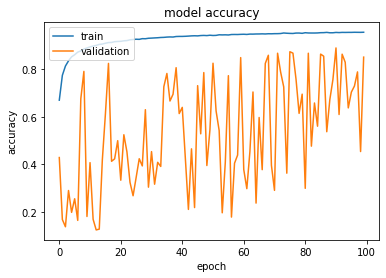

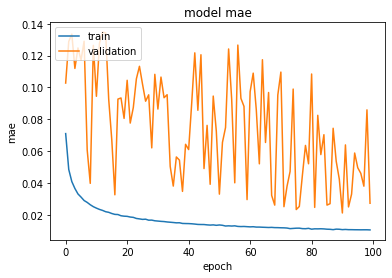

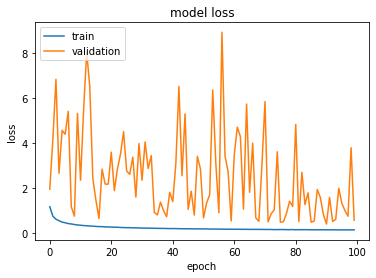

32/32 [==============================] - 1s 23ms/step - loss: 0.5619 - mae: 0.0265 - accuracy: 0.8558

Evaluation:
Loss, MAE, Accuracy [0.5618801712989807, 0.026499750092625618, 0.8558375239372253]
PSDS (0.06832077202093192, 'Valid file')

Filling post processing used.
PSDS (0.6190099976198065, 'Valid file')


/home/alex/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/alex/.local/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Submission file saved at ./challenge_submission.csv




Test Split: (6000, 7000)
Csv from wav files already existend. Skipping calc_fft.
Scaled numpy files already existend. Skipping scaling and load_data function.
Splitting test set at indices 6000 to 7000 from dev set.
Existing model.h5 removed.
Tensorflow version: 2.4.1
Epoch 1/100
480/480 [==============================] - 51s 67ms/step - loss: 1.4277 - mae: 0.0865 - accuracy: 0.6259 - val_loss: 1.6599 - val_mae: 0.1077 - val_accuracy: 0.4655

Epoch 00001: val_loss improved from inf to 1.65990, saving model to model.h5
Epoch 2/100
480/480 [==============================] - 27s 56ms/step - loss: 0.7973 - mae: 0.0509 - accuracy: 0.7634 - val_loss: 2.0234 - val_mae: 0.0994 - val_accuracy: 0.3968

Epoch 00002: val_loss did not improve from 1.65990
Epoch 3/100
480/480 [==============================] - 26s 55ms/step - loss: 0.6403 - mae: 0.0423 - accuracy: 0.8052 - val_loss: 2.3715 - val_mae: 0.0980 - val_accuracy: 0.3821

Epoch 00003: 


Epoch 00034: val_loss did not improve from 0.79934
Epoch 35/100
480/480 [==============================] - 28s 59ms/step - loss: 0.2059 - mae: 0.0147 - accuracy: 0.9360 - val_loss: 0.6626 - val_mae: 0.0356 - val_accuracy: 0.8064

Epoch 00035: val_loss improved from 0.79934 to 0.66257, saving model to model.h5
Epoch 36/100
480/480 [==============================] - 29s 61ms/step - loss: 0.2047 - mae: 0.0147 - accuracy: 0.9360 - val_loss: 2.6691 - val_mae: 0.0909 - val_accuracy: 0.4253

Epoch 00036: val_loss did not improve from 0.66257
Epoch 37/100
480/480 [==============================] - 31s 65ms/step - loss: 0.2071 - mae: 0.0147 - accuracy: 0.9357 - val_loss: 1.4123 - val_mae: 0.0578 - val_accuracy: 0.6623

Epoch 00037: val_loss did not improve from 0.66257
Epoch 38/100
480/480 [==============================] - 34s 71ms/step - loss: 0.2008 - mae: 0.0144 - accuracy: 0.9372 - val_loss: 0.4805 - val_mae: 0.0253 - val_accuracy: 0.8670

Epoch 00038: val_loss improved from 0.66257 to 0.

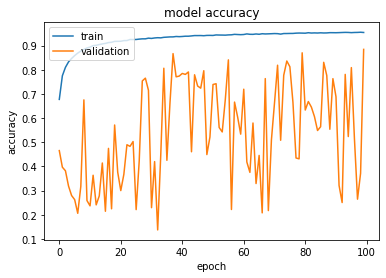

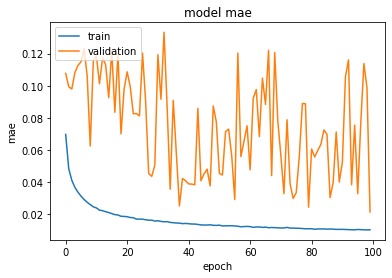

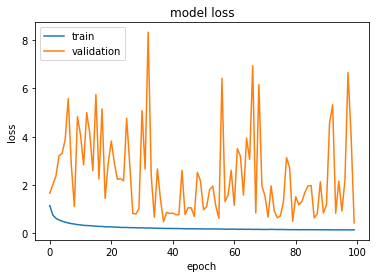

32/32 [==============================] - 1s 25ms/step - loss: 0.4251 - mae: 0.0213 - accuracy: 0.8853

Evaluation:
Loss, MAE, Accuracy [0.4250914752483368, 0.021339701488614082, 0.8853437304496765]
PSDS (0.16436747601617552, 'Valid file')

Filling post processing used.
PSDS (0.7340509283303203, 'Valid file')


/home/alex/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/alex/.local/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Submission file saved at ./challenge_submission.csv




Test Split: (7000, 8000)
Csv from wav files already existend. Skipping calc_fft.
Scaled numpy files already existend. Skipping scaling and load_data function.
Splitting test set at indices 7000 to 8000 from dev set.
Existing model.h5 removed.
Tensorflow version: 2.4.1
Epoch 1/100
480/480 [==============================] - 57s 76ms/step - loss: 1.4364 - mae: 0.0868 - accuracy: 0.6136 - val_loss: 1.3103 - val_mae: 0.0850 - val_accuracy: 0.5944

Epoch 00001: val_loss improved from inf to 1.31031, saving model to model.h5
Epoch 2/100
480/480 [==============================] - 29s 60ms/step - loss: 0.7842 - mae: 0.0498 - accuracy: 0.7678 - val_loss: 5.6406 - val_mae: 0.1329 - val_accuracy: 0.1411

Epoch 00002: val_loss did not improve from 1.31031
Epoch 3/100
480/480 [==============================] - 28s 59ms/step - loss: 0.6408 - mae: 0.0419 - accuracy: 0.8067 - val_loss: 1.5822 - val_mae: 0.0837 - val_accuracy: 0.5115

Epoch 00003: 


Epoch 00034: val_loss did not improve from 0.53640
Epoch 35/100
480/480 [==============================] - 27s 57ms/step - loss: 0.2045 - mae: 0.0146 - accuracy: 0.9370 - val_loss: 1.1762 - val_mae: 0.0568 - val_accuracy: 0.6716

Epoch 00035: val_loss did not improve from 0.53640
Epoch 36/100
480/480 [==============================] - 29s 60ms/step - loss: 0.2093 - mae: 0.0150 - accuracy: 0.9351 - val_loss: 4.1288 - val_mae: 0.0946 - val_accuracy: 0.3936

Epoch 00036: val_loss did not improve from 0.53640
Epoch 37/100
480/480 [==============================] - 28s 58ms/step - loss: 0.2052 - mae: 0.0146 - accuracy: 0.9364 - val_loss: 2.4485 - val_mae: 0.0847 - val_accuracy: 0.4704

Epoch 00037: val_loss did not improve from 0.53640
Epoch 38/100
480/480 [==============================] - 28s 59ms/step - loss: 0.2066 - mae: 0.0149 - accuracy: 0.9353 - val_loss: 1.0283 - val_mae: 0.0455 - val_accuracy: 0.7429

Epoch 00038: val_loss did not improve from 0.53640
Epoch 39/100
480/480 [======

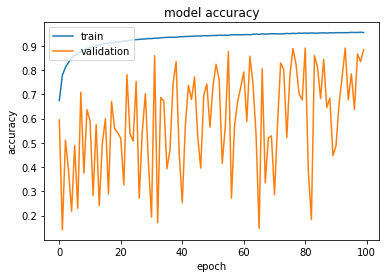

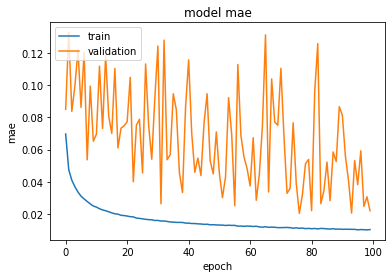

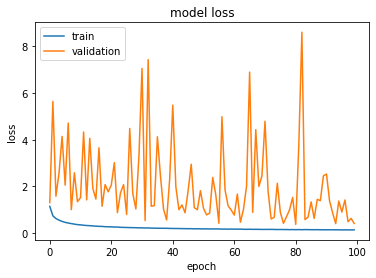

32/32 [==============================] - 1s 25ms/step - loss: 0.4456 - mae: 0.0225 - accuracy: 0.8808

Evaluation:
Loss, MAE, Accuracy [0.4455936849117279, 0.02250111661851406, 0.8807874917984009]
PSDS (0.033016934919108835, 'Valid file')

Filling post processing used.
PSDS (0.7123213337978191, 'Valid file')


/home/alex/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/alex/.local/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Submission file saved at ./challenge_submission.csv




Test Split: (8000, 9000)
Csv from wav files already existend. Skipping calc_fft.
Scaled numpy files already existend. Skipping scaling and load_data function.
Splitting test set at indices 8000 to 9000 from dev set.
Existing model.h5 removed.
Tensorflow version: 2.4.1
Epoch 1/100
480/480 [==============================] - 56s 68ms/step - loss: 1.4792 - mae: 0.0893 - accuracy: 0.5987 - val_loss: 1.3994 - val_mae: 0.0895 - val_accuracy: 0.5674

Epoch 00001: val_loss improved from inf to 1.39939, saving model to model.h5
Epoch 2/100
480/480 [==============================] - 27s 56ms/step - loss: 0.8069 - mae: 0.0512 - accuracy: 0.7629 - val_loss: 2.9780 - val_mae: 0.1180 - val_accuracy: 0.2551

Epoch 00002: val_loss did not improve from 1.39939
Epoch 3/100
480/480 [==============================] - 27s 56ms/step - loss: 0.6500 - mae: 0.0424 - accuracy: 0.8070 - val_loss: 3.2430 - val_mae: 0.1172 - val_accuracy: 0.2464

Epoch 00003: 

480/480 [==============================] - 27s 56ms/step - loss: 0.2094 - mae: 0.0149 - accuracy: 0.9345 - val_loss: 0.6688 - val_mae: 0.0335 - val_accuracy: 0.8258

Epoch 00035: val_loss did not improve from 0.49376
Epoch 36/100
480/480 [==============================] - 27s 56ms/step - loss: 0.2081 - mae: 0.0150 - accuracy: 0.9350 - val_loss: 1.6033 - val_mae: 0.0662 - val_accuracy: 0.6033

Epoch 00036: val_loss did not improve from 0.49376
Epoch 37/100
480/480 [==============================] - 27s 56ms/step - loss: 0.2069 - mae: 0.0147 - accuracy: 0.9360 - val_loss: 2.1732 - val_mae: 0.0818 - val_accuracy: 0.4883

Epoch 00037: val_loss did not improve from 0.49376
Epoch 38/100
480/480 [==============================] - 27s 56ms/step - loss: 0.2095 - mae: 0.0150 - accuracy: 0.9346 - val_loss: 0.9889 - val_mae: 0.0401 - val_accuracy: 0.7673

Epoch 00038: val_loss did not improve from 0.49376
Epoch 39/100
480/480 [==============================] - 27s 56ms/step - loss: 0.2081 - mae: 0


Epoch 00070: val_loss did not improve from 0.33796
Epoch 71/100
480/480 [==============================] - 26s 54ms/step - loss: 0.1594 - mae: 0.0116 - accuracy: 0.9496 - val_loss: 1.6598 - val_mae: 0.0617 - val_accuracy: 0.6176

Epoch 00071: val_loss did not improve from 0.33796
Epoch 72/100
480/480 [==============================] - 28s 58ms/step - loss: 0.1562 - mae: 0.0115 - accuracy: 0.9500 - val_loss: 0.6845 - val_mae: 0.0312 - val_accuracy: 0.8310

Epoch 00072: val_loss did not improve from 0.33796
Epoch 73/100
480/480 [==============================] - 26s 55ms/step - loss: 0.1588 - mae: 0.0115 - accuracy: 0.9502 - val_loss: 3.9961 - val_mae: 0.0982 - val_accuracy: 0.3692

Epoch 00073: val_loss did not improve from 0.33796
Epoch 74/100
480/480 [==============================] - 26s 53ms/step - loss: 0.1553 - mae: 0.0113 - accuracy: 0.9509 - val_loss: 2.7269 - val_mae: 0.0891 - val_accuracy: 0.4248

Epoch 00074: val_loss did not improve from 0.33796
Epoch 75/100
480/480 [======

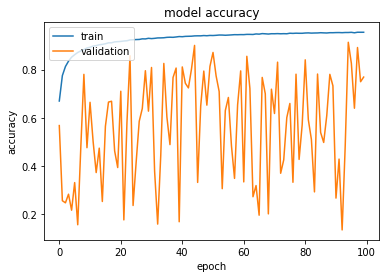

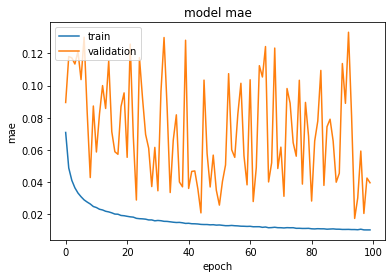

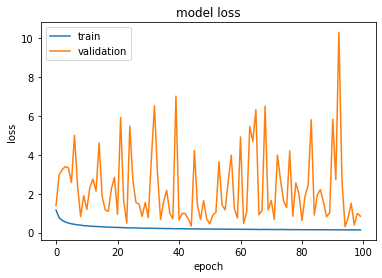

32/32 [==============================] - 3s 41ms/step - loss: 0.8272 - mae: 0.0386 - accuracy: 0.7757

Evaluation:
Loss, MAE, Accuracy [0.8271889686584473, 0.038635581731796265, 0.7757312655448914]
PSDS (0.03703466666666667, 'Valid file')

Filling post processing used.
PSDS (0.6073230266772566, 'Valid file')


/home/alex/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/alex/.local/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Submission file saved at ./challenge_submission.csv




Test Split: (9000, -1)
Csv from wav files already existend. Skipping calc_fft.
Scaled numpy files already existend. Skipping scaling and load_data function.
Splitting test set at indices 9000 to -1 from dev set.
Existing model.h5 removed.
Tensorflow version: 2.4.1
Epoch 1/100
534/534 [==============================] - 59s 85ms/step - loss: 1.5216 - mae: 0.0906 - accuracy: 0.5840 - val_loss: 1.4381 - val_mae: 0.0919 - val_accuracy: 0.5237

Epoch 00001: val_loss improved from inf to 1.43814, saving model to model.h5
Epoch 2/100
534/534 [==============================] - 33s 62ms/step - loss: 0.8018 - mae: 0.0512 - accuracy: 0.7600 - val_loss: 1.0782 - val_mae: 0.0656 - val_accuracy: 0.6986

Epoch 00002: val_loss improved from 1.43814 to 1.07819, saving model to model.h5
Epoch 3/100
534/534 [==============================] - 32s 61ms/step - loss: 0.6435 - mae: 0.0421 - accuracy: 0.8059 - val_loss: 0.8820 - val_mae: 0.0424 - val_accur


Epoch 00034: val_loss did not improve from 0.51294
Epoch 35/100
534/534 [==============================] - 32s 59ms/step - loss: 0.2091 - mae: 0.0149 - accuracy: 0.9353 - val_loss: 2.5337 - val_mae: 0.0890 - val_accuracy: 0.4444

Epoch 00035: val_loss did not improve from 0.51294
Epoch 36/100
534/534 [==============================] - 32s 59ms/step - loss: 0.2172 - mae: 0.0155 - accuracy: 0.9324 - val_loss: 6.0846 - val_mae: 0.1191 - val_accuracy: 0.2272

Epoch 00036: val_loss did not improve from 0.51294
Epoch 37/100
534/534 [==============================] - 32s 59ms/step - loss: 0.2033 - mae: 0.0146 - accuracy: 0.9365 - val_loss: 0.7728 - val_mae: 0.0422 - val_accuracy: 0.7797

Epoch 00037: val_loss did not improve from 0.51294
Epoch 38/100
534/534 [==============================] - 32s 59ms/step - loss: 0.2034 - mae: 0.0146 - accuracy: 0.9367 - val_loss: 1.1797 - val_mae: 0.0500 - val_accuracy: 0.6980

Epoch 00038: val_loss did not improve from 0.51294
Epoch 39/100
534/534 [======

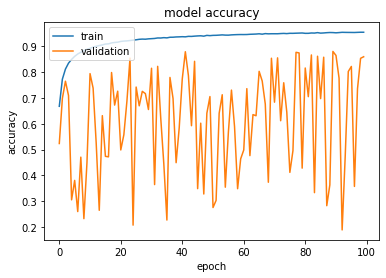

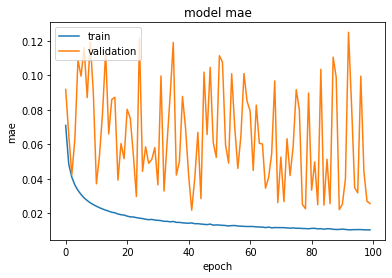

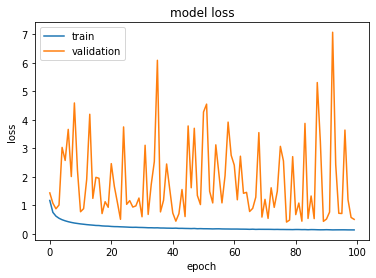

32/32 [==============================] - 1s 24ms/step - loss: 0.5109 - mae: 0.0258 - accuracy: 0.8592 0s - loss: 0.5022 - mae: 0.0251 

Evaluation:
Loss, MAE, Accuracy [0.5109261274337769, 0.025752412155270576, 0.8591716885566711]
PSDS (0.05269816402462206, 'Valid file')

Filling post processing used.
PSDS (0.6678434090732792, 'Valid file')


/home/alex/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/alex/.local/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Submission file saved at ./challenge_submission.csv




Cross validation summary:
Loss  [0.470390647649765, 2.4635894298553467, 0.6317099332809448, 1.0263255834579468, 2.454240322113037, 0.5618801712989807, 0.4250914752483368, 0.4455936849117279, 0.8271889686584473, 0.5109261274337769]
Mean Loss 0.981693634390831

MAE [0.022938961163163185, 0.07275959849357605, 0.032331548631191254, 0.04243346303701401, 0.08148180693387985, 0.026499750092625618, 0.021339701488614082, 0.02250111661851406, 0.038635581731796265, 0.025752412155270576]
Mean MAE 0.0386673940345645

Accuracy [0.8766531348228455, 0.5439687371253967, 0.8246687650680542, 0.748828113079071, 0.4853406250476837, 0.8558375239372253, 0.8853437304496765, 0.8807874917984009, 0.7757312655448914, 0.8591716885566711]
Mean Accuracy 0.7736331075429916

Model PSDS [0.1382104293622132, 0.062206050219440465, 0.029155510240533467, 0.06403869193581947, 0.05846081408882844, 0.06832077202093192, 0.16436747601617552, 0.033016934919108835, 0.0370346

In [9]:
# cross validation 10 fold val split 0.2
unet_param['val_split_fraction'] = 0.2
test_index_list = [(0, 1000), (1000, 2000), (2000, 3000), (3000, 4000), (4000, 5000),
                   (5000, 6000), (6000, 7000), (7000, 8000), (8000, 9000), (9000, -1)]
cross_val(pipeline_u_net_1, pipe_param, unet_param, test_index_list)

Test Split: (0, 1000)
Pipeline parameter: {'data_folder': './../data/', 'wav_files_folder': 'final_pre_dataset', 'window_length': 1024, 'window_overlap': 523, 'band_size': 4, 'sample_rate': 16000, 'dev_csv': 'dev-labels.csv', 'eval_csv': 'challenge_filelist_dummy.csv', 'scaling': 'no', 'test_split_range': (0, 1000), 'prediction_path': './', 'post_processing': 'fill', 'submission_file_path': './challenge_submission.csv'}
Model parameter: {'channels': [32, 64, 64], 'lessParameter': True, 'kernel_size': 3, 'first_kernel_size': 3, 'val_split_fraction': 0.1111111111111111, 'loss': 'categorical_crossentropy', 'learning_rate': 0.001, 'batch_size': 15, 'epochs': 100, 'model_save_path': './', 'load_path': None}
Csv from wav files already existend. Skipping calc_fft.
Scaled numpy files already existend. Skipping scaling and load_data function.
Splitting test set at indices 0 to 1000 from dev set.
Existing model.h5 removed.
Tensorflow version: 2.4.1
Epoch 1/100
534/534 [==========================

534/534 [==============================] - 31s 58ms/step - loss: 0.1555 - mae: 0.0114 - accuracy: 0.9507 - val_loss: 1.7138 - val_mae: 0.0631 - val_accuracy: 0.6072

Epoch 00067: val_loss did not improve from 0.42343
Epoch 68/100
534/534 [==============================] - 31s 58ms/step - loss: 0.1555 - mae: 0.0113 - accuracy: 0.9509 - val_loss: 2.3839 - val_mae: 0.0757 - val_accuracy: 0.5234

Epoch 00068: val_loss did not improve from 0.42343
Epoch 69/100
534/534 [==============================] - 31s 58ms/step - loss: 0.1565 - mae: 0.0114 - accuracy: 0.9503 - val_loss: 0.9995 - val_mae: 0.0467 - val_accuracy: 0.7253

Epoch 00069: val_loss did not improve from 0.42343
Epoch 70/100
534/534 [==============================] - 31s 58ms/step - loss: 0.1564 - mae: 0.0114 - accuracy: 0.9505 - val_loss: 0.9519 - val_mae: 0.0451 - val_accuracy: 0.7422

Epoch 00070: val_loss did not improve from 0.42343
Epoch 71/100
534/534 [==============================] - 31s 58ms/step - loss: 0.1513 - mae: 0

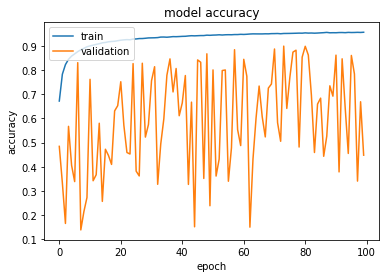

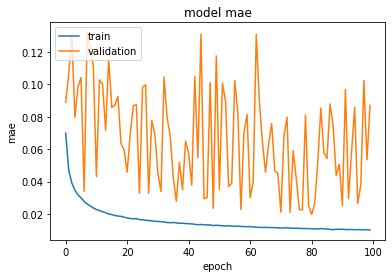

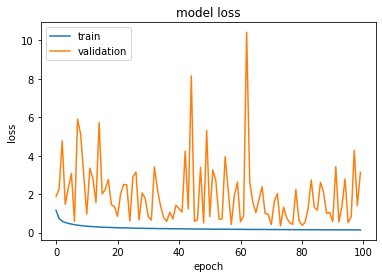

32/32 [==============================] - 1s 23ms/step - loss: 3.0092 - mae: 0.0853 - accuracy: 0.4594

Evaluation:
Loss, MAE, Accuracy [3.009159564971924, 0.08534952253103256, 0.45941561460494995]
PSDS (0.05128172281024561, 'Valid file')

Filling post processing used.
PSDS (0.3345369595349838, 'Valid file')


/home/alex/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/alex/.local/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Submission file saved at ./challenge_submission.csv




Test Split: (1000, 2000)
Pipeline parameter: {'data_folder': './../data/', 'wav_files_folder': 'final_pre_dataset', 'window_length': 1024, 'window_overlap': 523, 'band_size': 4, 'sample_rate': 16000, 'dev_csv': 'dev-labels.csv', 'eval_csv': 'challenge_filelist_dummy.csv', 'scaling': 'no', 'test_split_range': (1000, 2000), 'prediction_path': './', 'post_processing': 'fill', 'submission_file_path': './challenge_submission.csv'}
Model parameter: {'channels': [32, 64, 64], 'lessParameter': True, 'kernel_size': 3, 'first_kernel_size': 3, 'val_split_fraction': 0.1111111111111111, 'loss': 'categorical_crossentropy', 'learning_rate': 0.001, 'batch_size': 15, 'epochs': 100, 'model_save_path': './', 'load_path': None}
Csv from wav files already existend. Skipping calc_fft.
Scaled numpy files already existend. Skipping scaling and load_data function.
Splitting test set at indices 1000 to 2000 from dev set.
Existing model.h5 removed.
Tensorfl


Epoch 00066: val_loss improved from 0.43597 to 0.32930, saving model to model.h5
Epoch 67/100
534/534 [==============================] - 34s 64ms/step - loss: 0.1515 - mae: 0.0111 - accuracy: 0.9519 - val_loss: 2.7545 - val_mae: 0.0849 - val_accuracy: 0.4605

Epoch 00067: val_loss did not improve from 0.32930
Epoch 68/100
534/534 [==============================] - 34s 65ms/step - loss: 0.1570 - mae: 0.0113 - accuracy: 0.9507 - val_loss: 1.2594 - val_mae: 0.0469 - val_accuracy: 0.7216

Epoch 00068: val_loss did not improve from 0.32930
Epoch 69/100
534/534 [==============================] - 33s 61ms/step - loss: 0.1536 - mae: 0.0112 - accuracy: 0.9515 - val_loss: 2.2064 - val_mae: 0.0776 - val_accuracy: 0.5094

Epoch 00069: val_loss did not improve from 0.32930
Epoch 70/100
534/534 [==============================] - 32s 59ms/step - loss: 0.1591 - mae: 0.0115 - accuracy: 0.9497 - val_loss: 1.7002 - val_mae: 0.0644 - val_accuracy: 0.6190

Epoch 00070: val_loss did not improve from 0.3293

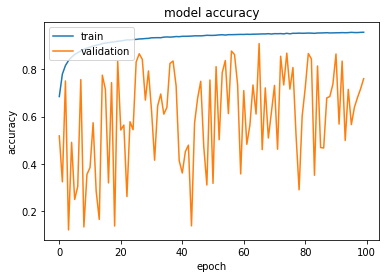

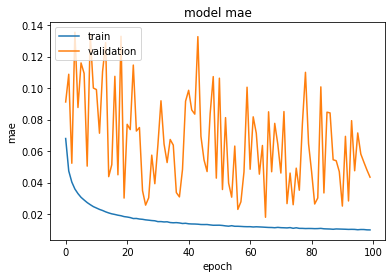

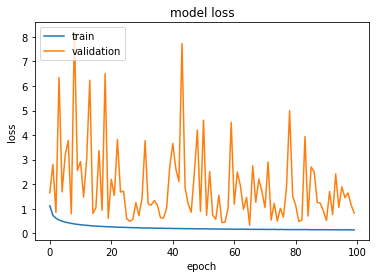

32/32 [==============================] - 1s 28ms/step - loss: 0.8152 - mae: 0.0429 - accuracy: 0.7655

Evaluation:
Loss, MAE, Accuracy [0.8151745200157166, 0.04291342943906784, 0.7655093669891357]
PSDS (0.05106127289354757, 'Valid file')

Filling post processing used.
PSDS (0.4983675714256071, 'Valid file')


/home/alex/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/alex/.local/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Submission file saved at ./challenge_submission.csv




Test Split: (2000, 3000)
Pipeline parameter: {'data_folder': './../data/', 'wav_files_folder': 'final_pre_dataset', 'window_length': 1024, 'window_overlap': 523, 'band_size': 4, 'sample_rate': 16000, 'dev_csv': 'dev-labels.csv', 'eval_csv': 'challenge_filelist_dummy.csv', 'scaling': 'no', 'test_split_range': (2000, 3000), 'prediction_path': './', 'post_processing': 'fill', 'submission_file_path': './challenge_submission.csv'}
Model parameter: {'channels': [32, 64, 64], 'lessParameter': True, 'kernel_size': 3, 'first_kernel_size': 3, 'val_split_fraction': 0.1111111111111111, 'loss': 'categorical_crossentropy', 'learning_rate': 0.001, 'batch_size': 15, 'epochs': 100, 'model_save_path': './', 'load_path': None}
Csv from wav files already existend. Skipping calc_fft.
Scaled numpy files already existend. Skipping scaling and load_data function.
Splitting test set at indices 2000 to 3000 from dev set.
Existing model.h5 removed.
Tensorfl

534/534 [==============================] - 33s 62ms/step - loss: 0.2171 - mae: 0.0155 - accuracy: 0.9326 - val_loss: 1.4694 - val_mae: 0.0562 - val_accuracy: 0.6638

Epoch 00032: val_loss did not improve from 0.40842
Epoch 33/100
534/534 [==============================] - 33s 62ms/step - loss: 0.2107 - mae: 0.0151 - accuracy: 0.9341 - val_loss: 1.4039 - val_mae: 0.0630 - val_accuracy: 0.6166

Epoch 00033: val_loss did not improve from 0.40842
Epoch 34/100
534/534 [==============================] - 33s 62ms/step - loss: 0.2087 - mae: 0.0150 - accuracy: 0.9351 - val_loss: 1.3901 - val_mae: 0.0553 - val_accuracy: 0.6780

Epoch 00034: val_loss did not improve from 0.40842
Epoch 35/100
534/534 [==============================] - 32s 60ms/step - loss: 0.2106 - mae: 0.0150 - accuracy: 0.9343 - val_loss: 2.2854 - val_mae: 0.0827 - val_accuracy: 0.4854

Epoch 00035: val_loss did not improve from 0.40842
Epoch 36/100
534/534 [==============================] - 31s 57ms/step - loss: 0.2047 - mae: 0


Epoch 00067: val_loss did not improve from 0.40842
Epoch 68/100
534/534 [==============================] - 34s 63ms/step - loss: 0.1586 - mae: 0.0116 - accuracy: 0.9497 - val_loss: 2.2944 - val_mae: 0.0688 - val_accuracy: 0.5751

Epoch 00068: val_loss did not improve from 0.40842
Epoch 69/100
534/534 [==============================] - 31s 58ms/step - loss: 0.1514 - mae: 0.0112 - accuracy: 0.9518 - val_loss: 2.6663 - val_mae: 0.0845 - val_accuracy: 0.4680

Epoch 00069: val_loss did not improve from 0.40842
Epoch 70/100
534/534 [==============================] - 31s 58ms/step - loss: 0.1620 - mae: 0.0118 - accuracy: 0.9486 - val_loss: 0.7951 - val_mae: 0.0388 - val_accuracy: 0.7887

Epoch 00070: val_loss did not improve from 0.40842
Epoch 71/100
534/534 [==============================] - 32s 60ms/step - loss: 0.1602 - mae: 0.0116 - accuracy: 0.9495 - val_loss: 0.6157 - val_mae: 0.0321 - val_accuracy: 0.8301

Epoch 00071: val_loss did not improve from 0.40842
Epoch 72/100
534/534 [======

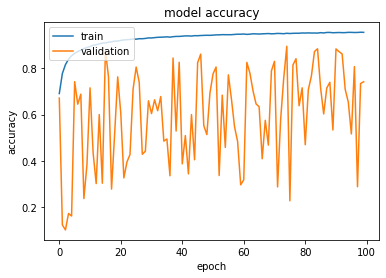

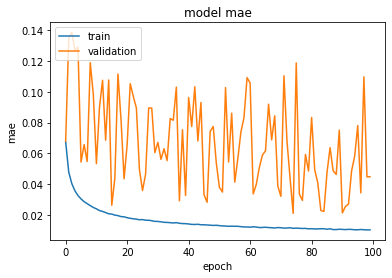

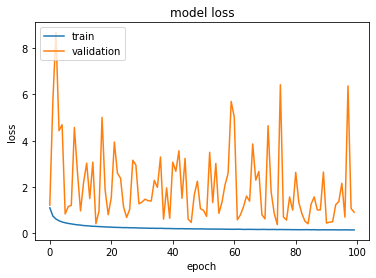

32/32 [==============================] - 1s 27ms/step - loss: 0.9084 - mae: 0.0457 - accuracy: 0.7344

Evaluation:
Loss, MAE, Accuracy [0.9084075093269348, 0.045700233429670334, 0.7344375252723694]
PSDS (0.11239464104302253, 'Valid file')

Filling post processing used.
PSDS (0.5291045526858386, 'Valid file')


/home/alex/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/alex/.local/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Submission file saved at ./challenge_submission.csv




Test Split: (3000, 4000)
Pipeline parameter: {'data_folder': './../data/', 'wav_files_folder': 'final_pre_dataset', 'window_length': 1024, 'window_overlap': 523, 'band_size': 4, 'sample_rate': 16000, 'dev_csv': 'dev-labels.csv', 'eval_csv': 'challenge_filelist_dummy.csv', 'scaling': 'no', 'test_split_range': (3000, 4000), 'prediction_path': './', 'post_processing': 'fill', 'submission_file_path': './challenge_submission.csv'}
Model parameter: {'channels': [32, 64, 64], 'lessParameter': True, 'kernel_size': 3, 'first_kernel_size': 3, 'val_split_fraction': 0.1111111111111111, 'loss': 'categorical_crossentropy', 'learning_rate': 0.001, 'batch_size': 15, 'epochs': 100, 'model_save_path': './', 'load_path': None}
Csv from wav files already existend. Skipping calc_fft.
Scaled numpy files already existend. Skipping scaling and load_data function.
Splitting test set at indices 3000 to 4000 from dev set.
Existing model.h5 removed.
Tensorfl


Epoch 00066: val_loss did not improve from 0.47266
Epoch 67/100
534/534 [==============================] - 33s 63ms/step - loss: 0.1577 - mae: 0.0115 - accuracy: 0.9502 - val_loss: 0.7912 - val_mae: 0.0368 - val_accuracy: 0.7978

Epoch 00067: val_loss did not improve from 0.47266
Epoch 68/100
534/534 [==============================] - 34s 63ms/step - loss: 0.1617 - mae: 0.0117 - accuracy: 0.9494 - val_loss: 2.6524 - val_mae: 0.0798 - val_accuracy: 0.4979

Epoch 00068: val_loss did not improve from 0.47266
Epoch 69/100
534/534 [==============================] - 34s 63ms/step - loss: 0.1602 - mae: 0.0116 - accuracy: 0.9494 - val_loss: 1.1707 - val_mae: 0.0439 - val_accuracy: 0.7406

Epoch 00069: val_loss did not improve from 0.47266
Epoch 70/100
534/534 [==============================] - 34s 63ms/step - loss: 0.1606 - mae: 0.0117 - accuracy: 0.9491 - val_loss: 4.4473 - val_mae: 0.0965 - val_accuracy: 0.3847

Epoch 00070: val_loss did not improve from 0.47266
Epoch 71/100
534/534 [======

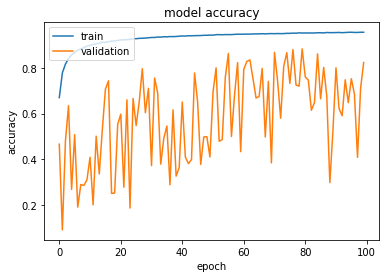

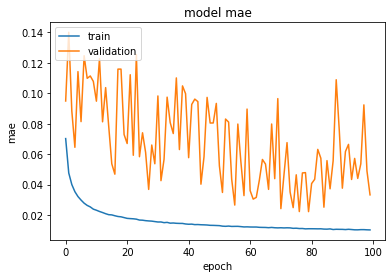

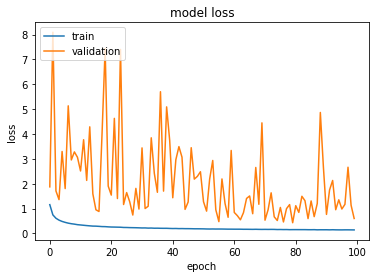

32/32 [==============================] - 1s 28ms/step - loss: 0.6103 - mae: 0.0335 - accuracy: 0.8219

Evaluation:
Loss, MAE, Accuracy [0.6103496551513672, 0.03353607654571533, 0.8219468593597412]
PSDS (0.07955555661577608, 'Valid file')

Filling post processing used.
PSDS (0.5787734202855893, 'Valid file')


/home/alex/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/alex/.local/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Submission file saved at ./challenge_submission.csv




Test Split: (4000, 5000)
Pipeline parameter: {'data_folder': './../data/', 'wav_files_folder': 'final_pre_dataset', 'window_length': 1024, 'window_overlap': 523, 'band_size': 4, 'sample_rate': 16000, 'dev_csv': 'dev-labels.csv', 'eval_csv': 'challenge_filelist_dummy.csv', 'scaling': 'no', 'test_split_range': (4000, 5000), 'prediction_path': './', 'post_processing': 'fill', 'submission_file_path': './challenge_submission.csv'}
Model parameter: {'channels': [32, 64, 64], 'lessParameter': True, 'kernel_size': 3, 'first_kernel_size': 3, 'val_split_fraction': 0.1111111111111111, 'loss': 'categorical_crossentropy', 'learning_rate': 0.001, 'batch_size': 15, 'epochs': 100, 'model_save_path': './', 'load_path': None}
Csv from wav files already existend. Skipping calc_fft.
Scaled numpy files already existend. Skipping scaling and load_data function.
Splitting test set at indices 4000 to 5000 from dev set.
Existing model.h5 removed.
Tensorfl

534/534 [==============================] - 33s 62ms/step - loss: 0.1639 - mae: 0.0119 - accuracy: 0.9481 - val_loss: 0.7349 - val_mae: 0.0390 - val_accuracy: 0.7940

Epoch 00066: val_loss did not improve from 0.37255
Epoch 67/100
534/534 [==============================] - 33s 62ms/step - loss: 0.1580 - mae: 0.0115 - accuracy: 0.9501 - val_loss: 1.2116 - val_mae: 0.0457 - val_accuracy: 0.7329

Epoch 00067: val_loss did not improve from 0.37255
Epoch 68/100
534/534 [==============================] - 33s 63ms/step - loss: 0.1631 - mae: 0.0118 - accuracy: 0.9487 - val_loss: 2.9942 - val_mae: 0.0933 - val_accuracy: 0.4026

Epoch 00068: val_loss did not improve from 0.37255
Epoch 69/100
534/534 [==============================] - 34s 63ms/step - loss: 0.1596 - mae: 0.0116 - accuracy: 0.9498 - val_loss: 0.7991 - val_mae: 0.0361 - val_accuracy: 0.8004

Epoch 00069: val_loss did not improve from 0.37255
Epoch 70/100
534/534 [==============================] - 33s 62ms/step - loss: 0.1606 - mae: 0

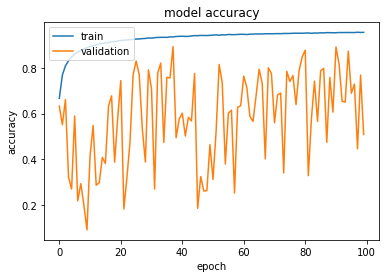

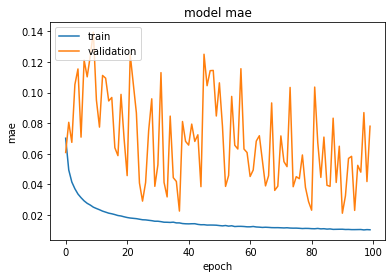

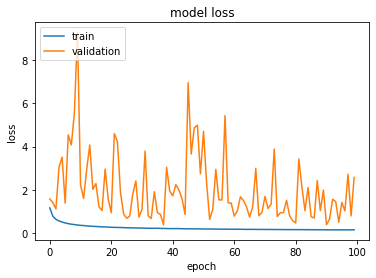

32/32 [==============================] - 1s 26ms/step - loss: 2.5282 - mae: 0.0770 - accuracy: 0.5157

Evaluation:
Loss, MAE, Accuracy [2.528195858001709, 0.07700760662555695, 0.5156968832015991]
PSDS (0.055180366590178435, 'Valid file')

Filling post processing used.
PSDS (0.42218884146416774, 'Valid file')


/home/alex/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/alex/.local/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Submission file saved at ./challenge_submission.csv




Test Split: (5000, 6000)
Pipeline parameter: {'data_folder': './../data/', 'wav_files_folder': 'final_pre_dataset', 'window_length': 1024, 'window_overlap': 523, 'band_size': 4, 'sample_rate': 16000, 'dev_csv': 'dev-labels.csv', 'eval_csv': 'challenge_filelist_dummy.csv', 'scaling': 'no', 'test_split_range': (5000, 6000), 'prediction_path': './', 'post_processing': 'fill', 'submission_file_path': './challenge_submission.csv'}
Model parameter: {'channels': [32, 64, 64], 'lessParameter': True, 'kernel_size': 3, 'first_kernel_size': 3, 'val_split_fraction': 0.1111111111111111, 'loss': 'categorical_crossentropy', 'learning_rate': 0.001, 'batch_size': 15, 'epochs': 100, 'model_save_path': './', 'load_path': None}
Csv from wav files already existend. Skipping calc_fft.
Scaled numpy files already existend. Skipping scaling and load_data function.
Splitting test set at indices 5000 to 6000 from dev set.
Existing model.h5 removed.
Tensorfl


Epoch 00031: val_loss did not improve from 0.54803
Epoch 32/100
534/534 [==============================] - 32s 60ms/step - loss: 0.2221 - mae: 0.0157 - accuracy: 0.9312 - val_loss: 1.7075 - val_mae: 0.0607 - val_accuracy: 0.6350

Epoch 00032: val_loss did not improve from 0.54803
Epoch 33/100
534/534 [==============================] - 32s 60ms/step - loss: 0.2146 - mae: 0.0152 - accuracy: 0.9335 - val_loss: 1.0648 - val_mae: 0.0571 - val_accuracy: 0.6755

Epoch 00033: val_loss did not improve from 0.54803
Epoch 34/100
534/534 [==============================] - 32s 60ms/step - loss: 0.2104 - mae: 0.0150 - accuracy: 0.9353 - val_loss: 0.4553 - val_mae: 0.0286 - val_accuracy: 0.8623

Epoch 00034: val_loss improved from 0.54803 to 0.45533, saving model to model.h5
Epoch 35/100
534/534 [==============================] - 32s 60ms/step - loss: 0.2061 - mae: 0.0147 - accuracy: 0.9361 - val_loss: 5.6983 - val_mae: 0.1196 - val_accuracy: 0.2213

Epoch 00035: val_loss did not improve from 0.4553

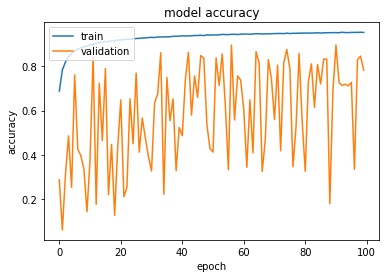

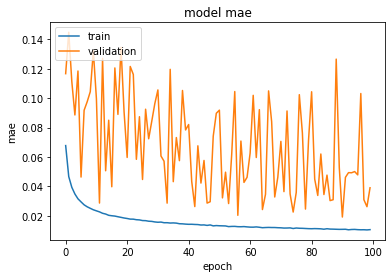

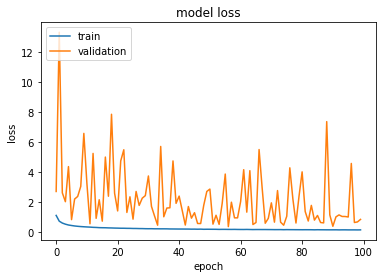

32/32 [==============================] - 1s 25ms/step - loss: 0.9050 - mae: 0.0410 - accuracy: 0.7711

Evaluation:
Loss, MAE, Accuracy [0.9049724340438843, 0.04102083668112755, 0.7711374759674072]
PSDS (0.06597354901950468, 'Valid file')

Filling post processing used.
PSDS (0.4799521823599712, 'Valid file')


/home/alex/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/alex/.local/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Submission file saved at ./challenge_submission.csv




Test Split: (6000, 7000)
Pipeline parameter: {'data_folder': './../data/', 'wav_files_folder': 'final_pre_dataset', 'window_length': 1024, 'window_overlap': 523, 'band_size': 4, 'sample_rate': 16000, 'dev_csv': 'dev-labels.csv', 'eval_csv': 'challenge_filelist_dummy.csv', 'scaling': 'no', 'test_split_range': (6000, 7000), 'prediction_path': './', 'post_processing': 'fill', 'submission_file_path': './challenge_submission.csv'}
Model parameter: {'channels': [32, 64, 64], 'lessParameter': True, 'kernel_size': 3, 'first_kernel_size': 3, 'val_split_fraction': 0.1111111111111111, 'loss': 'categorical_crossentropy', 'learning_rate': 0.001, 'batch_size': 15, 'epochs': 100, 'model_save_path': './', 'load_path': None}
Csv from wav files already existend. Skipping calc_fft.
Scaled numpy files already existend. Skipping scaling and load_data function.
Splitting test set at indices 6000 to 7000 from dev set.
Existing model.h5 removed.
Tensorfl


Epoch 00066: val_loss did not improve from 0.33490
Epoch 67/100
534/534 [==============================] - 31s 58ms/step - loss: 0.1572 - mae: 0.0115 - accuracy: 0.9497 - val_loss: 2.6444 - val_mae: 0.0800 - val_accuracy: 0.4988

Epoch 00067: val_loss did not improve from 0.33490
Epoch 68/100
534/534 [==============================] - 31s 58ms/step - loss: 0.1536 - mae: 0.0113 - accuracy: 0.9513 - val_loss: 2.9905 - val_mae: 0.0881 - val_accuracy: 0.4370

Epoch 00068: val_loss did not improve from 0.33490
Epoch 69/100
534/534 [==============================] - 31s 58ms/step - loss: 0.1591 - mae: 0.0116 - accuracy: 0.9494 - val_loss: 0.9292 - val_mae: 0.0454 - val_accuracy: 0.7407

Epoch 00069: val_loss did not improve from 0.33490
Epoch 70/100
534/534 [==============================] - 31s 58ms/step - loss: 0.1515 - mae: 0.0112 - accuracy: 0.9517 - val_loss: 0.9206 - val_mae: 0.0478 - val_accuracy: 0.7309

Epoch 00070: val_loss did not improve from 0.33490
Epoch 71/100
534/534 [======

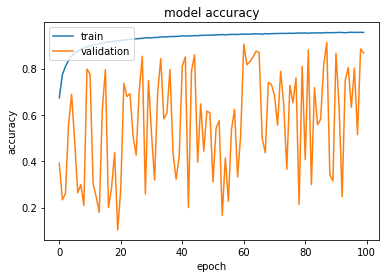

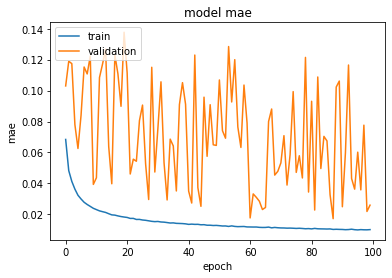

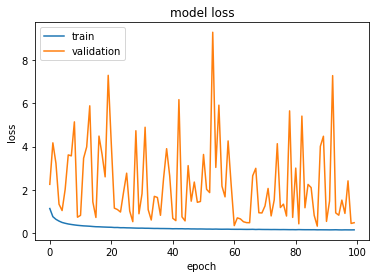

32/32 [==============================] - 1s 24ms/step - loss: 0.4772 - mae: 0.0261 - accuracy: 0.8655

Evaluation:
Loss, MAE, Accuracy [0.47723954916000366, 0.02613430842757225, 0.8654500246047974]
PSDS (0.11502392197142347, 'Valid file')

Filling post processing used.
PSDS (0.6876567642213998, 'Valid file')


/home/alex/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/alex/.local/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Submission file saved at ./challenge_submission.csv




Test Split: (7000, 8000)
Pipeline parameter: {'data_folder': './../data/', 'wav_files_folder': 'final_pre_dataset', 'window_length': 1024, 'window_overlap': 523, 'band_size': 4, 'sample_rate': 16000, 'dev_csv': 'dev-labels.csv', 'eval_csv': 'challenge_filelist_dummy.csv', 'scaling': 'no', 'test_split_range': (7000, 8000), 'prediction_path': './', 'post_processing': 'fill', 'submission_file_path': './challenge_submission.csv'}
Model parameter: {'channels': [32, 64, 64], 'lessParameter': True, 'kernel_size': 3, 'first_kernel_size': 3, 'val_split_fraction': 0.1111111111111111, 'loss': 'categorical_crossentropy', 'learning_rate': 0.001, 'batch_size': 15, 'epochs': 100, 'model_save_path': './', 'load_path': None}
Csv from wav files already existend. Skipping calc_fft.
Scaled numpy files already existend. Skipping scaling and load_data function.
Splitting test set at indices 7000 to 8000 from dev set.
Existing model.h5 removed.
Tensorfl


Epoch 00031: val_loss did not improve from 0.56042
Epoch 32/100
534/534 [==============================] - 31s 58ms/step - loss: 0.2225 - mae: 0.0157 - accuracy: 0.9313 - val_loss: 0.6773 - val_mae: 0.0383 - val_accuracy: 0.8042

Epoch 00032: val_loss did not improve from 0.56042
Epoch 33/100
534/534 [==============================] - 31s 58ms/step - loss: 0.2184 - mae: 0.0154 - accuracy: 0.9324 - val_loss: 1.6619 - val_mae: 0.0744 - val_accuracy: 0.5472

Epoch 00033: val_loss did not improve from 0.56042
Epoch 34/100
534/534 [==============================] - 31s 58ms/step - loss: 0.2101 - mae: 0.0151 - accuracy: 0.9348 - val_loss: 0.6046 - val_mae: 0.0282 - val_accuracy: 0.8438

Epoch 00034: val_loss did not improve from 0.56042
Epoch 35/100
534/534 [==============================] - 31s 58ms/step - loss: 0.2082 - mae: 0.0148 - accuracy: 0.9354 - val_loss: 2.1694 - val_mae: 0.0796 - val_accuracy: 0.5028

Epoch 00035: val_loss did not improve from 0.56042
Epoch 36/100
534/534 [======

534/534 [==============================] - 31s 58ms/step - loss: 0.1633 - mae: 0.0119 - accuracy: 0.9476 - val_loss: 2.7613 - val_mae: 0.0762 - val_accuracy: 0.5152

Epoch 00067: val_loss did not improve from 0.42749
Epoch 68/100
534/534 [==============================] - 31s 58ms/step - loss: 0.1626 - mae: 0.0119 - accuracy: 0.9483 - val_loss: 2.3184 - val_mae: 0.0768 - val_accuracy: 0.5137

Epoch 00068: val_loss did not improve from 0.42749
Epoch 69/100
534/534 [==============================] - 31s 58ms/step - loss: 0.1558 - mae: 0.0114 - accuracy: 0.9508 - val_loss: 1.0158 - val_mae: 0.0471 - val_accuracy: 0.7272

Epoch 00069: val_loss did not improve from 0.42749
Epoch 70/100
534/534 [==============================] - 31s 58ms/step - loss: 0.1575 - mae: 0.0115 - accuracy: 0.9501 - val_loss: 0.3379 - val_mae: 0.0186 - val_accuracy: 0.9031

Epoch 00070: val_loss improved from 0.42749 to 0.33793, saving model to model.h5
Epoch 71/100
534/534 [==============================] - 31s 58m

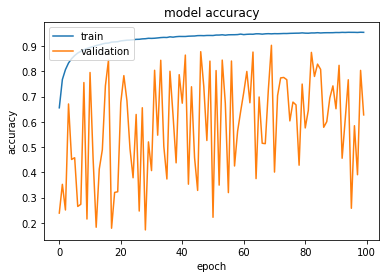

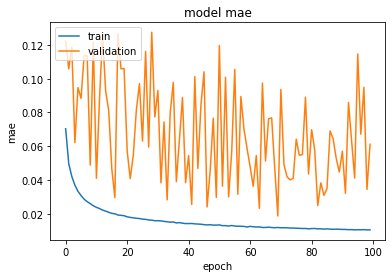

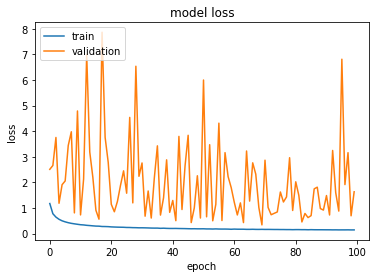

32/32 [==============================] - 1s 24ms/step - loss: 1.6094 - mae: 0.0607 - accuracy: 0.6317

Evaluation:
Loss, MAE, Accuracy [1.6094368696212769, 0.06068430095911026, 0.6317468881607056]
PSDS (0.04141471048513302, 'Valid file')

Filling post processing used.
PSDS (0.4775322754955589, 'Valid file')


/home/alex/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/alex/.local/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Submission file saved at ./challenge_submission.csv




Test Split: (8000, 9000)
Pipeline parameter: {'data_folder': './../data/', 'wav_files_folder': 'final_pre_dataset', 'window_length': 1024, 'window_overlap': 523, 'band_size': 4, 'sample_rate': 16000, 'dev_csv': 'dev-labels.csv', 'eval_csv': 'challenge_filelist_dummy.csv', 'scaling': 'no', 'test_split_range': (8000, 9000), 'prediction_path': './', 'post_processing': 'fill', 'submission_file_path': './challenge_submission.csv'}
Model parameter: {'channels': [32, 64, 64], 'lessParameter': True, 'kernel_size': 3, 'first_kernel_size': 3, 'val_split_fraction': 0.1111111111111111, 'loss': 'categorical_crossentropy', 'learning_rate': 0.001, 'batch_size': 15, 'epochs': 100, 'model_save_path': './', 'load_path': None}
Csv from wav files already existend. Skipping calc_fft.
Scaled numpy files already existend. Skipping scaling and load_data function.
Splitting test set at indices 8000 to 9000 from dev set.
Existing model.h5 removed.
Tensorfl

534/534 [==============================] - 31s 58ms/step - loss: 0.1576 - mae: 0.0115 - accuracy: 0.9505 - val_loss: 4.6074 - val_mae: 0.1038 - val_accuracy: 0.3343

Epoch 00066: val_loss did not improve from 0.37505
Epoch 67/100
534/534 [==============================] - 31s 58ms/step - loss: 0.1643 - mae: 0.0120 - accuracy: 0.9480 - val_loss: 0.5678 - val_mae: 0.0316 - val_accuracy: 0.8333

Epoch 00067: val_loss did not improve from 0.37505
Epoch 68/100
534/534 [==============================] - 31s 58ms/step - loss: 0.1620 - mae: 0.0118 - accuracy: 0.9488 - val_loss: 2.4159 - val_mae: 0.0742 - val_accuracy: 0.5359

Epoch 00068: val_loss did not improve from 0.37505
Epoch 69/100
534/534 [==============================] - 31s 58ms/step - loss: 0.1640 - mae: 0.0120 - accuracy: 0.9483 - val_loss: 1.5020 - val_mae: 0.0657 - val_accuracy: 0.6011

Epoch 00069: val_loss did not improve from 0.37505
Epoch 70/100
534/534 [==============================] - 31s 58ms/step - loss: 0.1534 - mae: 0

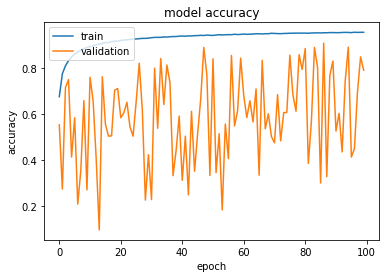

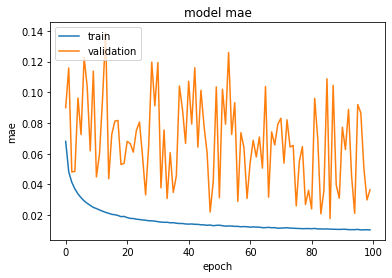

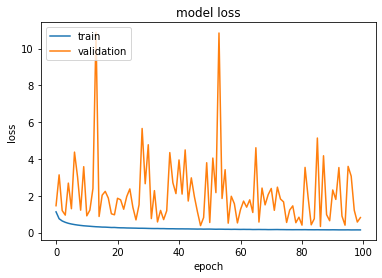

32/32 [==============================] - 1s 24ms/step - loss: 0.8242 - mae: 0.0361 - accuracy: 0.7912

Evaluation:
Loss, MAE, Accuracy [0.8242232203483582, 0.036096345633268356, 0.7912343740463257]
PSDS (0.06772543316249936, 'Valid file')

Filling post processing used.
PSDS (0.46789832506344575, 'Valid file')


/home/alex/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/alex/.local/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Submission file saved at ./challenge_submission.csv




Test Split: (9000, -1)
Pipeline parameter: {'data_folder': './../data/', 'wav_files_folder': 'final_pre_dataset', 'window_length': 1024, 'window_overlap': 523, 'band_size': 4, 'sample_rate': 16000, 'dev_csv': 'dev-labels.csv', 'eval_csv': 'challenge_filelist_dummy.csv', 'scaling': 'no', 'test_split_range': (9000, -1), 'prediction_path': './', 'post_processing': 'fill', 'submission_file_path': './challenge_submission.csv'}
Model parameter: {'channels': [32, 64, 64], 'lessParameter': True, 'kernel_size': 3, 'first_kernel_size': 3, 'val_split_fraction': 0.1111111111111111, 'loss': 'categorical_crossentropy', 'learning_rate': 0.001, 'batch_size': 15, 'epochs': 100, 'model_save_path': './', 'load_path': None}
Csv from wav files already existend. Skipping calc_fft.
Scaled numpy files already existend. Skipping scaling and load_data function.
Splitting test set at indices 9000 to -1 from dev set.
Existing model.h5 removed.
Tensorflow ver


Epoch 00031: val_loss did not improve from 0.53817
Epoch 32/100
593/593 [==============================] - 34s 58ms/step - loss: 0.2016 - mae: 0.0145 - accuracy: 0.9373 - val_loss: 1.7008 - val_mae: 0.0800 - val_accuracy: 0.5041

Epoch 00032: val_loss did not improve from 0.53817
Epoch 33/100
593/593 [==============================] - 35s 58ms/step - loss: 0.1979 - mae: 0.0142 - accuracy: 0.9383 - val_loss: 1.4771 - val_mae: 0.0655 - val_accuracy: 0.6058

Epoch 00033: val_loss did not improve from 0.53817
Epoch 34/100
593/593 [==============================] - 34s 58ms/step - loss: 0.1955 - mae: 0.0139 - accuracy: 0.9389 - val_loss: 3.6216 - val_mae: 0.1013 - val_accuracy: 0.3426

Epoch 00034: val_loss did not improve from 0.53817
Epoch 35/100
593/593 [==============================] - 35s 58ms/step - loss: 0.1943 - mae: 0.0139 - accuracy: 0.9397 - val_loss: 3.2680 - val_mae: 0.0993 - val_accuracy: 0.3635

Epoch 00035: val_loss did not improve from 0.53817
Epoch 36/100
593/593 [======

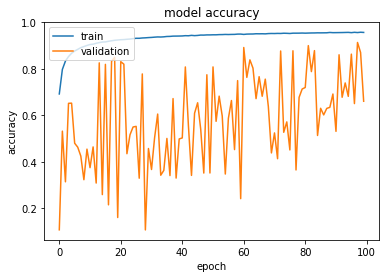

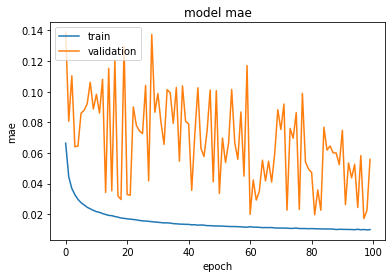

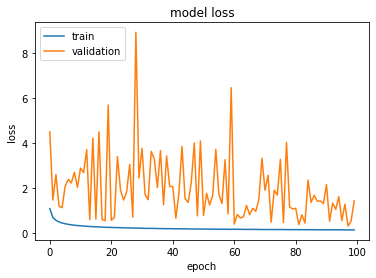

32/32 [==============================] - 1s 24ms/step - loss: 1.4245 - mae: 0.0557 - accuracy: 0.6615 0s - loss: 1.4179 - mae: 0.055

Evaluation:
Loss, MAE, Accuracy [1.4245308637619019, 0.05569107457995415, 0.6615490317344666]
PSDS (0.05115838020735739, 'Valid file')

Filling post processing used.
PSDS (0.4287932378420068, 'Valid file')


/home/alex/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/alex/.local/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Submission file saved at ./challenge_submission.csv




Cross validation summary:
Loss  [3.009159564971924, 0.8151745200157166, 0.9084075093269348, 0.6103496551513672, 2.528195858001709, 0.9049724340438843, 0.47723954916000366, 1.6094368696212769, 0.8242232203483582, 1.4245308637619019]
Mean Loss 1.3111690044403077

MAE [0.08534952253103256, 0.04291342943906784, 0.045700233429670334, 0.03353607654571533, 0.07700760662555695, 0.04102083668112755, 0.02613430842757225, 0.06068430095911026, 0.036096345633268356, 0.05569107457995415]
Mean MAE 0.05041337348520756

Accuracy [0.45941561460494995, 0.7655093669891357, 0.7344375252723694, 0.8219468593597412, 0.5156968832015991, 0.7711374759674072, 0.8654500246047974, 0.6317468881607056, 0.7912343740463257, 0.6615490317344666]
Mean Accuracy 0.7018124043941498

Model PSDS [0.05128172281024561, 0.05106127289354757, 0.11239464104302253, 0.07955555661577608, 0.055180366590178435, 0.06597354901950468, 0.11502392197142347, 0.04141471048513302, 0.0677254

In [22]:
# cross validation 10 fold, val split 0.1, wie submission1
pipe_param = {'data_folder': './../data/',
                  'wav_files_folder': 'final_pre_dataset', # fft parameter
                  'window_length': 1024, 'window_overlap': 523,
                  'band_size': 4, 'sample_rate': 16000,
                  'dev_csv': 'dev-labels.csv', # filelisten, falls man doch auf kleinerem probieren moechte
                  'eval_csv': 'challenge_filelist_dummy.csv',
                  'scaling': 'no', # 'standard', 'minmax' oder 'no' wenn kein scaling sein soll
                  'test_split_range': (9000, -1), # index anfang und ende aus dev set 
                  'prediction_path': './', # wo prediction csvs gespeichert werden sollen
                  'post_processing': 'fill', # 'fill' is das von Jannes
                  'submission_file_path': './challenge_submission.csv'}
unet_param = {'channels': [32, 64, 64],
              'lessParameter': True,
              'kernel_size': 3,
              'first_kernel_size': 3,
              'val_split_fraction': 1/9, # 1/9 damit man 1000 von den 9000 abzweigt
              'loss': 'categorical_crossentropy', # bbdc.dice_loss moeglich
              'learning_rate': 0.001,
              'batch_size': 15,
              'epochs': 100,
              'model_save_path': './',
              'load_path': None} # Wenn trainiert werden soll: None; Submission 1: 'model9561.h5'
test_index_list = [(0, 1000), (1000, 2000), (2000, 3000), (3000, 4000), (4000, 5000),
                   (5000, 6000), (6000, 7000), (7000, 8000), (8000, 9000), (9000, -1)]
cross_val(pipeline_u_net_1, pipe_param, unet_param, test_index_list)

# Scaling

0it [00:00, ?it/s]

Pipeline parameter: {'data_folder': './../data/', 'wav_files_folder': 'final_pre_dataset', 'window_length': 1024, 'window_overlap': 523, 'band_size': 4, 'sample_rate': 16000, 'dev_csv': 'dev-labels.csv', 'eval_csv': 'challenge_filelist_dummy.csv', 'scaling': 'standard', 'test_split_range': (8000, -1), 'prediction_path': './', 'post_processing': 'fill', 'submission_file_path': './challenge_submission.csv'}
Model parameter: {'channels': [32, 64, 64], 'lessParameter': True, 'kernel_size': 3, 'first_kernel_size': 3, 'val_split_fraction': 0.2, 'loss': 'categorical_crossentropy', 'learning_rate': 0.001, 'batch_size': 15, 'epochs': 100, 'model_save_path': './', 'load_path': None}
Csv from wav files already existend. Skipping calc_fft.
Loading dev set:


30044it [07:11, 69.57it/s]


Loading eval set:


3000it [02:31, 19.74it/s]


Scaling files.
Saving to numpy arrays.
Splitting test set at indices 8000 to -1 from dev set.
Existing model.h5 removed.
Tensorflow version: 2.4.1
Epoch 1/100
534/534 [==============================] - 65s 90ms/step - loss: 1.4858 - mae: 0.0890 - accuracy: 0.5947 - val_loss: 1.8053 - val_mae: 0.0966 - val_accuracy: 0.4728

Epoch 00001: val_loss improved from inf to 1.80527, saving model to model.h5
Epoch 2/100
534/534 [==============================] - 31s 57ms/step - loss: 0.7923 - mae: 0.0507 - accuracy: 0.7646 - val_loss: 2.6380 - val_mae: 0.1087 - val_accuracy: 0.3342

Epoch 00002: val_loss did not improve from 1.80527
Epoch 3/100
534/534 [==============================] - 30s 57ms/step - loss: 0.6394 - mae: 0.0421 - accuracy: 0.8061 - val_loss: 3.3822 - val_mae: 0.1160 - val_accuracy: 0.2714

Epoch 00003: val_loss did not improve from 1.80527
Epoch 4/100
534/534 [==============================] - 30s 57ms/step - loss: 0.5543 - mae: 0.0371 - accuracy: 0.8325 - val_loss: 0.9810 - va


Epoch 00035: val_loss did not improve from 0.69126
Epoch 36/100
534/534 [==============================] - 31s 57ms/step - loss: 0.2108 - mae: 0.0150 - accuracy: 0.9344 - val_loss: 3.6473 - val_mae: 0.1024 - val_accuracy: 0.3415

Epoch 00036: val_loss did not improve from 0.69126
Epoch 37/100
534/534 [==============================] - 31s 57ms/step - loss: 0.2043 - mae: 0.0146 - accuracy: 0.9364 - val_loss: 3.2847 - val_mae: 0.1062 - val_accuracy: 0.3161

Epoch 00037: val_loss did not improve from 0.69126
Epoch 38/100
534/534 [==============================] - 31s 57ms/step - loss: 0.2019 - mae: 0.0145 - accuracy: 0.9372 - val_loss: 2.1069 - val_mae: 0.0798 - val_accuracy: 0.5068

Epoch 00038: val_loss did not improve from 0.69126
Epoch 39/100
534/534 [==============================] - 31s 57ms/step - loss: 0.1964 - mae: 0.0142 - accuracy: 0.9388 - val_loss: 2.1644 - val_mae: 0.0706 - val_accuracy: 0.5744

Epoch 00039: val_loss did not improve from 0.69126
Epoch 40/100
534/534 [======

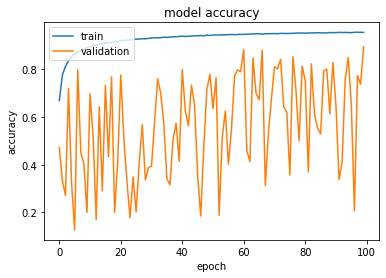

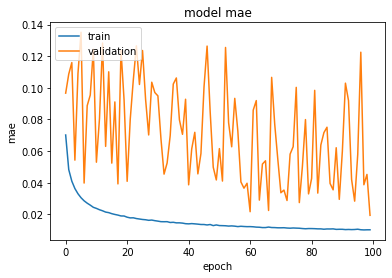

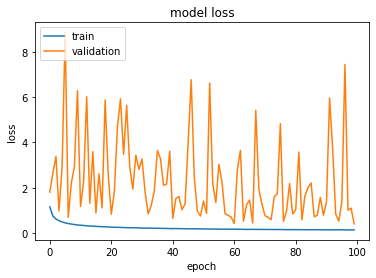

63/63 [==============================] - 2s 28ms/step - loss: 0.4073 - mae: 0.0194 - accuracy: 0.8948

Evaluation:
Loss, MAE, Accuracy [0.40726831555366516, 0.019407635554671288, 0.8947770595550537]
PSDS (0.13540364501391036, 'Valid file')

Filling post processing used.
PSDS (0.7309687965038966, 'Valid file')


/home/alex/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/alex/.local/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Submission file saved at ./challenge_submission.csv


([0.40726831555366516, 0.019407635554671288, 0.8947770595550537],
 0.13540364501391036,
 0.7309687965038966)

In [25]:
# scaling
pipe_param = {'data_folder': './../data/',
                  'wav_files_folder': 'final_pre_dataset', # fft parameter
                  'window_length': 1024, 'window_overlap': 523,
                  'band_size': 4, 'sample_rate': 16000,
                  'dev_csv': 'dev-labels.csv', # filelisten, falls man doch auf kleinerem probieren moechte
                  'eval_csv': 'challenge_filelist_dummy.csv',
                  'scaling': 'standard', # 'standard', 'minmax' oder 'no' wenn kein scaling sein soll
                  'test_split_range': (8000, -1), # index anfang und ende aus dev set 
                  'prediction_path': './', # wo prediction csvs gespeichert werden sollen
                  'post_processing': 'fill', # 'fill' is das von Jannes
                  'submission_file_path': './challenge_submission.csv'}
unet_param = {'channels': [32, 64, 64],
              'lessParameter': True,
              'kernel_size': 3,
              'first_kernel_size': 3,
              'val_split_fraction': 0.2, # 1/9 damit man 1000 von den 9000 abzweigt
              'loss': 'categorical_crossentropy', # bbdc.dice_loss moeglich
              'learning_rate': 0.001,
              'batch_size': 15,
              'epochs': 100,
              'model_save_path': './',
              'load_path': None} # Wenn trainiert werden soll: None; Submission 1: 'model9561.h5'

pipeline_u_net_1(pipe_param, unet_param)

0it [00:00, ?it/s]

Pipeline parameter: {'data_folder': './../data/', 'wav_files_folder': 'final_pre_dataset', 'window_length': 1024, 'window_overlap': 523, 'band_size': 4, 'sample_rate': 16000, 'dev_csv': 'dev-labels.csv', 'eval_csv': 'challenge_filelist_dummy.csv', 'scaling': 'minmax', 'test_split_range': (8000, -1), 'prediction_path': './', 'post_processing': 'fill', 'submission_file_path': './challenge_submission.csv'}
Model parameter: {'channels': [32, 64, 64], 'lessParameter': True, 'kernel_size': 3, 'first_kernel_size': 3, 'val_split_fraction': 0.2, 'loss': 'categorical_crossentropy', 'learning_rate': 0.001, 'batch_size': 15, 'epochs': 100, 'model_save_path': './', 'load_path': None}
Csv from wav files already existend. Skipping calc_fft.
Loading dev set:


30044it [08:37, 58.01it/s]


Loading eval set:


3000it [02:21, 21.18it/s]


Scaling files.
Saving to numpy arrays.
Splitting test set at indices 8000 to -1 from dev set.
Existing model.h5 removed.
Tensorflow version: 2.4.1
Epoch 1/100
534/534 [==============================] - 69s 107ms/step - loss: 1.4551 - mae: 0.0875 - accuracy: 0.6083 - val_loss: 2.0807 - val_mae: 0.0946 - val_accuracy: 0.4737

Epoch 00001: val_loss improved from inf to 2.08070, saving model to model.h5
Epoch 2/100
534/534 [==============================] - 32s 61ms/step - loss: 0.7808 - mae: 0.0500 - accuracy: 0.7681 - val_loss: 3.9662 - val_mae: 0.1258 - val_accuracy: 0.1969

Epoch 00002: val_loss did not improve from 2.08070
Epoch 3/100
534/534 [==============================] - 32s 61ms/step - loss: 0.6251 - mae: 0.0411 - accuracy: 0.8123 - val_loss: 4.5546 - val_mae: 0.1252 - val_accuracy: 0.1969

Epoch 00003: val_loss did not improve from 2.08070
Epoch 4/100
534/534 [==============================] - 32s 61ms/step - loss: 0.5397 - mae: 0.0360 - accuracy: 0.8384 - val_loss: 3.3928 - v


Epoch 00035: val_loss did not improve from 0.56797
Epoch 36/100
534/534 [==============================] - 32s 60ms/step - loss: 0.2074 - mae: 0.0149 - accuracy: 0.9351 - val_loss: 5.4608 - val_mae: 0.1195 - val_accuracy: 0.2249

Epoch 00036: val_loss did not improve from 0.56797
Epoch 37/100
534/534 [==============================] - 32s 60ms/step - loss: 0.2003 - mae: 0.0143 - accuracy: 0.9381 - val_loss: 0.5422 - val_mae: 0.0269 - val_accuracy: 0.8563

Epoch 00037: val_loss improved from 0.56797 to 0.54225, saving model to model.h5
Epoch 38/100
534/534 [==============================] - 32s 60ms/step - loss: 0.1990 - mae: 0.0142 - accuracy: 0.9380 - val_loss: 1.1639 - val_mae: 0.0579 - val_accuracy: 0.6627

Epoch 00038: val_loss did not improve from 0.54225
Epoch 39/100
534/534 [==============================] - 31s 58ms/step - loss: 0.1918 - mae: 0.0137 - accuracy: 0.9409 - val_loss: 0.6980 - val_mae: 0.0311 - val_accuracy: 0.8270

Epoch 00039: val_loss did not improve from 0.5422

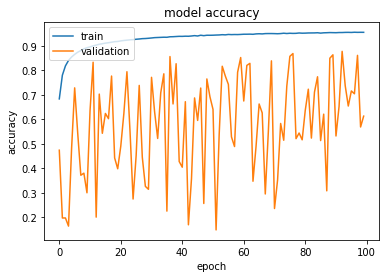

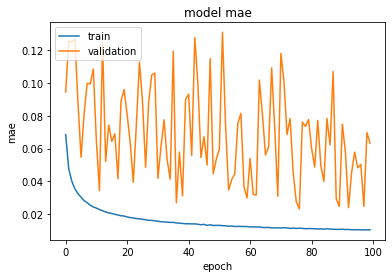

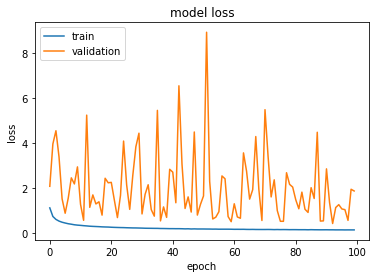

63/63 [==============================] - 2s 24ms/step - loss: 1.8731 - mae: 0.0633 - accuracy: 0.6128

Evaluation:
Loss, MAE, Accuracy [1.8731404542922974, 0.0632973313331604, 0.6127798557281494]
PSDS (0.004044476306394667, 'Valid file')

Filling post processing used.
PSDS (0.24811107875550611, 'Valid file')


/home/alex/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/alex/.local/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Submission file saved at ./challenge_submission.csv


([1.8731404542922974, 0.0632973313331604, 0.6127798557281494],
 0.004044476306394667,
 0.24811107875550611)

In [26]:
# scaling
pipe_param = {'data_folder': './../data/',
                  'wav_files_folder': 'final_pre_dataset', # fft parameter
                  'window_length': 1024, 'window_overlap': 523,
                  'band_size': 4, 'sample_rate': 16000,
                  'dev_csv': 'dev-labels.csv', # filelisten, falls man doch auf kleinerem probieren moechte
                  'eval_csv': 'challenge_filelist_dummy.csv',
                  'scaling': 'minmax', # 'standard', 'minmax' oder 'no' wenn kein scaling sein soll
                  'test_split_range': (8000, -1), # index anfang und ende aus dev set 
                  'prediction_path': './', # wo prediction csvs gespeichert werden sollen
                  'post_processing': 'fill', # 'fill' is das von Jannes
                  'submission_file_path': './challenge_submission.csv'}
unet_param = {'channels': [32, 64, 64],
              'lessParameter': True,
              'kernel_size': 3,
              'first_kernel_size': 3,
              'val_split_fraction': 0.2, # 1/9 damit man 1000 von den 9000 abzweigt
              'loss': 'categorical_crossentropy', # bbdc.dice_loss moeglich
              'learning_rate': 0.001,
              'batch_size': 15,
              'epochs': 100,
              'model_save_path': './',
              'load_path': None} # Wenn trainiert werden soll: None; Submission 1: 'model9561.h5'

pipeline_u_net_1(pipe_param, unet_param)

Test Split: (0, 2000)
Pipeline parameter: {'data_folder': './../data/', 'wav_files_folder': 'final_pre_dataset', 'window_length': 1024, 'window_overlap': 523, 'band_size': 4, 'sample_rate': 16000, 'dev_csv': 'dev-labels.csv', 'eval_csv': 'challenge_filelist_dummy.csv', 'scaling': 'standard', 'test_split_range': (0, 2000), 'prediction_path': './', 'post_processing': 'fill', 'submission_file_path': './challenge_submission.csv'}
Model parameter: {'channels': [8, 16], 'lessParameter': True, 'kernel_size': 3, 'first_kernel_size': 3, 'val_split_fraction': 0.2, 'loss': 'categorical_crossentropy', 'learning_rate': 0.001, 'batch_size': 512, 'epochs': 100, 'model_save_path': './', 'load_path': None}
Csv from wav files already existend. Skipping calc_fft.
Scaled numpy files already existend. Skipping scaling and load_data function.
Splitting test set at indices 0 to 2000 from dev set.
Existing model.h5 removed.
Tensorflow version: 2.4.1
Epoch 1/100
13/13 [==============================] - 16s 644

13/13 [==============================] - 6s 482ms/step - loss: 1.0078 - mae: 0.0607 - accuracy: 0.7062 - val_loss: 1.1883 - val_mae: 0.0758 - val_accuracy: 0.6560

Epoch 00066: val_loss did not improve from 1.13733
Epoch 67/100
13/13 [==============================] - 6s 449ms/step - loss: 0.9857 - mae: 0.0595 - accuracy: 0.7123 - val_loss: 2.2729 - val_mae: 0.1068 - val_accuracy: 0.4063

Epoch 00067: val_loss did not improve from 1.13733
Epoch 68/100
13/13 [==============================] - 6s 449ms/step - loss: 0.9794 - mae: 0.0597 - accuracy: 0.7145 - val_loss: 1.1584 - val_mae: 0.0667 - val_accuracy: 0.6714

Epoch 00068: val_loss did not improve from 1.13733
Epoch 69/100
13/13 [==============================] - 6s 453ms/step - loss: 0.9872 - mae: 0.0597 - accuracy: 0.7113 - val_loss: 1.1834 - val_mae: 0.0732 - val_accuracy: 0.6567

Epoch 00069: val_loss did not improve from 1.13733
Epoch 70/100
13/13 [==============================] - 6s 454ms/step - loss: 0.9958 - mae: 0.0602 - ac

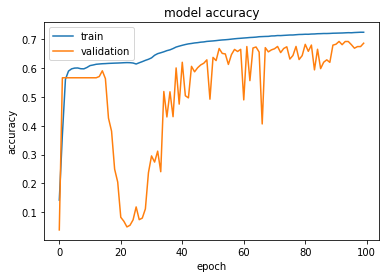

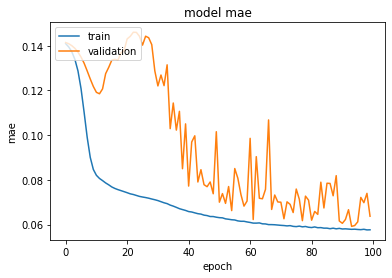

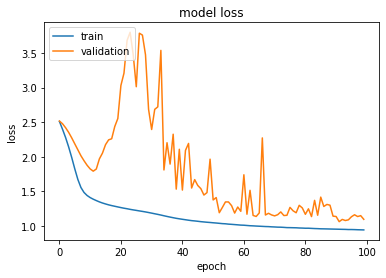

63/63 [==============================] - 1s 14ms/step - loss: 1.0836 - mae: 0.0633 - accuracy: 0.6910

Evaluation:
Loss, MAE, Accuracy [1.0835613012313843, 0.06333266943693161, 0.6909624934196472]
PSDS (0.0, 'Valid file')

Filling post processing used.
PSDS (nan, "Each file needs to have at least one label. 57 file(s) missing, e.g. ['00121_mix.wav', '01853_mix.wav', '01932_mix.wav']")


/home/alex/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/alex/.local/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Submission file saved at ./challenge_submission.csv




Test Split: (2000, 4000)
Pipeline parameter: {'data_folder': './../data/', 'wav_files_folder': 'final_pre_dataset', 'window_length': 1024, 'window_overlap': 523, 'band_size': 4, 'sample_rate': 16000, 'dev_csv': 'dev-labels.csv', 'eval_csv': 'challenge_filelist_dummy.csv', 'scaling': 'standard', 'test_split_range': (2000, 4000), 'prediction_path': './', 'post_processing': 'fill', 'submission_file_path': './challenge_submission.csv'}
Model parameter: {'channels': [8, 16], 'lessParameter': True, 'kernel_size': 3, 'first_kernel_size': 3, 'val_split_fraction': 0.2, 'loss': 'categorical_crossentropy', 'learning_rate': 0.001, 'batch_size': 512, 'epochs': 100, 'model_save_path': './', 'load_path': None}
Csv from wav files already existend. Skipping calc_fft.
Scaled numpy files already existend. Skipping scaling and load_data function.
Splitting test set at indices 2000 to 4000 from dev set.
Existing model.h5 removed.
Tensorflow version: 2

13/13 [==============================] - 6s 454ms/step - loss: 1.2082 - mae: 0.0710 - accuracy: 0.6439 - val_loss: 3.0450 - val_mae: 0.1387 - val_accuracy: 0.1321

Epoch 00031: val_loss did not improve from 1.80703
Epoch 32/100
13/13 [==============================] - 6s 463ms/step - loss: 1.1997 - mae: 0.0709 - accuracy: 0.6499 - val_loss: 3.1238 - val_mae: 0.1351 - val_accuracy: 0.1686

Epoch 00032: val_loss did not improve from 1.80703
Epoch 33/100
13/13 [==============================] - 5s 406ms/step - loss: 1.1826 - mae: 0.0704 - accuracy: 0.6565 - val_loss: 2.4001 - val_mae: 0.1221 - val_accuracy: 0.3140

Epoch 00033: val_loss did not improve from 1.80703
Epoch 34/100
13/13 [==============================] - 5s 417ms/step - loss: 1.1811 - mae: 0.0703 - accuracy: 0.6559 - val_loss: 3.2541 - val_mae: 0.1305 - val_accuracy: 0.2030

Epoch 00034: val_loss did not improve from 1.80703
Epoch 35/100
13/13 [==============================] - 5s 420ms/step - loss: 1.1654 - mae: 0.0696 - ac


Epoch 00066: val_loss did not improve from 1.42778
Epoch 67/100
13/13 [==============================] - 7s 510ms/step - loss: 0.9864 - mae: 0.0602 - accuracy: 0.7160 - val_loss: 1.7856 - val_mae: 0.0924 - val_accuracy: 0.5210

Epoch 00067: val_loss did not improve from 1.42778
Epoch 68/100
13/13 [==============================] - 7s 515ms/step - loss: 0.9820 - mae: 0.0598 - accuracy: 0.7177 - val_loss: 2.4383 - val_mae: 0.1099 - val_accuracy: 0.3604

Epoch 00068: val_loss did not improve from 1.42778
Epoch 69/100
13/13 [==============================] - 7s 511ms/step - loss: 0.9849 - mae: 0.0597 - accuracy: 0.7170 - val_loss: 2.1331 - val_mae: 0.1021 - val_accuracy: 0.4346

Epoch 00069: val_loss did not improve from 1.42778
Epoch 70/100
13/13 [==============================] - 7s 509ms/step - loss: 0.9918 - mae: 0.0600 - accuracy: 0.7144 - val_loss: 2.1293 - val_mae: 0.0982 - val_accuracy: 0.4600

Epoch 00070: val_loss did not improve from 1.42778
Epoch 71/100
13/13 [================

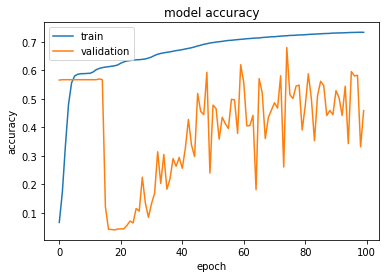

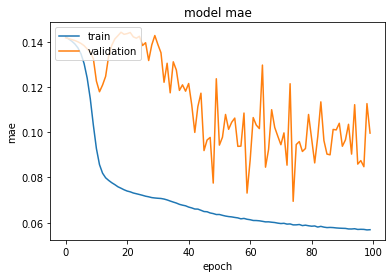

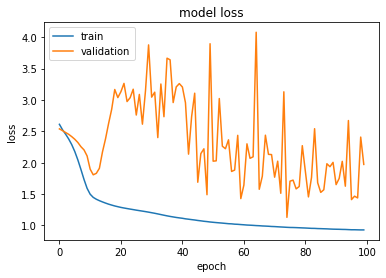

63/63 [==============================] - 1s 15ms/step - loss: 2.0188 - mae: 0.1017 - accuracy: 0.4446

Evaluation:
Loss, MAE, Accuracy [2.0187647342681885, 0.10167809575796127, 0.4446265697479248]
PSDS (0.0, 'Valid file')

Filling post processing used.
PSDS (0.05574583440823073, 'Valid file')


/home/alex/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/alex/.local/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Submission file saved at ./challenge_submission.csv




Test Split: (4000, 6000)
Pipeline parameter: {'data_folder': './../data/', 'wav_files_folder': 'final_pre_dataset', 'window_length': 1024, 'window_overlap': 523, 'band_size': 4, 'sample_rate': 16000, 'dev_csv': 'dev-labels.csv', 'eval_csv': 'challenge_filelist_dummy.csv', 'scaling': 'standard', 'test_split_range': (4000, 6000), 'prediction_path': './', 'post_processing': 'fill', 'submission_file_path': './challenge_submission.csv'}
Model parameter: {'channels': [8, 16], 'lessParameter': True, 'kernel_size': 3, 'first_kernel_size': 3, 'val_split_fraction': 0.2, 'loss': 'categorical_crossentropy', 'learning_rate': 0.001, 'batch_size': 512, 'epochs': 100, 'model_save_path': './', 'load_path': None}
Csv from wav files already existend. Skipping calc_fft.
Scaled numpy files already existend. Skipping scaling and load_data function.
Splitting test set at indices 4000 to 6000 from dev set.
Existing model.h5 removed.
Tensorflow version: 2


Epoch 00066: val_loss improved from 1.29298 to 1.28597, saving model to model.h5
Epoch 67/100
13/13 [==============================] - 6s 493ms/step - loss: 0.9502 - mae: 0.0586 - accuracy: 0.7212 - val_loss: 1.5289 - val_mae: 0.0669 - val_accuracy: 0.6187

Epoch 00067: val_loss did not improve from 1.28597
Epoch 68/100
13/13 [==============================] - 6s 486ms/step - loss: 0.9415 - mae: 0.0582 - accuracy: 0.7245 - val_loss: 1.5266 - val_mae: 0.0686 - val_accuracy: 0.6175

Epoch 00068: val_loss did not improve from 1.28597
Epoch 69/100
13/13 [==============================] - 6s 499ms/step - loss: 0.9472 - mae: 0.0583 - accuracy: 0.7241 - val_loss: 1.5432 - val_mae: 0.0729 - val_accuracy: 0.6024

Epoch 00069: val_loss did not improve from 1.28597
Epoch 70/100
13/13 [==============================] - 6s 487ms/step - loss: 0.9459 - mae: 0.0584 - accuracy: 0.7217 - val_loss: 2.1186 - val_mae: 0.0898 - val_accuracy: 0.4822

Epoch 00070: val_loss did not improve from 1.28597
Epoch 

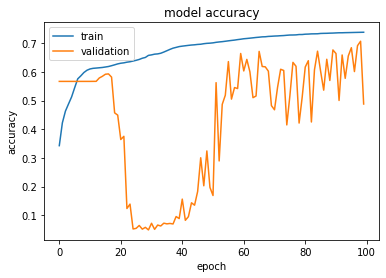

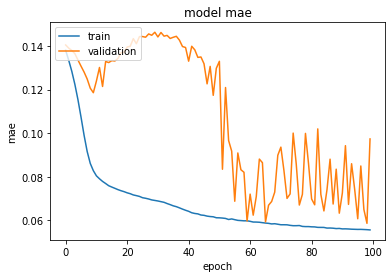

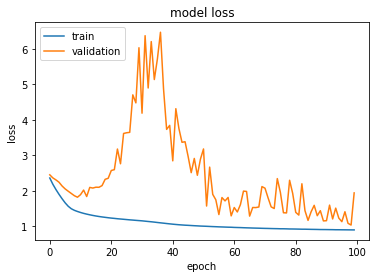

63/63 [==============================] - 1s 13ms/step - loss: 1.9627 - mae: 0.0984 - accuracy: 0.4851

Evaluation:
Loss, MAE, Accuracy [1.962740182876587, 0.09835664927959442, 0.4850812554359436]
PSDS (0.0065464861379755, 'Valid file')

Filling post processing used.
PSDS (nan, "Each file needs to have at least one label. 1 file(s) missing, e.g. ['05312_mix.wav']")


/home/alex/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/alex/.local/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Submission file saved at ./challenge_submission.csv




Test Split: (6000, 8000)
Pipeline parameter: {'data_folder': './../data/', 'wav_files_folder': 'final_pre_dataset', 'window_length': 1024, 'window_overlap': 523, 'band_size': 4, 'sample_rate': 16000, 'dev_csv': 'dev-labels.csv', 'eval_csv': 'challenge_filelist_dummy.csv', 'scaling': 'standard', 'test_split_range': (6000, 8000), 'prediction_path': './', 'post_processing': 'fill', 'submission_file_path': './challenge_submission.csv'}
Model parameter: {'channels': [8, 16], 'lessParameter': True, 'kernel_size': 3, 'first_kernel_size': 3, 'val_split_fraction': 0.2, 'loss': 'categorical_crossentropy', 'learning_rate': 0.001, 'batch_size': 512, 'epochs': 100, 'model_save_path': './', 'load_path': None}
Csv from wav files already existend. Skipping calc_fft.
Scaled numpy files already existend. Skipping scaling and load_data function.
Splitting test set at indices 6000 to 8000 from dev set.
Existing model.h5 removed.
Tensorflow version: 2

13/13 [==============================] - 6s 476ms/step - loss: 1.0943 - mae: 0.0658 - accuracy: 0.6825 - val_loss: 1.5032 - val_mae: 0.0733 - val_accuracy: 0.6016

Epoch 00031: val_loss did not improve from 1.46388
Epoch 32/100
13/13 [==============================] - 6s 489ms/step - loss: 1.0884 - mae: 0.0656 - accuracy: 0.6853 - val_loss: 1.5853 - val_mae: 0.0641 - val_accuracy: 0.6217

Epoch 00032: val_loss did not improve from 1.46388
Epoch 33/100
13/13 [==============================] - 6s 504ms/step - loss: 1.0786 - mae: 0.0650 - accuracy: 0.6887 - val_loss: 1.6666 - val_mae: 0.0628 - val_accuracy: 0.6206

Epoch 00033: val_loss did not improve from 1.46388
Epoch 34/100
13/13 [==============================] - 6s 483ms/step - loss: 1.0755 - mae: 0.0650 - accuracy: 0.6893 - val_loss: 1.8680 - val_mae: 0.0617 - val_accuracy: 0.6144

Epoch 00034: val_loss did not improve from 1.46388
Epoch 35/100
13/13 [==============================] - 6s 480ms/step - loss: 1.0653 - mae: 0.0644 - ac

INFO:tensorflow:Assets written to: ./model/assets


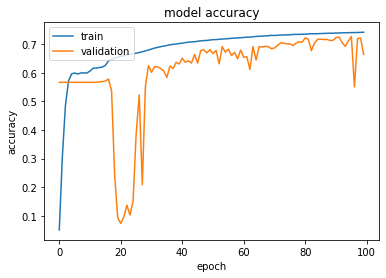

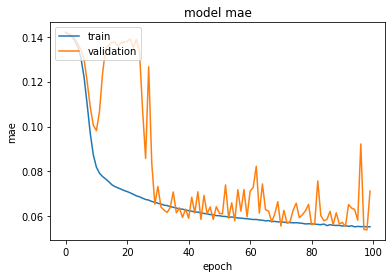

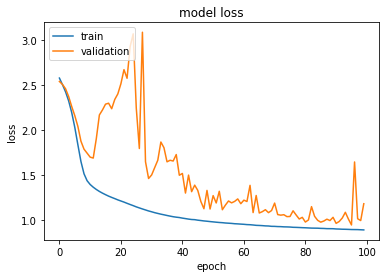

63/63 [==============================] - 1s 12ms/step - loss: 1.1856 - mae: 0.0712 - accuracy: 0.6692

Evaluation:
Loss, MAE, Accuracy [1.185621738433838, 0.0711718425154686, 0.6691593527793884]
PSDS (0.0, 'Valid file')

Filling post processing used.
PSDS (nan, "Each file needs to have at least one label. 8 file(s) missing, e.g. ['06230_mix.wav', '07357_mix.wav', '07007_mix.wav']")


/home/alex/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/alex/.local/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Submission file saved at ./challenge_submission.csv




Test Split: (8000, -1)
Pipeline parameter: {'data_folder': './../data/', 'wav_files_folder': 'final_pre_dataset', 'window_length': 1024, 'window_overlap': 523, 'band_size': 4, 'sample_rate': 16000, 'dev_csv': 'dev-labels.csv', 'eval_csv': 'challenge_filelist_dummy.csv', 'scaling': 'standard', 'test_split_range': (8000, -1), 'prediction_path': './', 'post_processing': 'fill', 'submission_file_path': './challenge_submission.csv'}
Model parameter: {'channels': [8, 16], 'lessParameter': True, 'kernel_size': 3, 'first_kernel_size': 3, 'val_split_fraction': 0.2, 'loss': 'categorical_crossentropy', 'learning_rate': 0.001, 'batch_size': 512, 'epochs': 100, 'model_save_path': './', 'load_path': None}
Csv from wav files already existend. Skipping calc_fft.
Scaled numpy files already existend. Skipping scaling and load_data function.
Splitting test set at indices 8000 to -1 from dev set.
Existing model.h5 removed.
Tensorflow version: 2.4.1
E


Epoch 00030: val_loss did not improve from 1.62280
Epoch 31/100
16/16 [==============================] - 10s 611ms/step - loss: 1.1513 - mae: 0.0682 - accuracy: 0.6586 - val_loss: 3.4350 - val_mae: 0.1422 - val_accuracy: 0.0795

Epoch 00031: val_loss did not improve from 1.62280
Epoch 32/100
16/16 [==============================] - 9s 568ms/step - loss: 1.1325 - mae: 0.0677 - accuracy: 0.6662 - val_loss: 3.2614 - val_mae: 0.1411 - val_accuracy: 0.0934

Epoch 00032: val_loss did not improve from 1.62280
Epoch 33/100
16/16 [==============================] - 9s 557ms/step - loss: 1.1245 - mae: 0.0674 - accuracy: 0.6697 - val_loss: 3.2129 - val_mae: 0.1387 - val_accuracy: 0.1383

Epoch 00033: val_loss did not improve from 1.62280
Epoch 34/100
16/16 [==============================] - 9s 592ms/step - loss: 1.1160 - mae: 0.0670 - accuracy: 0.6719 - val_loss: 4.8256 - val_mae: 0.1439 - val_accuracy: 0.0746

Epoch 00034: val_loss did not improve from 1.62280
Epoch 35/100
16/16 [===============

16/16 [==============================] - 7s 452ms/step - loss: 0.9426 - mae: 0.0584 - accuracy: 0.7196 - val_loss: 1.2103 - val_mae: 0.0644 - val_accuracy: 0.6635

Epoch 00066: val_loss did not improve from 1.09006
Epoch 67/100
16/16 [==============================] - 8s 529ms/step - loss: 0.9458 - mae: 0.0585 - accuracy: 0.7192 - val_loss: 1.2027 - val_mae: 0.0663 - val_accuracy: 0.6616

Epoch 00067: val_loss did not improve from 1.09006
Epoch 68/100
16/16 [==============================] - 7s 443ms/step - loss: 0.9434 - mae: 0.0583 - accuracy: 0.7206 - val_loss: 1.3341 - val_mae: 0.0808 - val_accuracy: 0.6283

Epoch 00068: val_loss did not improve from 1.09006
Epoch 69/100
16/16 [==============================] - 7s 415ms/step - loss: 0.9404 - mae: 0.0584 - accuracy: 0.7209 - val_loss: 1.4777 - val_mae: 0.0700 - val_accuracy: 0.6233

Epoch 00069: val_loss did not improve from 1.09006
Epoch 70/100
16/16 [==============================] - 6s 408ms/step - loss: 0.9324 - mae: 0.0577 - ac

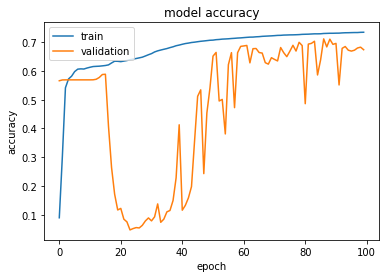

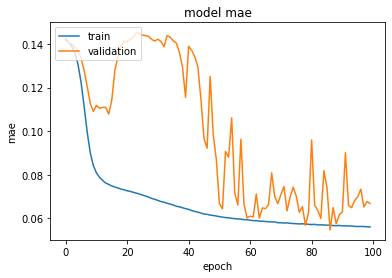

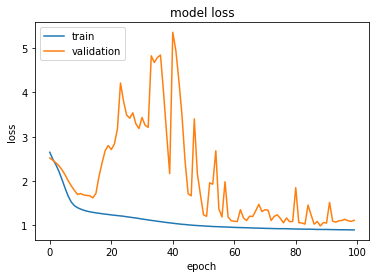

63/63 [==============================] - 1s 12ms/step - loss: 1.1163 - mae: 0.0668 - accuracy: 0.6733

Evaluation:
Loss, MAE, Accuracy [1.1162587404251099, 0.06678115576505661, 0.6733241677284241]
PSDS (0.03849374473938077, 'Valid file')

Filling post processing used.
PSDS (nan, "Each file needs to have at least one label. 5 file(s) missing, e.g. ['09773_mix.wav', '09658_mix.wav', '09316_mix.wav']")


/home/alex/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/alex/.local/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Submission file saved at ./challenge_submission.csv




Cross validation summary:
Loss  [1.0835613012313843, 2.0187647342681885, 1.962740182876587, 1.185621738433838, 1.1162587404251099]
Mean Loss 1.4733893394470214

MAE [0.06333266943693161, 0.10167809575796127, 0.09835664927959442, 0.0711718425154686, 0.06678115576505661]
Mean MAE 0.08026408255100251

Accuracy [0.6909624934196472, 0.4446265697479248, 0.4850812554359436, 0.6691593527793884, 0.6733241677284241]
Mean Accuracy 0.5926307678222656

Model PSDS [0.0, 0.0, 0.0065464861379755, 0.0, 0.03849374473938077]
Mean model PSDS 0.009008046175471254

Post processed PSDS [nan, 0.05574583440823073, nan, nan, nan]
Mean Post processed PSDS nan


In [5]:
# crossval scaling channel 8 16
pipe_param = {'data_folder': './../data/',
                  'wav_files_folder': 'final_pre_dataset', # fft parameter
                  'window_length': 1024, 'window_overlap': 523,
                  'band_size': 4, 'sample_rate': 16000,
                  'dev_csv': 'dev-labels.csv', # filelisten, falls man doch auf kleinerem probieren moechte
                  'eval_csv': 'challenge_filelist_dummy.csv',
                  'scaling': 'standard', # 'standard', 'minmax' oder 'no' wenn kein scaling sein soll
                  'test_split_range': (8000, -1), # index anfang und ende aus dev set 
                  'prediction_path': './', # wo prediction csvs gespeichert werden sollen
                  'post_processing': 'fill', # 'fill' is das von Jannes
                  'submission_file_path': './challenge_submission.csv'}
unet_param = {'channels': [8, 16],
              'lessParameter': True,
              'kernel_size': 3,
              'first_kernel_size': 3,
              'val_split_fraction': 0.2, # 1/9 damit man 1000 von den 9000 abzweigt
              'loss': 'categorical_crossentropy', # bbdc.dice_loss moeglich
              'learning_rate': 0.001,
              'batch_size': 512,
              'epochs': 100,
              'model_save_path': './',
              'load_path': None} # Wenn trainiert werden soll: None; Submission 1: 'model9561.h5'
test_index_list = [(0, 2000), (2000, 4000), (4000, 6000), (6000, 8000), (8000,  -1)]
cross_val(pipeline_u_net_1, pipe_param, unet_param, test_index_list)

Test Split: (0, 2000)
Pipeline parameter: {'data_folder': './../data/', 'wav_files_folder': 'final_pre_dataset', 'window_length': 1024, 'window_overlap': 523, 'band_size': 4, 'sample_rate': 16000, 'dev_csv': 'dev-labels.csv', 'eval_csv': 'challenge_filelist_dummy.csv', 'scaling': 'standard', 'test_split_range': (0, 2000), 'prediction_path': './', 'post_processing': 'fill', 'submission_file_path': './challenge_submission.csv'}
Model parameter: {'channels': [32, 64, 64], 'lessParameter': True, 'kernel_size': 3, 'first_kernel_size': 3, 'val_split_fraction': 0.2, 'loss': 'categorical_crossentropy', 'learning_rate': 0.001, 'batch_size': 512, 'epochs': 100, 'model_save_path': './', 'load_path': None}
Csv from wav files already existend. Skipping calc_fft.
Scaled numpy files already existend. Skipping scaling and load_data function.
Splitting test set at indices 0 to 2000 from dev set.
Existing model.h5 removed.
Tensorflow version: 2.4.1
Epoch 1/100
13/13 [==============================] - 54

13/13 [==============================] - 24s 2s/step - loss: 0.2901 - mae: 0.0201 - accuracy: 0.9128 - val_loss: 0.7911 - val_mae: 0.0348 - val_accuracy: 0.8061

Epoch 00065: val_loss did not improve from 0.57074
Epoch 66/100
13/13 [==============================] - 24s 2s/step - loss: 0.2957 - mae: 0.0203 - accuracy: 0.9114 - val_loss: 0.7469 - val_mae: 0.0336 - val_accuracy: 0.8143

Epoch 00066: val_loss did not improve from 0.57074
Epoch 67/100
13/13 [==============================] - 24s 2s/step - loss: 0.2839 - mae: 0.0198 - accuracy: 0.9144 - val_loss: 0.8005 - val_mae: 0.0352 - val_accuracy: 0.8051

Epoch 00067: val_loss did not improve from 0.57074
Epoch 68/100
13/13 [==============================] - 25s 2s/step - loss: 0.2807 - mae: 0.0197 - accuracy: 0.9153 - val_loss: 0.9958 - val_mae: 0.0469 - val_accuracy: 0.7439

Epoch 00068: val_loss did not improve from 0.57074
Epoch 69/100
13/13 [==============================] - 24s 2s/step - loss: 0.2843 - mae: 0.0197 - accuracy: 0.

INFO:tensorflow:Assets written to: ./model/assets


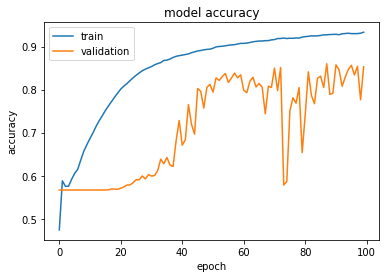

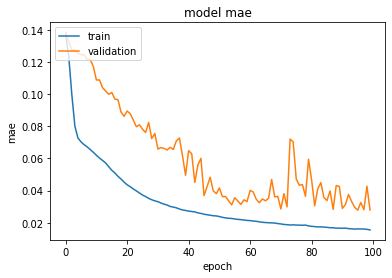

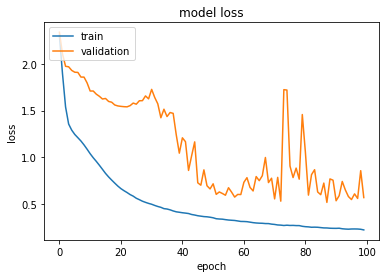

63/63 [==============================] - 2s 27ms/step - loss: 0.5914 - mae: 0.0286 - accuracy: 0.8487

Evaluation:
Loss, MAE, Accuracy [0.5913676619529724, 0.02856895700097084, 0.8486781120300293]
PSDS (0.027634819515419764, 'Valid file')

Filling post processing used.
PSDS (0.5970433783467003, 'Valid file')


/home/alex/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/alex/.local/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Submission file saved at ./challenge_submission.csv




Test Split: (2000, 4000)
Pipeline parameter: {'data_folder': './../data/', 'wav_files_folder': 'final_pre_dataset', 'window_length': 1024, 'window_overlap': 523, 'band_size': 4, 'sample_rate': 16000, 'dev_csv': 'dev-labels.csv', 'eval_csv': 'challenge_filelist_dummy.csv', 'scaling': 'standard', 'test_split_range': (2000, 4000), 'prediction_path': './', 'post_processing': 'fill', 'submission_file_path': './challenge_submission.csv'}
Model parameter: {'channels': [32, 64, 64], 'lessParameter': True, 'kernel_size': 3, 'first_kernel_size': 3, 'val_split_fraction': 0.2, 'loss': 'categorical_crossentropy', 'learning_rate': 0.001, 'batch_size': 512, 'epochs': 100, 'model_save_path': './', 'load_path': None}
Csv from wav files already existend. Skipping calc_fft.
Scaled numpy files already existend. Skipping scaling and load_data function.
Splitting test set at indices 2000 to 4000 from dev set.
Existing model.h5 removed.
Tensorflow versi


Epoch 00065: val_loss did not improve from 0.58730
Epoch 66/100
13/13 [==============================] - 21s 2s/step - loss: 0.2769 - mae: 0.0191 - accuracy: 0.9165 - val_loss: 0.9377 - val_mae: 0.0469 - val_accuracy: 0.7495

Epoch 00066: val_loss did not improve from 0.58730
Epoch 67/100
13/13 [==============================] - 21s 2s/step - loss: 0.2672 - mae: 0.0188 - accuracy: 0.9189 - val_loss: 0.7774 - val_mae: 0.0403 - val_accuracy: 0.7886

Epoch 00067: val_loss did not improve from 0.58730
Epoch 68/100
13/13 [==============================] - 22s 2s/step - loss: 0.2641 - mae: 0.0185 - accuracy: 0.9202 - val_loss: 1.2814 - val_mae: 0.0582 - val_accuracy: 0.6770

Epoch 00068: val_loss did not improve from 0.58730
Epoch 69/100
13/13 [==============================] - 23s 2s/step - loss: 0.2679 - mae: 0.0188 - accuracy: 0.9188 - val_loss: 0.6964 - val_mae: 0.0380 - val_accuracy: 0.8076

Epoch 00069: val_loss did not improve from 0.58730
Epoch 70/100
13/13 [========================

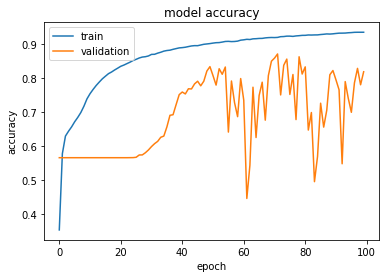

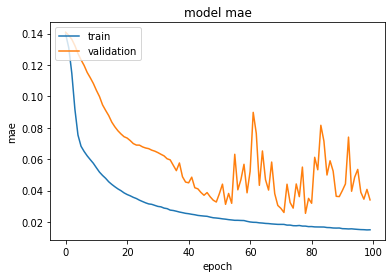

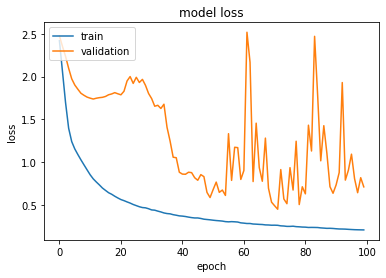

63/63 [==============================] - 2s 24ms/step - loss: 0.7106 - mae: 0.0342 - accuracy: 0.8198

Evaluation:
Loss, MAE, Accuracy [0.7105758190155029, 0.03417971357703209, 0.8197749853134155]
PSDS (0.06848149409773133, 'Valid file')

Filling post processing used.
PSDS (0.5683764427530419, 'Valid file')


/home/alex/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/alex/.local/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Submission file saved at ./challenge_submission.csv




Test Split: (4000, 6000)
Pipeline parameter: {'data_folder': './../data/', 'wav_files_folder': 'final_pre_dataset', 'window_length': 1024, 'window_overlap': 523, 'band_size': 4, 'sample_rate': 16000, 'dev_csv': 'dev-labels.csv', 'eval_csv': 'challenge_filelist_dummy.csv', 'scaling': 'standard', 'test_split_range': (4000, 6000), 'prediction_path': './', 'post_processing': 'fill', 'submission_file_path': './challenge_submission.csv'}
Model parameter: {'channels': [32, 64, 64], 'lessParameter': True, 'kernel_size': 3, 'first_kernel_size': 3, 'val_split_fraction': 0.2, 'loss': 'categorical_crossentropy', 'learning_rate': 0.001, 'batch_size': 512, 'epochs': 100, 'model_save_path': './', 'load_path': None}
Csv from wav files already existend. Skipping calc_fft.
Scaled numpy files already existend. Skipping scaling and load_data function.
Splitting test set at indices 4000 to 6000 from dev set.
Existing model.h5 removed.
Tensorflow versi

13/13 [==============================] - 24s 2s/step - loss: 0.2700 - mae: 0.0187 - accuracy: 0.9187 - val_loss: 0.5422 - val_mae: 0.0299 - val_accuracy: 0.8481

Epoch 00064: val_loss did not improve from 0.53635
Epoch 65/100
13/13 [==============================] - 23s 2s/step - loss: 0.2675 - mae: 0.0186 - accuracy: 0.9195 - val_loss: 0.5397 - val_mae: 0.0290 - val_accuracy: 0.8516

Epoch 00065: val_loss did not improve from 0.53635
Epoch 66/100
13/13 [==============================] - 22s 2s/step - loss: 0.2664 - mae: 0.0184 - accuracy: 0.9198 - val_loss: 0.5072 - val_mae: 0.0279 - val_accuracy: 0.8593

Epoch 00066: val_loss improved from 0.53635 to 0.50717, saving model to model.h5
Epoch 67/100
13/13 [==============================] - 23s 2s/step - loss: 0.2643 - mae: 0.0182 - accuracy: 0.9206 - val_loss: 0.5563 - val_mae: 0.0294 - val_accuracy: 0.8462

Epoch 00067: val_loss did not improve from 0.50717
Epoch 68/100
13/13 [==============================] - 24s 2s/step - loss: 0.258

13/13 [==============================] - 20s 2s/step - loss: 0.2011 - mae: 0.0144 - accuracy: 0.9384 - val_loss: 0.5265 - val_mae: 0.0255 - val_accuracy: 0.8647

Epoch 00100: val_loss did not improve from 0.48983
INFO:tensorflow:Assets written to: ./model/assets


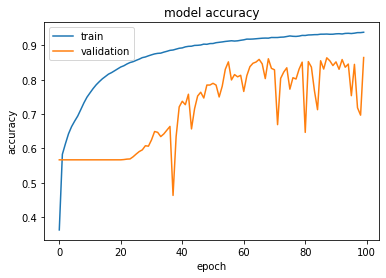

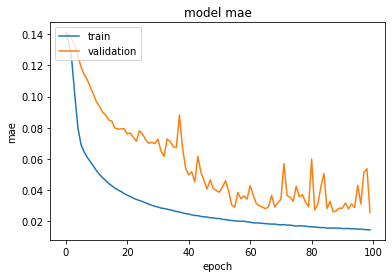

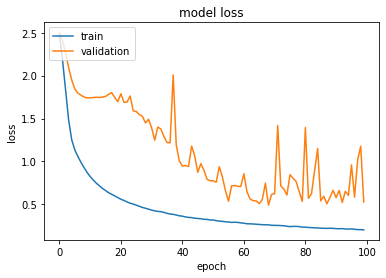

63/63 [==============================] - 2s 25ms/step - loss: 0.5415 - mae: 0.0258 - accuracy: 0.8628

Evaluation:
Loss, MAE, Accuracy [0.5415176749229431, 0.025767510756850243, 0.8628265857696533]
PSDS (0.12301736301718975, 'Valid file')

Filling post processing used.
PSDS (0.6447362392078617, 'Valid file')


/home/alex/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/alex/.local/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Submission file saved at ./challenge_submission.csv




Test Split: (6000, 8000)
Pipeline parameter: {'data_folder': './../data/', 'wav_files_folder': 'final_pre_dataset', 'window_length': 1024, 'window_overlap': 523, 'band_size': 4, 'sample_rate': 16000, 'dev_csv': 'dev-labels.csv', 'eval_csv': 'challenge_filelist_dummy.csv', 'scaling': 'standard', 'test_split_range': (6000, 8000), 'prediction_path': './', 'post_processing': 'fill', 'submission_file_path': './challenge_submission.csv'}
Model parameter: {'channels': [32, 64, 64], 'lessParameter': True, 'kernel_size': 3, 'first_kernel_size': 3, 'val_split_fraction': 0.2, 'loss': 'categorical_crossentropy', 'learning_rate': 0.001, 'batch_size': 512, 'epochs': 100, 'model_save_path': './', 'load_path': None}
Csv from wav files already existend. Skipping calc_fft.
Scaled numpy files already existend. Skipping scaling and load_data function.
Splitting test set at indices 6000 to 8000 from dev set.
Existing model.h5 removed.
Tensorflow versi

13/13 [==============================] - 20s 2s/step - loss: 0.4413 - mae: 0.0302 - accuracy: 0.8692 - val_loss: 1.4484 - val_mae: 0.0761 - val_accuracy: 0.5882

Epoch 00030: val_loss improved from 1.44961 to 1.44840, saving model to model.h5
Epoch 31/100
13/13 [==============================] - 20s 2s/step - loss: 0.4385 - mae: 0.0297 - accuracy: 0.8693 - val_loss: 1.3038 - val_mae: 0.0688 - val_accuracy: 0.6143

Epoch 00031: val_loss improved from 1.44840 to 1.30378, saving model to model.h5
Epoch 32/100
13/13 [==============================] - 20s 2s/step - loss: 0.4267 - mae: 0.0291 - accuracy: 0.8735 - val_loss: 1.2744 - val_mae: 0.0701 - val_accuracy: 0.6273

Epoch 00032: val_loss improved from 1.30378 to 1.27441, saving model to model.h5
Epoch 33/100
13/13 [==============================] - 20s 2s/step - loss: 0.4208 - mae: 0.0285 - accuracy: 0.8749 - val_loss: 1.2065 - val_mae: 0.0643 - val_accuracy: 0.6579

Epoch 00033: val_loss improved from 1.27441 to 1.20648, saving model t

13/13 [==============================] - 21s 2s/step - loss: 0.2087 - mae: 0.0150 - accuracy: 0.9363 - val_loss: 0.6029 - val_mae: 0.0315 - val_accuracy: 0.8427

Epoch 00100: val_loss did not improve from 0.47947
INFO:tensorflow:Assets written to: ./model/assets


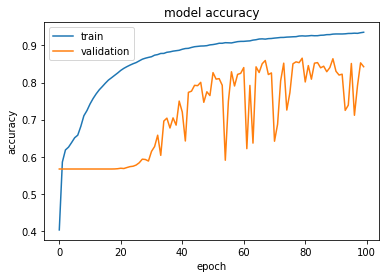

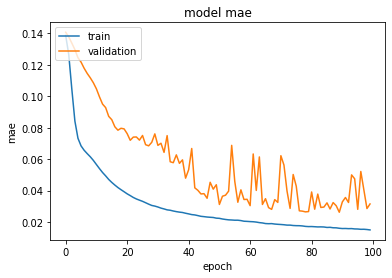

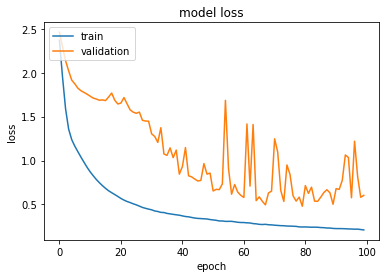

63/63 [==============================] - 2s 24ms/step - loss: 0.6026 - mae: 0.0313 - accuracy: 0.8450

Evaluation:
Loss, MAE, Accuracy [0.6025996208190918, 0.03125949576497078, 0.8449843525886536]
PSDS (0.051099317094516865, 'Valid file')

Filling post processing used.
PSDS (0.6247790570779969, 'Valid file')


/home/alex/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/alex/.local/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Submission file saved at ./challenge_submission.csv




Test Split: (8000, -1)
Pipeline parameter: {'data_folder': './../data/', 'wav_files_folder': 'final_pre_dataset', 'window_length': 1024, 'window_overlap': 523, 'band_size': 4, 'sample_rate': 16000, 'dev_csv': 'dev-labels.csv', 'eval_csv': 'challenge_filelist_dummy.csv', 'scaling': 'standard', 'test_split_range': (8000, -1), 'prediction_path': './', 'post_processing': 'fill', 'submission_file_path': './challenge_submission.csv'}
Model parameter: {'channels': [32, 64, 64], 'lessParameter': True, 'kernel_size': 3, 'first_kernel_size': 3, 'val_split_fraction': 0.2, 'loss': 'categorical_crossentropy', 'learning_rate': 0.001, 'batch_size': 512, 'epochs': 100, 'model_save_path': './', 'load_path': None}
Csv from wav files already existend. Skipping calc_fft.
Scaled numpy files already existend. Skipping scaling and load_data function.
Splitting test set at indices 8000 to -1 from dev set.
Existing model.h5 removed.
Tensorflow version: 2.

16/16 [==============================] - 25s 2s/step - loss: 0.2357 - mae: 0.0166 - accuracy: 0.9291 - val_loss: 0.5863 - val_mae: 0.0301 - val_accuracy: 0.8403

Epoch 00065: val_loss did not improve from 0.50233
Epoch 66/100
16/16 [==============================] - 25s 2s/step - loss: 0.2339 - mae: 0.0163 - accuracy: 0.9290 - val_loss: 1.1283 - val_mae: 0.0514 - val_accuracy: 0.7100

Epoch 00066: val_loss did not improve from 0.50233
Epoch 67/100
16/16 [==============================] - 25s 2s/step - loss: 0.2347 - mae: 0.0165 - accuracy: 0.9291 - val_loss: 0.5872 - val_mae: 0.0320 - val_accuracy: 0.8347

Epoch 00067: val_loss did not improve from 0.50233
Epoch 68/100
16/16 [==============================] - 25s 2s/step - loss: 0.2314 - mae: 0.0163 - accuracy: 0.9300 - val_loss: 0.6499 - val_mae: 0.0348 - val_accuracy: 0.8212

Epoch 00068: val_loss did not improve from 0.50233
Epoch 69/100
16/16 [==============================] - 24s 2s/step - loss: 0.2275 - mae: 0.0161 - accuracy: 0.

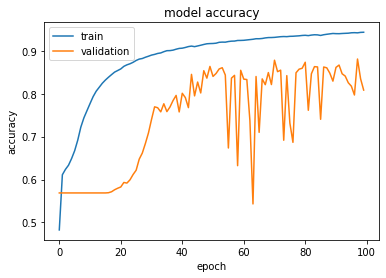

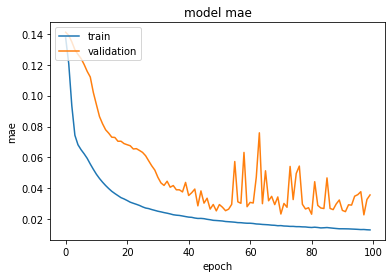

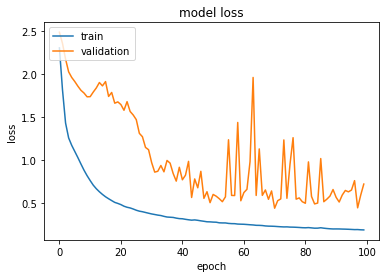

63/63 [==============================] - 2s 25ms/step - loss: 0.7188 - mae: 0.0357 - accuracy: 0.8086

Evaluation:
Loss, MAE, Accuracy [0.7188223600387573, 0.03573137894272804, 0.8086434006690979]
PSDS (0.0025107704251143403, 'Valid file')

Filling post processing used.
PSDS (0.6036907598937771, 'Valid file')


/home/alex/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/alex/.local/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Submission file saved at ./challenge_submission.csv




Cross validation summary:
Loss  [0.5913676619529724, 0.7105758190155029, 0.5415176749229431, 0.6025996208190918, 0.7188223600387573]
Mean Loss 0.6329766273498535

MAE [0.02856895700097084, 0.03417971357703209, 0.025767510756850243, 0.03125949576497078, 0.03573137894272804]
Mean MAE 0.0311014112085104

Accuracy [0.8486781120300293, 0.8197749853134155, 0.8628265857696533, 0.8449843525886536, 0.8086434006690979]
Mean Accuracy 0.8369814872741699

Model PSDS [0.027634819515419764, 0.06848149409773133, 0.12301736301718975, 0.051099317094516865, 0.0025107704251143403]
Mean model PSDS 0.054548752829994405

Post processed PSDS [0.5970433783467003, 0.5683764427530419, 0.6447362392078617, 0.6247790570779969, 0.6036907598937771]
Mean Post processed PSDS 0.6077251754558756


In [7]:
# crossval scaling standard, channel 32 64 64
pipe_param = {'data_folder': './../data/',
                  'wav_files_folder': 'final_pre_dataset', # fft parameter
                  'window_length': 1024, 'window_overlap': 523,
                  'band_size': 4, 'sample_rate': 16000,
                  'dev_csv': 'dev-labels.csv', # filelisten, falls man doch auf kleinerem probieren moechte
                  'eval_csv': 'challenge_filelist_dummy.csv',
                  'scaling': 'standard', # 'standard', 'minmax' oder 'no' wenn kein scaling sein soll
                  'test_split_range': (8000, -1), # index anfang und ende aus dev set 
                  'prediction_path': './', # wo prediction csvs gespeichert werden sollen
                  'post_processing': 'fill', # 'fill' is das von Jannes
                  'submission_file_path': './challenge_submission.csv'}
unet_param = {'channels': [32, 64, 64],
              'lessParameter': True,
              'kernel_size': 3,
              'first_kernel_size': 3,
              'val_split_fraction': 0.2, # 1/9 damit man 1000 von den 9000 abzweigt
              'loss': 'categorical_crossentropy', # bbdc.dice_loss moeglich
              'learning_rate': 0.001,
              'batch_size': 512,
              'epochs': 100,
              'model_save_path': './',
              'load_path': None} # Wenn trainiert werden soll: None; Submission 1: 'model9561.h5'
test_index_list = [(0, 2000), (2000, 4000), (4000, 6000), (6000, 8000), (8000,  -1)]
cross_val(pipeline_u_net_1, pipe_param, unet_param, test_index_list)

Test Split: (0, 2000)
Pipeline parameter: {'data_folder': './../data/', 'wav_files_folder': 'final_pre_dataset', 'window_length': 1024, 'window_overlap': 523, 'band_size': 4, 'sample_rate': 16000, 'dev_csv': 'dev-labels.csv', 'eval_csv': 'challenge_filelist_dummy.csv', 'scaling': 'minmax', 'test_split_range': (0, 2000), 'prediction_path': './', 'post_processing': 'fill', 'submission_file_path': './challenge_submission.csv'}
Model parameter: {'channels': [32, 64, 64], 'lessParameter': True, 'kernel_size': 3, 'first_kernel_size': 3, 'val_split_fraction': 0.2, 'loss': 'categorical_crossentropy', 'learning_rate': 0.001, 'batch_size': 512, 'epochs': 100, 'model_save_path': './', 'load_path': None}
Csv from wav files already existend. Skipping calc_fft.
Scaled numpy files already existend. Skipping scaling and load_data function.
Splitting test set at indices 0 to 2000 from dev set.
Tensorflow version: 2.4.1
Epoch 1/100
13/13 [==============================] - 36s 2s/step - loss: 2.5739 - ma

13/13 [==============================] - 20s 2s/step - loss: 0.2604 - mae: 0.0181 - accuracy: 0.9216 - val_loss: 0.7645 - val_mae: 0.0388 - val_accuracy: 0.7902

Epoch 00065: val_loss did not improve from 0.56424
Epoch 66/100
13/13 [==============================] - 19s 1s/step - loss: 0.2633 - mae: 0.0181 - accuracy: 0.9204 - val_loss: 0.8341 - val_mae: 0.0409 - val_accuracy: 0.7771

Epoch 00066: val_loss did not improve from 0.56424
Epoch 67/100
13/13 [==============================] - 20s 2s/step - loss: 0.2499 - mae: 0.0175 - accuracy: 0.9246 - val_loss: 1.1851 - val_mae: 0.0562 - val_accuracy: 0.6730

Epoch 00067: val_loss did not improve from 0.56424
Epoch 68/100
13/13 [==============================] - 19s 1s/step - loss: 0.2505 - mae: 0.0173 - accuracy: 0.9243 - val_loss: 1.0415 - val_mae: 0.0510 - val_accuracy: 0.7153

Epoch 00068: val_loss did not improve from 0.56424
Epoch 69/100
13/13 [==============================] - 25s 2s/step - loss: 0.2519 - mae: 0.0177 - accuracy: 0.

INFO:tensorflow:Assets written to: ./model/assets


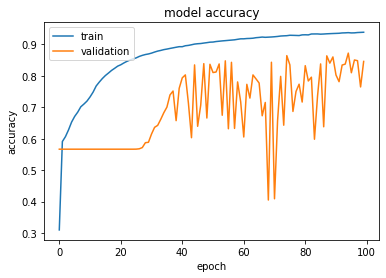

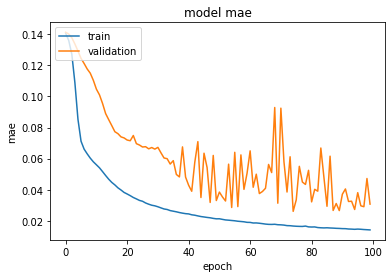

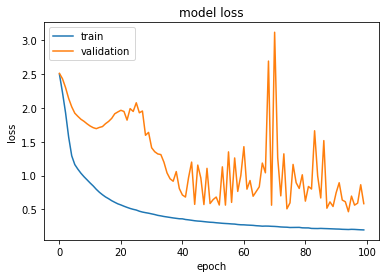

63/63 [==============================] - 2s 30ms/step - loss: 0.5984 - mae: 0.0312 - accuracy: 0.8444

Evaluation:
Loss, MAE, Accuracy [0.5984216332435608, 0.031167572364211082, 0.8443593978881836]
PSDS (0.05202495248491974, 'Valid file')

Filling post processing used.
PSDS (0.6259544131708276, 'Valid file')


/home/alex/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/alex/.local/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Submission file saved at ./challenge_submission.csv




Test Split: (2000, 4000)
Pipeline parameter: {'data_folder': './../data/', 'wav_files_folder': 'final_pre_dataset', 'window_length': 1024, 'window_overlap': 523, 'band_size': 4, 'sample_rate': 16000, 'dev_csv': 'dev-labels.csv', 'eval_csv': 'challenge_filelist_dummy.csv', 'scaling': 'minmax', 'test_split_range': (2000, 4000), 'prediction_path': './', 'post_processing': 'fill', 'submission_file_path': './challenge_submission.csv'}
Model parameter: {'channels': [32, 64, 64], 'lessParameter': True, 'kernel_size': 3, 'first_kernel_size': 3, 'val_split_fraction': 0.2, 'loss': 'categorical_crossentropy', 'learning_rate': 0.001, 'batch_size': 512, 'epochs': 100, 'model_save_path': './', 'load_path': None}
Csv from wav files already existend. Skipping calc_fft.
Scaled numpy files already existend. Skipping scaling and load_data function.
Splitting test set at indices 2000 to 4000 from dev set.
Existing model.h5 removed.
Tensorflow version

13/13 [==============================] - 20s 2s/step - loss: 0.2803 - mae: 0.0197 - accuracy: 0.9142 - val_loss: 0.5922 - val_mae: 0.0333 - val_accuracy: 0.8342

Epoch 00064: val_loss did not improve from 0.52047
Epoch 65/100
13/13 [==============================] - 20s 2s/step - loss: 0.2752 - mae: 0.0192 - accuracy: 0.9162 - val_loss: 0.6991 - val_mae: 0.0356 - val_accuracy: 0.8148

Epoch 00065: val_loss did not improve from 0.52047
Epoch 66/100
13/13 [==============================] - 20s 2s/step - loss: 0.2737 - mae: 0.0192 - accuracy: 0.9163 - val_loss: 0.7237 - val_mae: 0.0364 - val_accuracy: 0.8086

Epoch 00066: val_loss did not improve from 0.52047
Epoch 67/100
13/13 [==============================] - 20s 2s/step - loss: 0.2693 - mae: 0.0189 - accuracy: 0.9175 - val_loss: 0.5402 - val_mae: 0.0287 - val_accuracy: 0.8498

Epoch 00067: val_loss did not improve from 0.52047
Epoch 68/100
13/13 [==============================] - 20s 2s/step - loss: 0.2660 - mae: 0.0187 - accuracy: 0.

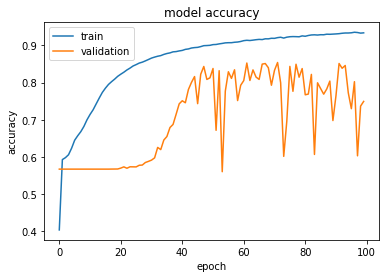

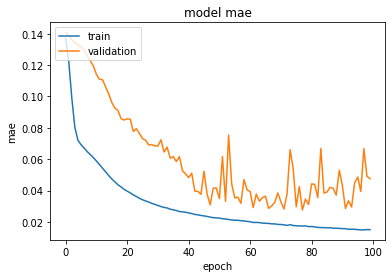

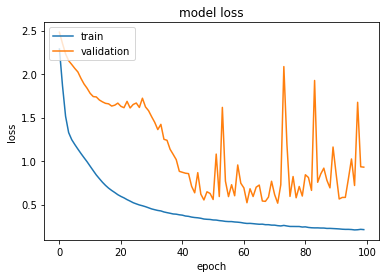

63/63 [==============================] - 2s 24ms/step - loss: 0.9419 - mae: 0.0485 - accuracy: 0.7432

Evaluation:
Loss, MAE, Accuracy [0.9418932199478149, 0.04852871224284172, 0.7431530952453613]
PSDS (0.007248391931555607, 'Valid file')

Filling post processing used.
PSDS (0.4950695259265245, 'Valid file')


/home/alex/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/alex/.local/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Submission file saved at ./challenge_submission.csv




Test Split: (4000, 6000)
Pipeline parameter: {'data_folder': './../data/', 'wav_files_folder': 'final_pre_dataset', 'window_length': 1024, 'window_overlap': 523, 'band_size': 4, 'sample_rate': 16000, 'dev_csv': 'dev-labels.csv', 'eval_csv': 'challenge_filelist_dummy.csv', 'scaling': 'minmax', 'test_split_range': (4000, 6000), 'prediction_path': './', 'post_processing': 'fill', 'submission_file_path': './challenge_submission.csv'}
Model parameter: {'channels': [32, 64, 64], 'lessParameter': True, 'kernel_size': 3, 'first_kernel_size': 3, 'val_split_fraction': 0.2, 'loss': 'categorical_crossentropy', 'learning_rate': 0.001, 'batch_size': 512, 'epochs': 100, 'model_save_path': './', 'load_path': None}
Csv from wav files already existend. Skipping calc_fft.
Scaled numpy files already existend. Skipping scaling and load_data function.
Splitting test set at indices 4000 to 6000 from dev set.
Existing model.h5 removed.
Tensorflow version

13/13 [==============================] - 22s 2s/step - loss: 0.2615 - mae: 0.0181 - accuracy: 0.9218 - val_loss: 0.6928 - val_mae: 0.0376 - val_accuracy: 0.8020

Epoch 00064: val_loss did not improve from 0.51460
Epoch 65/100
13/13 [==============================] - 22s 2s/step - loss: 0.2603 - mae: 0.0180 - accuracy: 0.9222 - val_loss: 0.5590 - val_mae: 0.0297 - val_accuracy: 0.8468

Epoch 00065: val_loss did not improve from 0.51460
Epoch 66/100
13/13 [==============================] - 27s 2s/step - loss: 0.2602 - mae: 0.0179 - accuracy: 0.9224 - val_loss: 0.5156 - val_mae: 0.0272 - val_accuracy: 0.8607

Epoch 00066: val_loss did not improve from 0.51460
Epoch 67/100
13/13 [==============================] - 21s 2s/step - loss: 0.2563 - mae: 0.0177 - accuracy: 0.9229 - val_loss: 0.6887 - val_mae: 0.0336 - val_accuracy: 0.8193

Epoch 00067: val_loss did not improve from 0.51460
Epoch 68/100
13/13 [==============================] - 21s 2s/step - loss: 0.2532 - mae: 0.0176 - accuracy: 0.

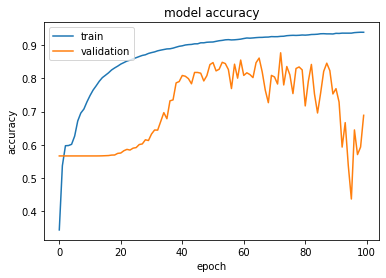

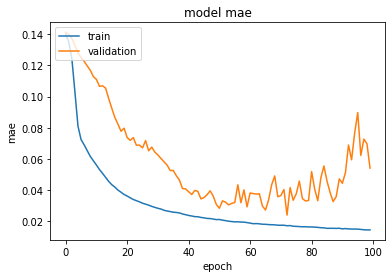

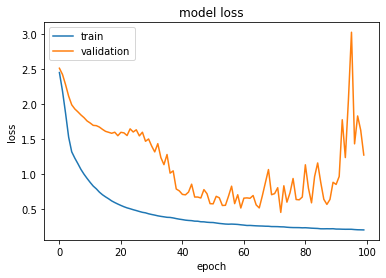

63/63 [==============================] - 2s 27ms/step - loss: 1.3243 - mae: 0.0564 - accuracy: 0.6740

Evaluation:
Loss, MAE, Accuracy [1.324346899986267, 0.056380853056907654, 0.6739875078201294]
PSDS (0.0, 'Valid file')

Filling post processing used.
PSDS (0.3527831711857503, 'Valid file')


/home/alex/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/alex/.local/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Submission file saved at ./challenge_submission.csv




Test Split: (6000, 8000)
Pipeline parameter: {'data_folder': './../data/', 'wav_files_folder': 'final_pre_dataset', 'window_length': 1024, 'window_overlap': 523, 'band_size': 4, 'sample_rate': 16000, 'dev_csv': 'dev-labels.csv', 'eval_csv': 'challenge_filelist_dummy.csv', 'scaling': 'minmax', 'test_split_range': (6000, 8000), 'prediction_path': './', 'post_processing': 'fill', 'submission_file_path': './challenge_submission.csv'}
Model parameter: {'channels': [32, 64, 64], 'lessParameter': True, 'kernel_size': 3, 'first_kernel_size': 3, 'val_split_fraction': 0.2, 'loss': 'categorical_crossentropy', 'learning_rate': 0.001, 'batch_size': 512, 'epochs': 100, 'model_save_path': './', 'load_path': None}
Csv from wav files already existend. Skipping calc_fft.
Scaled numpy files already existend. Skipping scaling and load_data function.
Splitting test set at indices 6000 to 8000 from dev set.
Existing model.h5 removed.
Tensorflow version


Epoch 00030: val_loss did not improve from 1.62210
Epoch 31/100
13/13 [==============================] - 22s 2s/step - loss: 0.4471 - mae: 0.0303 - accuracy: 0.8671 - val_loss: 1.5842 - val_mae: 0.0729 - val_accuracy: 0.5850

Epoch 00031: val_loss improved from 1.62210 to 1.58419, saving model to model.h5
Epoch 32/100
13/13 [==============================] - 21s 2s/step - loss: 0.4383 - mae: 0.0299 - accuracy: 0.8699 - val_loss: 1.5211 - val_mae: 0.0711 - val_accuracy: 0.5893

Epoch 00032: val_loss improved from 1.58419 to 1.52115, saving model to model.h5
Epoch 33/100
13/13 [==============================] - 22s 2s/step - loss: 0.4314 - mae: 0.0293 - accuracy: 0.8711 - val_loss: 1.4359 - val_mae: 0.0674 - val_accuracy: 0.6059

Epoch 00033: val_loss improved from 1.52115 to 1.43587, saving model to model.h5
Epoch 34/100
13/13 [==============================] - 21s 2s/step - loss: 0.4249 - mae: 0.0288 - accuracy: 0.8731 - val_loss: 1.4563 - val_mae: 0.0802 - val_accuracy: 0.6130

Epoch


Epoch 00064: val_loss did not improve from 0.48084
Epoch 65/100
13/13 [==============================] - 21s 2s/step - loss: 0.2757 - mae: 0.0192 - accuracy: 0.9158 - val_loss: 0.8022 - val_mae: 0.0447 - val_accuracy: 0.7731

Epoch 00065: val_loss did not improve from 0.48084
Epoch 66/100
13/13 [==============================] - 20s 2s/step - loss: 0.2686 - mae: 0.0188 - accuracy: 0.9180 - val_loss: 0.7869 - val_mae: 0.0434 - val_accuracy: 0.7721

Epoch 00066: val_loss did not improve from 0.48084
Epoch 67/100
13/13 [==============================] - 20s 2s/step - loss: 0.2723 - mae: 0.0191 - accuracy: 0.9169 - val_loss: 0.6320 - val_mae: 0.0344 - val_accuracy: 0.8228

Epoch 00067: val_loss did not improve from 0.48084
Epoch 68/100
13/13 [==============================] - 20s 2s/step - loss: 0.2663 - mae: 0.0187 - accuracy: 0.9192 - val_loss: 0.6474 - val_mae: 0.0345 - val_accuracy: 0.8218

Epoch 00068: val_loss did not improve from 0.48084
Epoch 69/100
13/13 [========================

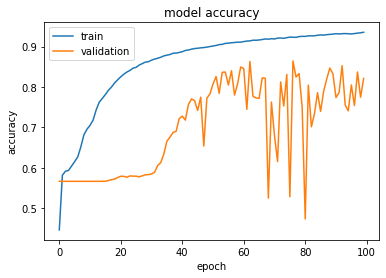

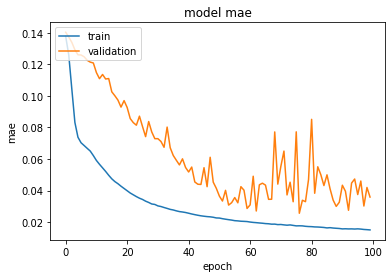

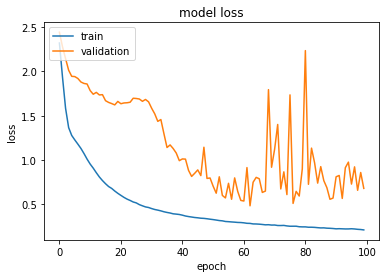

63/63 [==============================] - 2s 26ms/step - loss: 0.6822 - mae: 0.0360 - accuracy: 0.8203

Evaluation:
Loss, MAE, Accuracy [0.6822109818458557, 0.036030132323503494, 0.8202609419822693]
PSDS (0.033550230963788834, 'Valid file')

Filling post processing used.
PSDS (0.5873164061528767, 'Valid file')


/home/alex/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/alex/.local/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Submission file saved at ./challenge_submission.csv




Test Split: (8000, -1)
Pipeline parameter: {'data_folder': './../data/', 'wav_files_folder': 'final_pre_dataset', 'window_length': 1024, 'window_overlap': 523, 'band_size': 4, 'sample_rate': 16000, 'dev_csv': 'dev-labels.csv', 'eval_csv': 'challenge_filelist_dummy.csv', 'scaling': 'minmax', 'test_split_range': (8000, -1), 'prediction_path': './', 'post_processing': 'fill', 'submission_file_path': './challenge_submission.csv'}
Model parameter: {'channels': [32, 64, 64], 'lessParameter': True, 'kernel_size': 3, 'first_kernel_size': 3, 'val_split_fraction': 0.2, 'loss': 'categorical_crossentropy', 'learning_rate': 0.001, 'batch_size': 512, 'epochs': 100, 'model_save_path': './', 'load_path': None}
Csv from wav files already existend. Skipping calc_fft.
Scaled numpy files already existend. Skipping scaling and load_data function.
Splitting test set at indices 8000 to -1 from dev set.
Existing model.h5 removed.
Tensorflow version: 2.4.

16/16 [==============================] - 25s 2s/step - loss: 0.3888 - mae: 0.0264 - accuracy: 0.8844 - val_loss: 1.1286 - val_mae: 0.0543 - val_accuracy: 0.7065

Epoch 00031: val_loss improved from 1.15554 to 1.12855, saving model to model.h5
Epoch 32/100
16/16 [==============================] - 25s 2s/step - loss: 0.3812 - mae: 0.0258 - accuracy: 0.8867 - val_loss: 1.0326 - val_mae: 0.0536 - val_accuracy: 0.7253

Epoch 00032: val_loss improved from 1.12855 to 1.03263, saving model to model.h5
Epoch 33/100
16/16 [==============================] - 25s 2s/step - loss: 0.3774 - mae: 0.0257 - accuracy: 0.8880 - val_loss: 0.8760 - val_mae: 0.0442 - val_accuracy: 0.7625

Epoch 00033: val_loss improved from 1.03263 to 0.87603, saving model to model.h5
Epoch 34/100
16/16 [==============================] - 26s 2s/step - loss: 0.3672 - mae: 0.0250 - accuracy: 0.8904 - val_loss: 0.9772 - val_mae: 0.0555 - val_accuracy: 0.7281

Epoch 00034: val_loss did not improve from 0.87603
Epoch 35/100
16/16 

16/16 [==============================] - 25s 2s/step - loss: 0.2500 - mae: 0.0175 - accuracy: 0.9235 - val_loss: 0.8657 - val_mae: 0.0350 - val_accuracy: 0.8010

Epoch 00066: val_loss did not improve from 0.48067
Epoch 67/100
16/16 [==============================] - 25s 2s/step - loss: 0.2470 - mae: 0.0174 - accuracy: 0.9246 - val_loss: 0.4528 - val_mae: 0.0249 - val_accuracy: 0.8734

Epoch 00067: val_loss improved from 0.48067 to 0.45276, saving model to model.h5
Epoch 68/100
16/16 [==============================] - 26s 2s/step - loss: 0.2411 - mae: 0.0170 - accuracy: 0.9267 - val_loss: 1.3065 - val_mae: 0.0597 - val_accuracy: 0.6584

Epoch 00068: val_loss did not improve from 0.45276
Epoch 69/100
16/16 [==============================] - 26s 2s/step - loss: 0.2403 - mae: 0.0170 - accuracy: 0.9271 - val_loss: 0.4699 - val_mae: 0.0290 - val_accuracy: 0.8650

Epoch 00069: val_loss did not improve from 0.45276
Epoch 70/100
16/16 [==============================] - 26s 2s/step - loss: 0.233

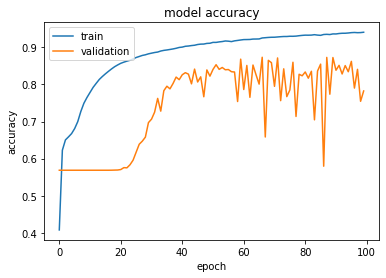

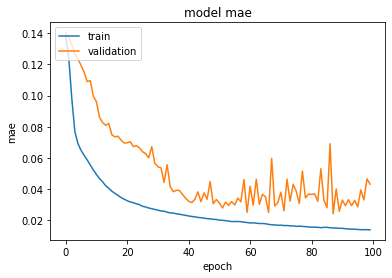

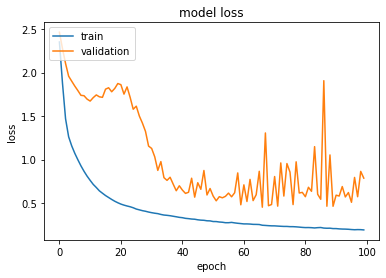

63/63 [==============================] - 2s 24ms/step - loss: 0.7870 - mae: 0.0431 - accuracy: 0.7825

Evaluation:
Loss, MAE, Accuracy [0.7870132327079773, 0.04310602322220802, 0.7825006246566772]
PSDS (0.0, 'Valid file')

Filling post processing used.
PSDS (0.5162132819548166, 'Valid file')


/home/alex/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/alex/.local/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Submission file saved at ./challenge_submission.csv




Cross validation summary:
Loss  [0.5984216332435608, 0.9418932199478149, 1.324346899986267, 0.6822109818458557, 0.7870132327079773]
Mean Loss 0.8667771935462951

MAE [0.031167572364211082, 0.04852871224284172, 0.056380853056907654, 0.036030132323503494, 0.04310602322220802]
Mean MAE 0.04304265864193439

Accuracy [0.8443593978881836, 0.7431530952453613, 0.6739875078201294, 0.8202609419822693, 0.7825006246566772]
Mean Accuracy 0.7728523135185241

Model PSDS [0.05202495248491974, 0.007248391931555607, 0.0, 0.033550230963788834, 0.0]
Mean model PSDS 0.018564715076052833

Post processed PSDS [0.6259544131708276, 0.4950695259265245, 0.3527831711857503, 0.5873164061528767, 0.5162132819548166]
Mean Post processed PSDS 0.5154673596781592


In [6]:
# crossval scaling minmax, channel 32 64 64
pipe_param = {'data_folder': './../data/',
                  'wav_files_folder': 'final_pre_dataset', # fft parameter
                  'window_length': 1024, 'window_overlap': 523,
                  'band_size': 4, 'sample_rate': 16000,
                  'dev_csv': 'dev-labels.csv', # filelisten, falls man doch auf kleinerem probieren moechte
                  'eval_csv': 'challenge_filelist_dummy.csv',
                  'scaling': 'minmax', # 'standard', 'minmax' oder 'no' wenn kein scaling sein soll
                  'test_split_range': (8000, -1), # index anfang und ende aus dev set 
                  'prediction_path': './', # wo prediction csvs gespeichert werden sollen
                  'post_processing': 'fill', # 'fill' is das von Jannes
                  'submission_file_path': './challenge_submission.csv'}
unet_param = {'channels': [32, 64, 64],
              'lessParameter': True,
              'kernel_size': 3,
              'first_kernel_size': 3,
              'val_split_fraction': 0.2, # 1/9 damit man 1000 von den 9000 abzweigt
              'loss': 'categorical_crossentropy', # bbdc.dice_loss moeglich
              'learning_rate': 0.001,
              'batch_size': 512,
              'epochs': 100,
              'model_save_path': './',
              'load_path': None} # Wenn trainiert werden soll: None; Submission 1: 'model9561.h5'
test_index_list = [(0, 2000), (2000, 4000), (4000, 6000), (6000, 8000), (8000,  -1)]
cross_val(pipeline_u_net_1, pipe_param, unet_param, test_index_list)

Test Split: (0, 2000)
Pipeline parameter: {'data_folder': './../data/', 'wav_files_folder': 'final_pre_dataset', 'window_length': 1024, 'window_overlap': 523, 'band_size': 4, 'sample_rate': 16000, 'dev_csv': 'dev-labels.csv', 'eval_csv': 'challenge_filelist_dummy.csv', 'scaling': 'standard', 'test_split_range': (0, 2000), 'prediction_path': './', 'post_processing': 'fill', 'submission_file_path': './challenge_submission.csv'}
Model parameter: {'channels': [32, 64, 64], 'lessParameter': True, 'kernel_size': 3, 'first_kernel_size': 3, 'val_split_fraction': 0.2, 'loss': 'categorical_crossentropy', 'learning_rate': 0.001, 'batch_size': 512, 'epochs': 200, 'model_save_path': './', 'load_path': None}
Csv from wav files already existend. Skipping calc_fft.
Scaled numpy files already existend. Skipping scaling and load_data function.
Splitting test set at indices 0 to 2000 from dev set.
Existing model.h5 removed.
Tensorflow version: 2.4.1
Epoch 1/200
13/13 [==============================] - 41

13/13 [==============================] - 24s 2s/step - loss: 0.2604 - mae: 0.0181 - accuracy: 0.9216 - val_loss: 0.7645 - val_mae: 0.0388 - val_accuracy: 0.7902

Epoch 00065: val_loss did not improve from 0.56424
Epoch 66/200
13/13 [==============================] - 24s 2s/step - loss: 0.2633 - mae: 0.0181 - accuracy: 0.9204 - val_loss: 0.8341 - val_mae: 0.0409 - val_accuracy: 0.7771

Epoch 00066: val_loss did not improve from 0.56424
Epoch 67/200
13/13 [==============================] - 24s 2s/step - loss: 0.2499 - mae: 0.0175 - accuracy: 0.9246 - val_loss: 1.1851 - val_mae: 0.0562 - val_accuracy: 0.6730

Epoch 00067: val_loss did not improve from 0.56424
Epoch 68/200
13/13 [==============================] - 24s 2s/step - loss: 0.2505 - mae: 0.0173 - accuracy: 0.9243 - val_loss: 1.0415 - val_mae: 0.0510 - val_accuracy: 0.7153

Epoch 00068: val_loss did not improve from 0.56424
Epoch 69/200
13/13 [==============================] - 23s 2s/step - loss: 0.2519 - mae: 0.0177 - accuracy: 0.

13/13 [==============================] - 24s 2s/step - loss: 0.1943 - mae: 0.0139 - accuracy: 0.9401 - val_loss: 0.6418 - val_mae: 0.0381 - val_accuracy: 0.8250

Epoch 00101: val_loss did not improve from 0.46672
Epoch 102/200
13/13 [==============================] - 24s 2s/step - loss: 0.1957 - mae: 0.0140 - accuracy: 0.9397 - val_loss: 0.7112 - val_mae: 0.0391 - val_accuracy: 0.8084

Epoch 00102: val_loss did not improve from 0.46672
Epoch 103/200
13/13 [==============================] - 24s 2s/step - loss: 0.1900 - mae: 0.0138 - accuracy: 0.9410 - val_loss: 0.6082 - val_mae: 0.0358 - val_accuracy: 0.8332

Epoch 00103: val_loss did not improve from 0.46672
Epoch 104/200
13/13 [==============================] - 25s 2s/step - loss: 0.1912 - mae: 0.0138 - accuracy: 0.9411 - val_loss: 1.2999 - val_mae: 0.0557 - val_accuracy: 0.6818

Epoch 00104: val_loss did not improve from 0.46672
Epoch 105/200
13/13 [==============================] - 25s 2s/step - loss: 0.1915 - mae: 0.0136 - accuracy

13/13 [==============================] - 24s 2s/step - loss: 0.1347 - mae: 0.0102 - accuracy: 0.9571 - val_loss: 1.8510 - val_mae: 0.0797 - val_accuracy: 0.5180

Epoch 00173: val_loss did not improve from 0.46672
Epoch 174/200
13/13 [==============================] - 25s 2s/step - loss: 0.1340 - mae: 0.0100 - accuracy: 0.9574 - val_loss: 1.3740 - val_mae: 0.0648 - val_accuracy: 0.6359

Epoch 00174: val_loss did not improve from 0.46672
Epoch 175/200
13/13 [==============================] - 26s 2s/step - loss: 0.1355 - mae: 0.0102 - accuracy: 0.9565 - val_loss: 2.0759 - val_mae: 0.0817 - val_accuracy: 0.5060

Epoch 00175: val_loss did not improve from 0.46672
Epoch 176/200
13/13 [==============================] - 25s 2s/step - loss: 0.1387 - mae: 0.0103 - accuracy: 0.9555 - val_loss: 1.7079 - val_mae: 0.0735 - val_accuracy: 0.5729

Epoch 00176: val_loss did not improve from 0.46672
Epoch 177/200
13/13 [==============================] - 24s 2s/step - loss: 0.1347 - mae: 0.0101 - accuracy

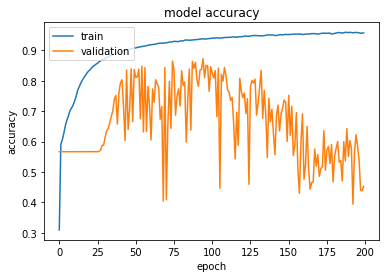

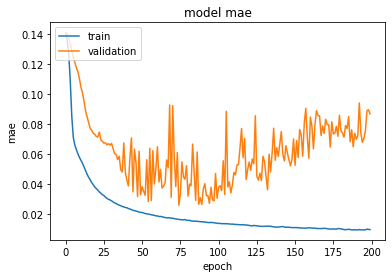

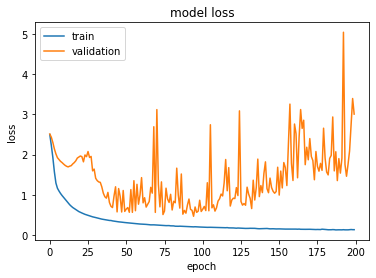

63/63 [==============================] - 2s 28ms/step - loss: 3.0496 - mae: 0.0882 - accuracy: 0.4454

Evaluation:
Loss, MAE, Accuracy [3.04956316947937, 0.08816570788621902, 0.44536250829696655]
PSDS (0.0, 'Valid file')

Filling post processing used.
PSDS (0.3176967877355642, 'Valid file')


/home/alex/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/alex/.local/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Submission file saved at ./challenge_submission.csv




Test Split: (2000, 4000)
Pipeline parameter: {'data_folder': './../data/', 'wav_files_folder': 'final_pre_dataset', 'window_length': 1024, 'window_overlap': 523, 'band_size': 4, 'sample_rate': 16000, 'dev_csv': 'dev-labels.csv', 'eval_csv': 'challenge_filelist_dummy.csv', 'scaling': 'standard', 'test_split_range': (2000, 4000), 'prediction_path': './', 'post_processing': 'fill', 'submission_file_path': './challenge_submission.csv'}
Model parameter: {'channels': [32, 64, 64], 'lessParameter': True, 'kernel_size': 3, 'first_kernel_size': 3, 'val_split_fraction': 0.2, 'loss': 'categorical_crossentropy', 'learning_rate': 0.001, 'batch_size': 512, 'epochs': 200, 'model_save_path': './', 'load_path': None}
Csv from wav files already existend. Skipping calc_fft.
Scaled numpy files already existend. Skipping scaling and load_data function.
Splitting test set at indices 2000 to 4000 from dev set.
Existing model.h5 removed.
Tensorflow versi

13/13 [==============================] - 22s 2s/step - loss: 0.4574 - mae: 0.0311 - accuracy: 0.8630 - val_loss: 1.5785 - val_mae: 0.0685 - val_accuracy: 0.5876

Epoch 00030: val_loss improved from 1.61009 to 1.57848, saving model to model.h5
Epoch 31/200
13/13 [==============================] - 22s 2s/step - loss: 0.4550 - mae: 0.0309 - accuracy: 0.8647 - val_loss: 1.5092 - val_mae: 0.0684 - val_accuracy: 0.5910

Epoch 00031: val_loss improved from 1.57848 to 1.50919, saving model to model.h5
Epoch 32/200
13/13 [==============================] - 23s 2s/step - loss: 0.4392 - mae: 0.0298 - accuracy: 0.8696 - val_loss: 1.4446 - val_mae: 0.0724 - val_accuracy: 0.5971

Epoch 00032: val_loss improved from 1.50919 to 1.44465, saving model to model.h5
Epoch 33/200
13/13 [==============================] - 23s 2s/step - loss: 0.4292 - mae: 0.0294 - accuracy: 0.8717 - val_loss: 1.3616 - val_mae: 0.0646 - val_accuracy: 0.6252

Epoch 00033: val_loss improved from 1.44465 to 1.36163, saving model t

13/13 [==============================] - 22s 2s/step - loss: 0.2803 - mae: 0.0197 - accuracy: 0.9142 - val_loss: 0.5922 - val_mae: 0.0333 - val_accuracy: 0.8342

Epoch 00064: val_loss did not improve from 0.52047
Epoch 65/200
13/13 [==============================] - 22s 2s/step - loss: 0.2752 - mae: 0.0192 - accuracy: 0.9162 - val_loss: 0.6991 - val_mae: 0.0356 - val_accuracy: 0.8148

Epoch 00065: val_loss did not improve from 0.52047
Epoch 66/200
13/13 [==============================] - 29s 2s/step - loss: 0.2737 - mae: 0.0192 - accuracy: 0.9163 - val_loss: 0.7237 - val_mae: 0.0364 - val_accuracy: 0.8086

Epoch 00066: val_loss did not improve from 0.52047
Epoch 67/200
13/13 [==============================] - 27s 2s/step - loss: 0.2693 - mae: 0.0189 - accuracy: 0.9175 - val_loss: 0.5402 - val_mae: 0.0287 - val_accuracy: 0.8498

Epoch 00067: val_loss did not improve from 0.52047
Epoch 68/200
13/13 [==============================] - 26s 2s/step - loss: 0.2660 - mae: 0.0187 - accuracy: 0.

13/13 [==============================] - 20s 2s/step - loss: 0.1632 - mae: 0.0120 - accuracy: 0.9488 - val_loss: 0.6282 - val_mae: 0.0337 - val_accuracy: 0.8370

Epoch 00136: val_loss did not improve from 0.50193
Epoch 137/200
13/13 [==============================] - 20s 2s/step - loss: 0.1637 - mae: 0.0122 - accuracy: 0.9487 - val_loss: 1.6756 - val_mae: 0.0651 - val_accuracy: 0.6182

Epoch 00137: val_loss did not improve from 0.50193
Epoch 138/200
13/13 [==============================] - 19s 1s/step - loss: 0.1683 - mae: 0.0123 - accuracy: 0.9475 - val_loss: 2.3558 - val_mae: 0.0752 - val_accuracy: 0.5424

Epoch 00138: val_loss did not improve from 0.50193
Epoch 139/200
13/13 [==============================] - 19s 2s/step - loss: 0.1649 - mae: 0.0120 - accuracy: 0.9482 - val_loss: 0.7878 - val_mae: 0.0402 - val_accuracy: 0.8016

Epoch 00139: val_loss did not improve from 0.50193
Epoch 140/200
13/13 [==============================] - 19s 1s/step - loss: 0.1717 - mae: 0.0124 - accuracy

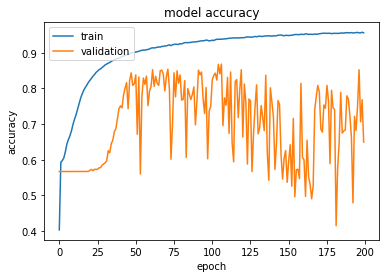

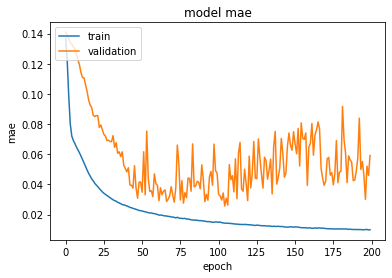

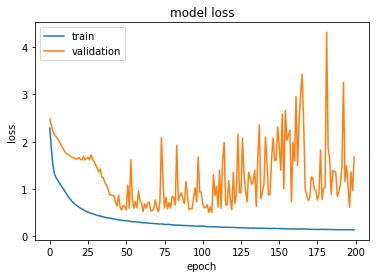

63/63 [==============================] - 2s 36ms/step - loss: 1.6695 - mae: 0.0596 - accuracy: 0.6473

Evaluation:
Loss, MAE, Accuracy [1.6695154905319214, 0.05962561070919037, 0.6472765803337097]
PSDS (0.012827478376580175, 'Valid file')

Filling post processing used.
PSDS (0.4015227221653089, 'Valid file')


/home/alex/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/alex/.local/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Submission file saved at ./challenge_submission.csv




Test Split: (4000, 6000)
Pipeline parameter: {'data_folder': './../data/', 'wav_files_folder': 'final_pre_dataset', 'window_length': 1024, 'window_overlap': 523, 'band_size': 4, 'sample_rate': 16000, 'dev_csv': 'dev-labels.csv', 'eval_csv': 'challenge_filelist_dummy.csv', 'scaling': 'standard', 'test_split_range': (4000, 6000), 'prediction_path': './', 'post_processing': 'fill', 'submission_file_path': './challenge_submission.csv'}
Model parameter: {'channels': [32, 64, 64], 'lessParameter': True, 'kernel_size': 3, 'first_kernel_size': 3, 'val_split_fraction': 0.2, 'loss': 'categorical_crossentropy', 'learning_rate': 0.001, 'batch_size': 512, 'epochs': 200, 'model_save_path': './', 'load_path': None}
Csv from wav files already existend. Skipping calc_fft.
Scaled numpy files already existend. Skipping scaling and load_data function.
Splitting test set at indices 4000 to 6000 from dev set.
Existing model.h5 removed.
Tensorflow versi

13/13 [==============================] - 26s 2s/step - loss: 0.4314 - mae: 0.0288 - accuracy: 0.8747 - val_loss: 1.4998 - val_mae: 0.0643 - val_accuracy: 0.6131

Epoch 00030: val_loss did not improve from 1.46706
Epoch 31/200
13/13 [==============================] - 27s 2s/step - loss: 0.4211 - mae: 0.0283 - accuracy: 0.8775 - val_loss: 1.3994 - val_mae: 0.0625 - val_accuracy: 0.6326

Epoch 00031: val_loss improved from 1.46706 to 1.39943, saving model to model.h5
Epoch 32/200
13/13 [==============================] - 27s 2s/step - loss: 0.4148 - mae: 0.0278 - accuracy: 0.8789 - val_loss: 1.3156 - val_mae: 0.0602 - val_accuracy: 0.6446

Epoch 00032: val_loss improved from 1.39943 to 1.31557, saving model to model.h5
Epoch 33/200
13/13 [==============================] - 27s 2s/step - loss: 0.4010 - mae: 0.0270 - accuracy: 0.8830 - val_loss: 1.4329 - val_mae: 0.0581 - val_accuracy: 0.6443

Epoch 00033: val_loss did not improve from 1.31557
Epoch 34/200
13/13 [=============================

13/13 [==============================] - 31s 2s/step - loss: 0.1996 - mae: 0.0144 - accuracy: 0.9389 - val_loss: 1.2706 - val_mae: 0.0541 - val_accuracy: 0.6888

Epoch 00100: val_loss did not improve from 0.45189
Epoch 101/200
13/13 [==============================] - 31s 2s/step - loss: 0.2009 - mae: 0.0144 - accuracy: 0.9383 - val_loss: 1.1489 - val_mae: 0.0548 - val_accuracy: 0.6980

Epoch 00101: val_loss did not improve from 0.45189
Epoch 102/200
13/13 [==============================] - 32s 2s/step - loss: 0.2004 - mae: 0.0144 - accuracy: 0.9384 - val_loss: 1.0567 - val_mae: 0.0496 - val_accuracy: 0.7275

Epoch 00102: val_loss did not improve from 0.45189
Epoch 103/200
13/13 [==============================] - 33s 3s/step - loss: 0.1998 - mae: 0.0144 - accuracy: 0.9390 - val_loss: 1.5970 - val_mae: 0.0649 - val_accuracy: 0.6189

Epoch 00103: val_loss did not improve from 0.45189
Epoch 104/200
13/13 [==============================] - 32s 2s/step - loss: 0.1987 - mae: 0.0142 - accuracy

13/13 [==============================] - 25s 2s/step - loss: 0.1486 - mae: 0.0108 - accuracy: 0.9530 - val_loss: 3.6412 - val_mae: 0.0880 - val_accuracy: 0.4520

Epoch 00172: val_loss did not improve from 0.45189
Epoch 173/200
13/13 [==============================] - 25s 2s/step - loss: 0.1451 - mae: 0.0108 - accuracy: 0.9541 - val_loss: 2.0110 - val_mae: 0.0779 - val_accuracy: 0.5432

Epoch 00173: val_loss did not improve from 0.45189
Epoch 174/200
13/13 [==============================] - 25s 2s/step - loss: 0.1441 - mae: 0.0106 - accuracy: 0.9546 - val_loss: 2.8664 - val_mae: 0.0829 - val_accuracy: 0.4941

Epoch 00174: val_loss did not improve from 0.45189
Epoch 175/200
13/13 [==============================] - 25s 2s/step - loss: 0.1396 - mae: 0.0104 - accuracy: 0.9560 - val_loss: 3.0228 - val_mae: 0.0867 - val_accuracy: 0.4670

Epoch 00175: val_loss did not improve from 0.45189
Epoch 176/200
13/13 [==============================] - 25s 2s/step - loss: 0.1432 - mae: 0.0105 - accuracy

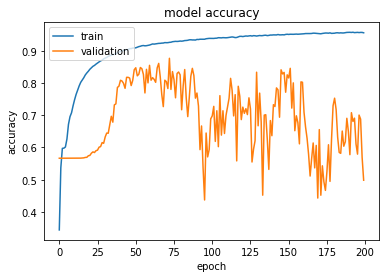

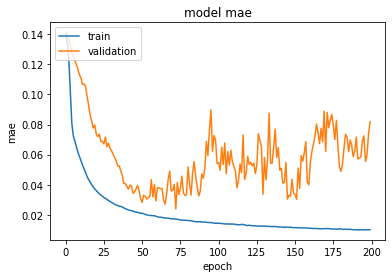

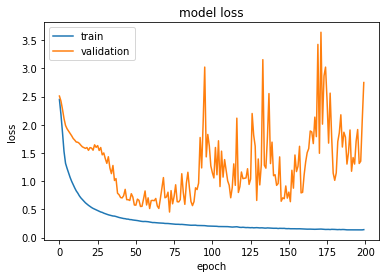

63/63 [==============================] - 2s 31ms/step - loss: 2.8903 - mae: 0.0842 - accuracy: 0.4806

Evaluation:
Loss, MAE, Accuracy [2.8903117179870605, 0.08417723327875137, 0.480559378862381]
PSDS (0.0392319630774077, 'Valid file')

Filling post processing used.
PSDS (0.3637625947866534, 'Valid file')


/home/alex/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/alex/.local/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Submission file saved at ./challenge_submission.csv




Test Split: (6000, 8000)
Pipeline parameter: {'data_folder': './../data/', 'wav_files_folder': 'final_pre_dataset', 'window_length': 1024, 'window_overlap': 523, 'band_size': 4, 'sample_rate': 16000, 'dev_csv': 'dev-labels.csv', 'eval_csv': 'challenge_filelist_dummy.csv', 'scaling': 'standard', 'test_split_range': (6000, 8000), 'prediction_path': './', 'post_processing': 'fill', 'submission_file_path': './challenge_submission.csv'}
Model parameter: {'channels': [32, 64, 64], 'lessParameter': True, 'kernel_size': 3, 'first_kernel_size': 3, 'val_split_fraction': 0.2, 'loss': 'categorical_crossentropy', 'learning_rate': 0.001, 'batch_size': 512, 'epochs': 200, 'model_save_path': './', 'load_path': None}
Csv from wav files already existend. Skipping calc_fft.
Scaled numpy files already existend. Skipping scaling and load_data function.
Splitting test set at indices 6000 to 8000 from dev set.
Existing model.h5 removed.
Tensorflow versi


Epoch 00030: val_loss did not improve from 1.62210
Epoch 31/200
13/13 [==============================] - 20s 2s/step - loss: 0.4471 - mae: 0.0303 - accuracy: 0.8671 - val_loss: 1.5842 - val_mae: 0.0729 - val_accuracy: 0.5850

Epoch 00031: val_loss improved from 1.62210 to 1.58419, saving model to model.h5
Epoch 32/200
13/13 [==============================] - 19s 2s/step - loss: 0.4383 - mae: 0.0299 - accuracy: 0.8699 - val_loss: 1.5211 - val_mae: 0.0711 - val_accuracy: 0.5893

Epoch 00032: val_loss improved from 1.58419 to 1.52115, saving model to model.h5
Epoch 33/200
13/13 [==============================] - 19s 1s/step - loss: 0.4314 - mae: 0.0293 - accuracy: 0.8711 - val_loss: 1.4359 - val_mae: 0.0674 - val_accuracy: 0.6059

Epoch 00033: val_loss improved from 1.52115 to 1.43587, saving model to model.h5
Epoch 34/200
13/13 [==============================] - 20s 2s/step - loss: 0.4249 - mae: 0.0288 - accuracy: 0.8731 - val_loss: 1.4563 - val_mae: 0.0802 - val_accuracy: 0.6130

Epoch


Epoch 00064: val_loss did not improve from 0.48084
Epoch 65/200
13/13 [==============================] - 20s 2s/step - loss: 0.2757 - mae: 0.0192 - accuracy: 0.9158 - val_loss: 0.8022 - val_mae: 0.0447 - val_accuracy: 0.7731

Epoch 00065: val_loss did not improve from 0.48084
Epoch 66/200
13/13 [==============================] - 20s 2s/step - loss: 0.2686 - mae: 0.0188 - accuracy: 0.9180 - val_loss: 0.7869 - val_mae: 0.0434 - val_accuracy: 0.7721

Epoch 00066: val_loss did not improve from 0.48084
Epoch 67/200
13/13 [==============================] - 19s 2s/step - loss: 0.2723 - mae: 0.0191 - accuracy: 0.9169 - val_loss: 0.6320 - val_mae: 0.0344 - val_accuracy: 0.8228

Epoch 00067: val_loss did not improve from 0.48084
Epoch 68/200
13/13 [==============================] - 19s 1s/step - loss: 0.2663 - mae: 0.0187 - accuracy: 0.9192 - val_loss: 0.6474 - val_mae: 0.0345 - val_accuracy: 0.8218

Epoch 00068: val_loss did not improve from 0.48084
Epoch 69/200
13/13 [========================

13/13 [==============================] - 20s 2s/step - loss: 0.2108 - mae: 0.0151 - accuracy: 0.9349 - val_loss: 0.6692 - val_mae: 0.0356 - val_accuracy: 0.8219

Epoch 00101: val_loss did not improve from 0.48084
Epoch 102/200
13/13 [==============================] - 20s 2s/step - loss: 0.2053 - mae: 0.0148 - accuracy: 0.9366 - val_loss: 0.5746 - val_mae: 0.0296 - val_accuracy: 0.8489

Epoch 00102: val_loss did not improve from 0.48084
Epoch 103/200
13/13 [==============================] - 20s 2s/step - loss: 0.2122 - mae: 0.0151 - accuracy: 0.9338 - val_loss: 0.5503 - val_mae: 0.0289 - val_accuracy: 0.8546

Epoch 00103: val_loss did not improve from 0.48084
Epoch 104/200
13/13 [==============================] - 20s 2s/step - loss: 0.2048 - mae: 0.0146 - accuracy: 0.9361 - val_loss: 0.5961 - val_mae: 0.0294 - val_accuracy: 0.8471

Epoch 00104: val_loss did not improve from 0.48084
Epoch 105/200
13/13 [==============================] - 20s 2s/step - loss: 0.2059 - mae: 0.0148 - accuracy

13/13 [==============================] - 20s 2s/step - loss: 0.1456 - mae: 0.0108 - accuracy: 0.9537 - val_loss: 0.8111 - val_mae: 0.0410 - val_accuracy: 0.7995

Epoch 00173: val_loss did not improve from 0.48084
Epoch 174/200
13/13 [==============================] - 19s 2s/step - loss: 0.1486 - mae: 0.0109 - accuracy: 0.9528 - val_loss: 0.6443 - val_mae: 0.0349 - val_accuracy: 0.8442

Epoch 00174: val_loss did not improve from 0.48084
Epoch 175/200
13/13 [==============================] - 20s 2s/step - loss: 0.1481 - mae: 0.0109 - accuracy: 0.9526 - val_loss: 1.1560 - val_mae: 0.0506 - val_accuracy: 0.7258

Epoch 00175: val_loss did not improve from 0.48084
Epoch 176/200
13/13 [==============================] - 19s 1s/step - loss: 0.1481 - mae: 0.0110 - accuracy: 0.9529 - val_loss: 1.4177 - val_mae: 0.0549 - val_accuracy: 0.6902

Epoch 00176: val_loss did not improve from 0.48084
Epoch 177/200
13/13 [==============================] - 19s 1s/step - loss: 0.1466 - mae: 0.0109 - accuracy

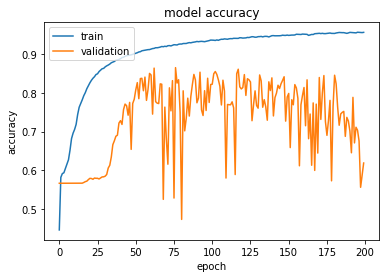

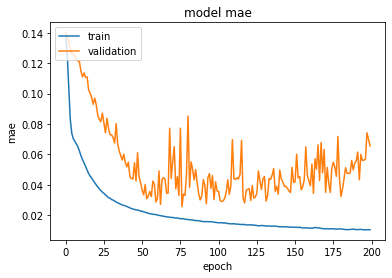

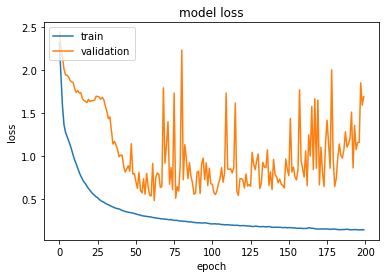

63/63 [==============================] - 2s 24ms/step - loss: 1.7219 - mae: 0.0660 - accuracy: 0.6161 1s - loss: 1

Evaluation:
Loss, MAE, Accuracy [1.7218817472457886, 0.0660228431224823, 0.6160953044891357]
PSDS (0.041077881619937695, 'Valid file')

Filling post processing used.
PSDS (0.3671175185264032, 'Valid file')


/home/alex/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/alex/.local/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Submission file saved at ./challenge_submission.csv




Test Split: (8000, -1)
Pipeline parameter: {'data_folder': './../data/', 'wav_files_folder': 'final_pre_dataset', 'window_length': 1024, 'window_overlap': 523, 'band_size': 4, 'sample_rate': 16000, 'dev_csv': 'dev-labels.csv', 'eval_csv': 'challenge_filelist_dummy.csv', 'scaling': 'standard', 'test_split_range': (8000, -1), 'prediction_path': './', 'post_processing': 'fill', 'submission_file_path': './challenge_submission.csv'}
Model parameter: {'channels': [32, 64, 64], 'lessParameter': True, 'kernel_size': 3, 'first_kernel_size': 3, 'val_split_fraction': 0.2, 'loss': 'categorical_crossentropy', 'learning_rate': 0.001, 'batch_size': 512, 'epochs': 200, 'model_save_path': './', 'load_path': None}
Csv from wav files already existend. Skipping calc_fft.
Scaled numpy files already existend. Skipping scaling and load_data function.
Splitting test set at indices 8000 to -1 from dev set.
Existing model.h5 removed.
Tensorflow version: 2.

16/16 [==============================] - 25s 2s/step - loss: 0.3888 - mae: 0.0264 - accuracy: 0.8844 - val_loss: 1.1286 - val_mae: 0.0543 - val_accuracy: 0.7065

Epoch 00031: val_loss improved from 1.15554 to 1.12855, saving model to model.h5
Epoch 32/200
16/16 [==============================] - 24s 2s/step - loss: 0.3812 - mae: 0.0258 - accuracy: 0.8867 - val_loss: 1.0326 - val_mae: 0.0536 - val_accuracy: 0.7253

Epoch 00032: val_loss improved from 1.12855 to 1.03263, saving model to model.h5
Epoch 33/200
16/16 [==============================] - 24s 2s/step - loss: 0.3774 - mae: 0.0257 - accuracy: 0.8880 - val_loss: 0.8760 - val_mae: 0.0442 - val_accuracy: 0.7625

Epoch 00033: val_loss improved from 1.03263 to 0.87603, saving model to model.h5
Epoch 34/200
16/16 [==============================] - 24s 2s/step - loss: 0.3672 - mae: 0.0250 - accuracy: 0.8904 - val_loss: 0.9772 - val_mae: 0.0555 - val_accuracy: 0.7281

Epoch 00034: val_loss did not improve from 0.87603
Epoch 35/200
16/16 

16/16 [==============================] - 24s 2s/step - loss: 0.2500 - mae: 0.0175 - accuracy: 0.9235 - val_loss: 0.8657 - val_mae: 0.0350 - val_accuracy: 0.8010

Epoch 00066: val_loss did not improve from 0.48067
Epoch 67/200
16/16 [==============================] - 24s 2s/step - loss: 0.2470 - mae: 0.0174 - accuracy: 0.9246 - val_loss: 0.4528 - val_mae: 0.0249 - val_accuracy: 0.8734

Epoch 00067: val_loss improved from 0.48067 to 0.45276, saving model to model.h5
Epoch 68/200
16/16 [==============================] - 24s 2s/step - loss: 0.2411 - mae: 0.0170 - accuracy: 0.9267 - val_loss: 1.3065 - val_mae: 0.0597 - val_accuracy: 0.6584

Epoch 00068: val_loss did not improve from 0.45276
Epoch 69/200
16/16 [==============================] - 24s 2s/step - loss: 0.2403 - mae: 0.0170 - accuracy: 0.9271 - val_loss: 0.4699 - val_mae: 0.0290 - val_accuracy: 0.8650

Epoch 00069: val_loss did not improve from 0.45276
Epoch 70/200
16/16 [==============================] - 25s 2s/step - loss: 0.233

16/16 [==============================] - 24s 2s/step - loss: 0.1594 - mae: 0.0116 - accuracy: 0.9501 - val_loss: 0.7930 - val_mae: 0.0392 - val_accuracy: 0.7969

Epoch 00138: val_loss did not improve from 0.45276
Epoch 139/200
16/16 [==============================] - 25s 2s/step - loss: 0.1567 - mae: 0.0114 - accuracy: 0.9509 - val_loss: 1.3892 - val_mae: 0.0540 - val_accuracy: 0.6896

Epoch 00139: val_loss did not improve from 0.45276
Epoch 140/200
16/16 [==============================] - 25s 2s/step - loss: 0.1595 - mae: 0.0116 - accuracy: 0.9500 - val_loss: 0.8708 - val_mae: 0.0443 - val_accuracy: 0.7631

Epoch 00140: val_loss did not improve from 0.45276
Epoch 141/200
16/16 [==============================] - 24s 2s/step - loss: 0.1558 - mae: 0.0115 - accuracy: 0.9513 - val_loss: 1.0153 - val_mae: 0.0522 - val_accuracy: 0.7172

Epoch 00141: val_loss did not improve from 0.45276
Epoch 142/200
16/16 [==============================] - 24s 2s/step - loss: 0.1568 - mae: 0.0115 - accuracy

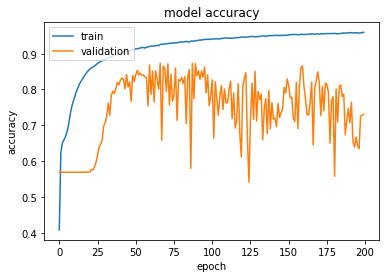

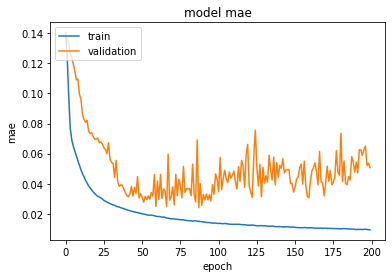

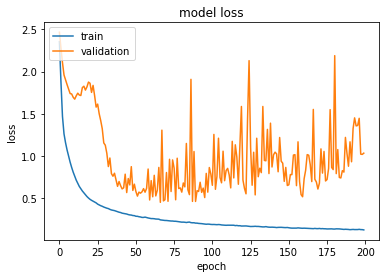

63/63 [==============================] - 2s 24ms/step - loss: 1.0345 - mae: 0.0507 - accuracy: 0.7308 1s - loss: 1

Evaluation:
Loss, MAE, Accuracy [1.0345045328140259, 0.05073675885796547, 0.7308028936386108]
PSDS (0.00016202600969139253, 'Valid file')

Filling post processing used.
PSDS (0.5449937540407332, 'Valid file')


/home/alex/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/alex/.local/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Submission file saved at ./challenge_submission.csv




Cross validation summary:
Loss  [3.04956316947937, 1.6695154905319214, 2.8903117179870605, 1.7218817472457886, 1.0345045328140259]
Mean Loss 2.073155331611633

MAE [0.08816570788621902, 0.05962561070919037, 0.08417723327875137, 0.0660228431224823, 0.05073675885796547]
Mean MAE 0.0697456307709217

Accuracy [0.44536250829696655, 0.6472765803337097, 0.480559378862381, 0.6160953044891357, 0.7308028936386108]
Mean Accuracy 0.5840193331241608

Model PSDS [0.0, 0.012827478376580175, 0.0392319630774077, 0.041077881619937695, 0.00016202600969139253]
Mean model PSDS 0.018659869816723393

Post processed PSDS [0.3176967877355642, 0.4015227221653089, 0.3637625947866534, 0.3671175185264032, 0.5449937540407332]
Mean Post processed PSDS 0.39901867545093256


In [6]:
# crossval scaling standard, channel 32 64 64, 200 epochs
pipe_param = {'data_folder': './../data/',
                  'wav_files_folder': 'final_pre_dataset', # fft parameter
                  'window_length': 1024, 'window_overlap': 523,
                  'band_size': 4, 'sample_rate': 16000,
                  'dev_csv': 'dev-labels.csv', # filelisten, falls man doch auf kleinerem probieren moechte
                  'eval_csv': 'challenge_filelist_dummy.csv',
                  'scaling': 'standard', # 'standard', 'minmax' oder 'no' wenn kein scaling sein soll
                  'test_split_range': (8000, -1), # index anfang und ende aus dev set 
                  'prediction_path': './', # wo prediction csvs gespeichert werden sollen
                  'post_processing': 'fill', # 'fill' is das von Jannes
                  'submission_file_path': './challenge_submission.csv'}
unet_param = {'channels': [32, 64, 64],
              'lessParameter': True,
              'kernel_size': 3,
              'first_kernel_size': 3,
              'val_split_fraction': 0.2, # 1/9 damit man 1000 von den 9000 abzweigt
              'loss': 'categorical_crossentropy', # bbdc.dice_loss moeglich
              'learning_rate': 0.001,
              'batch_size': 512,
              'epochs': 200,
              'model_save_path': './',
              'load_path': None} # Wenn trainiert werden soll: None; Submission 1: 'model9561.h5'
test_index_list = [(0, 2000), (2000, 4000), (4000, 6000), (6000, 8000), (8000,  -1)]
cross_val(pipeline_u_net_1, pipe_param, unet_param, test_index_list)

# Pipeline verbesserung
Score nur 0.13 mit unet 200 epochs, 16, 32, 62 standard scaling obwohl viel mehr erwartet (0.5-0.6)

In [1]:
import os
import sys
sys.path.insert(0, './../')
import bbdc2021 as bbdc

## shuffle

In [2]:
# 200 epochs, 16 32 64, standard scaling
pipe_param = {'data_folder': './../data/',
                  'wav_files_folder': 'final_pre_dataset', # fft parameter
                  'window_length': 1024, 'window_overlap': 523,
                  'band_size': 4, 'sample_rate': 16000,
                  'dev_csv': 'dev-labels.csv', # filelisten, falls man doch auf kleinerem probieren moechte
                  'eval_csv': 'challenge_filelist_dummy.csv',
                  'scaling': 'standard', # 'standard', 'minmax' oder 'no' wenn kein scaling sein soll
                  'test_split_range': (8000, -1), # index anfang und ende aus dev set 
                  'prediction_path': './', # wo prediction csvs gespeichert werden sollen
                  'post_processing': 'fill', # 'fill' is das von Jannes
                  'submission_file_path': './challenge_submission.csv'}
unet_param = {'channels': [16, 32, 64],
              'lessParameter': True,
              'kernel_size': 3,
              'first_kernel_size': 3,
              'val_split_fraction': 0.2, # 1/9 damit man 1000 von den 9000 abzweigt
              'loss': 'categorical_crossentropy', # bbdc.dice_loss moeglich
              'learning_rate': 0.001,
              'batch_size': 512,
              'epochs': 200,
              'model_save_path': './',
              'load_path': None} # Wenn trainiert werden soll: None; Submission 1: 'model9561.h5'

In [2]:
def pipeline_u_net_2(pipe_param, model_param):
    """Current u_net pipeline from loading data to prediction.
    Takes paramater dictionary as argument"""
    print('Pipeline parameter:', pipe_param)
    print('Model parameter:', model_param)
    # load
    x_dev, y_dev, timep, filelist_dev, x_ch, filelist_ch = bbdc.loading_block1(pipe_param)
    # shuffle
    x_dev, y_dev, filelist_dev = bbdc.shuffle_block1(x_dev, y_dev, filelist_dev)
    # split (tv=train and val set)
    x_tv, x_test, y_tv, y_test, filelist_test = bbdc.split_block1(x_dev, y_dev, timep, filelist_dev, pipe_param)
    # model fit (or load)
    history, model = bbdc.model_block1_unet(x_tv, y_tv, unet_param)
    # evaluate
    scores_list, model_psds = bbdc.evaluation_block1(x_test, y_test, timep, filelist_test, model, pipe_param)
    # post processing and its evaluation
    pp_pred_test, pp_pred_ch, pp_psds = bbdc.postprocessing_with_evaluation_block1(x_test, y_test, timep,
                                                                                   filelist_test, x_ch,
                                                                                   filelist_ch, model, pipe_param)
    # challenge prediction
    bbdc.challenge_prediction_block1(pp_pred_ch, timep, filelist_ch, pipe_param)
    return scores_list, model_psds, pp_psds

Pipeline parameter: {'data_folder': './../data/', 'wav_files_folder': 'final_pre_dataset', 'window_length': 1024, 'window_overlap': 523, 'band_size': 4, 'sample_rate': 16000, 'dev_csv': 'dev-labels.csv', 'eval_csv': 'challenge_filelist_dummy.csv', 'scaling': 'standard', 'test_split_range': (8000, -1), 'prediction_path': './', 'post_processing': 'fill', 'submission_file_path': './challenge_submission.csv'}
Model parameter: {'channels': [16, 32, 64], 'lessParameter': True, 'kernel_size': 3, 'first_kernel_size': 3, 'val_split_fraction': 0.2, 'loss': 'categorical_crossentropy', 'learning_rate': 0.001, 'batch_size': 512, 'epochs': 200, 'model_save_path': './', 'load_path': None}
Csv from wav files already existend. Skipping calc_fft.
Scaled numpy files already existend. Skipping scaling and load_data function.
Splitting test set at indices 8000 to -1 from dev set.
Existing model.h5 removed.
Tensorflow version: 2.4.1
Epoch 1/200
16/16 [==============================] - 32s 1s/step - loss: 2.

16/16 [==============================] - 21s 1s/step - loss: 0.6353 - mae: 0.0409 - accuracy: 0.8153 - val_loss: 1.8336 - val_mae: 0.0877 - val_accuracy: 0.5010

Epoch 00030: val_loss did not improve from 1.19850
Epoch 31/200
16/16 [==============================] - 19s 1s/step - loss: 0.6211 - mae: 0.0401 - accuracy: 0.8196 - val_loss: 1.5560 - val_mae: 0.0852 - val_accuracy: 0.5429

Epoch 00031: val_loss did not improve from 1.19850
Epoch 32/200
16/16 [==============================] - 22s 1s/step - loss: 0.6207 - mae: 0.0400 - accuracy: 0.8193 - val_loss: 2.3095 - val_mae: 0.1105 - val_accuracy: 0.3506

Epoch 00032: val_loss did not improve from 1.19850
Epoch 33/200
16/16 [==============================] - 19s 1s/step - loss: 0.6100 - mae: 0.0395 - accuracy: 0.8228 - val_loss: 2.4246 - val_mae: 0.1105 - val_accuracy: 0.3424

Epoch 00033: val_loss did not improve from 1.19850
Epoch 34/200
16/16 [==============================] - 19s 1s/step - loss: 0.5976 - mae: 0.0385 - accuracy: 0.


Epoch 00065: val_loss did not improve from 0.63782
Epoch 66/200
16/16 [==============================] - 18s 1s/step - loss: 0.4510 - mae: 0.0300 - accuracy: 0.8677 - val_loss: 1.0908 - val_mae: 0.0565 - val_accuracy: 0.7074

Epoch 00066: val_loss did not improve from 0.63782
Epoch 67/200
16/16 [==============================] - 18s 1s/step - loss: 0.4527 - mae: 0.0300 - accuracy: 0.8673 - val_loss: 0.7427 - val_mae: 0.0450 - val_accuracy: 0.7872

Epoch 00067: val_loss did not improve from 0.63782
Epoch 68/200
16/16 [==============================] - 18s 1s/step - loss: 0.4488 - mae: 0.0297 - accuracy: 0.8675 - val_loss: 1.0437 - val_mae: 0.0586 - val_accuracy: 0.6896

Epoch 00068: val_loss did not improve from 0.63782
Epoch 69/200
16/16 [==============================] - 18s 1s/step - loss: 0.4445 - mae: 0.0295 - accuracy: 0.8701 - val_loss: 0.7562 - val_mae: 0.0446 - val_accuracy: 0.7903

Epoch 00069: val_loss did not improve from 0.63782
Epoch 70/200
16/16 [========================


Epoch 00101: val_loss did not improve from 0.55289
Epoch 102/200
16/16 [==============================] - 20s 1s/step - loss: 0.3854 - mae: 0.0259 - accuracy: 0.8854 - val_loss: 0.6176 - val_mae: 0.0353 - val_accuracy: 0.8286

Epoch 00102: val_loss did not improve from 0.55289
Epoch 103/200
16/16 [==============================] - 20s 1s/step - loss: 0.3777 - mae: 0.0256 - accuracy: 0.8875 - val_loss: 0.6494 - val_mae: 0.0359 - val_accuracy: 0.8157

Epoch 00103: val_loss did not improve from 0.55289
Epoch 104/200
16/16 [==============================] - 19s 1s/step - loss: 0.3783 - mae: 0.0254 - accuracy: 0.8873 - val_loss: 0.5992 - val_mae: 0.0315 - val_accuracy: 0.8354

Epoch 00104: val_loss did not improve from 0.55289
Epoch 105/200
16/16 [==============================] - 18s 1s/step - loss: 0.3775 - mae: 0.0254 - accuracy: 0.8871 - val_loss: 0.8193 - val_mae: 0.0471 - val_accuracy: 0.7654

Epoch 00105: val_loss did not improve from 0.55289
Epoch 106/200
16/16 [===================


Epoch 00137: val_loss did not improve from 0.49675
Epoch 138/200
16/16 [==============================] - 22s 1s/step - loss: 0.3451 - mae: 0.0236 - accuracy: 0.8961 - val_loss: 0.5388 - val_mae: 0.0316 - val_accuracy: 0.8482

Epoch 00138: val_loss did not improve from 0.49675
Epoch 139/200
16/16 [==============================] - 20s 1s/step - loss: 0.3394 - mae: 0.0231 - accuracy: 0.8982 - val_loss: 0.5679 - val_mae: 0.0354 - val_accuracy: 0.8379

Epoch 00139: val_loss did not improve from 0.49675
Epoch 140/200
16/16 [==============================] - 21s 1s/step - loss: 0.3406 - mae: 0.0230 - accuracy: 0.8981 - val_loss: 0.6362 - val_mae: 0.0420 - val_accuracy: 0.8130

Epoch 00140: val_loss did not improve from 0.49675
Epoch 141/200
16/16 [==============================] - 24s 1s/step - loss: 0.3400 - mae: 0.0232 - accuracy: 0.8981 - val_loss: 0.5939 - val_mae: 0.0327 - val_accuracy: 0.8394

Epoch 00141: val_loss did not improve from 0.49675
Epoch 142/200
16/16 [===================

16/16 [==============================] - 23s 1s/step - loss: 0.3200 - mae: 0.0219 - accuracy: 0.9038 - val_loss: 3.2486 - val_mae: 0.0940 - val_accuracy: 0.4129

Epoch 00174: val_loss did not improve from 0.49675
Epoch 175/200
16/16 [==============================] - 24s 2s/step - loss: 0.3133 - mae: 0.0215 - accuracy: 0.9052 - val_loss: 2.9185 - val_mae: 0.0921 - val_accuracy: 0.4306

Epoch 00175: val_loss did not improve from 0.49675
Epoch 176/200
16/16 [==============================] - 23s 1s/step - loss: 0.3174 - mae: 0.0218 - accuracy: 0.9046 - val_loss: 0.8399 - val_mae: 0.0497 - val_accuracy: 0.7639

Epoch 00176: val_loss did not improve from 0.49675
Epoch 177/200
16/16 [==============================] - 23s 1s/step - loss: 0.3094 - mae: 0.0215 - accuracy: 0.9066 - val_loss: 0.8051 - val_mae: 0.0472 - val_accuracy: 0.7687

Epoch 00177: val_loss did not improve from 0.49675
Epoch 178/200
16/16 [==============================] - 24s 1s/step - loss: 0.3124 - mae: 0.0216 - accuracy

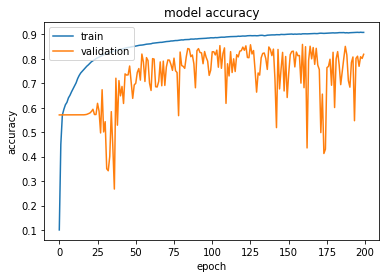

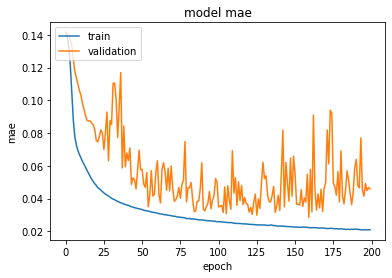

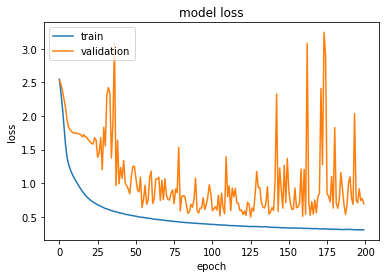

63/63 [==============================] - 1s 23ms/step - loss: 0.6939 - mae: 0.0459 - accuracy: 0.8183

Evaluation:
Loss, MAE, Accuracy [0.6939282417297363, 0.045860644429922104, 0.8183294534683228]
PSDS (0.05718833436950508, 'Valid file')

Filling post processing used.
PSDS (0.5827202175161174, 'Valid file')


/home/alex/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/alex/.local/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Submission file saved at ./challenge_submission.csv


([0.6939282417297363, 0.045860644429922104, 0.8183294534683228],
 0.05718833436950508,
 0.5827202175161174)

In [4]:
pipeline_u_net_2(pipe_param, unet_param)

## mel filter und confusion matrix

In [2]:
# mel filter 
pipe_param = {'data_folder': './../data/',
                  'wav_files_folder': 'final_pre_dataset', # mel parameter
                  'frame_size': 0.04, 'frame_stride': 0.02495,
                  'mel_filter': 32, 'nfft': 512,
                  'dev_csv': 'dev-labels.csv', # filelisten, falls man doch auf kleinerem probieren moechte
                  'eval_csv': 'challenge_filelist_dummy.csv',
                  'scaling': 'standard', # 'standard', 'minmax' oder 'no' wenn kein scaling sein soll
                  'test_split_range': (8000, -1), # index anfang und ende aus dev set 
                  'prediction_path': './', # wo prediction csvs gespeichert werden sollen
                  'post_processing': 'fill', # 'fill' is das von Jannes
                  'submission_file_path': './challenge_submission.csv'}
unet_param = {'channels': [16, 32, 64],
              'lessParameter': True,
              'kernel_size': 3,
              'first_kernel_size': 3,
              'val_split_fraction': 0.2, # 1/9 damit man 1000 von den 9000 abzweigt
              'loss': 'categorical_crossentropy', # bbdc.dice_loss moeglich
              'learning_rate': 0.001,
              'batch_size': 512,
              'epochs': 5,
              'model_save_path': './',
              'load_path': None} # Wenn trainiert werden soll: None; Submission 1: 'model9561.h5'

In [3]:
# mel filter loading_block2
def pipeline_u_net_3(pipe_param, model_param):
    """Current u_net pipeline from loading data to prediction.
    Takes paramater dictionary as argument"""
    print('Pipeline parameter:', pipe_param)
    print('Model parameter:', model_param)
    # load
    x_dev, y_dev, timep, filelist_dev, x_ch, filelist_ch = bbdc.loading_block2(pipe_param)
    # shuffle
    x_dev, y_dev, filelist_dev = bbdc.shuffle_block1(x_dev, y_dev, filelist_dev)
    # split (tv=train and val set)
    x_tv, x_test, y_tv, y_test, filelist_test = bbdc.split_block1(x_dev, y_dev, timep, filelist_dev, pipe_param)
    # model fit (or load)
    history, model = bbdc.model_block1_unet(x_tv, y_tv, model_param)
    # evaluate
    scores_list, model_psds = bbdc.evaluation_block1(x_test, y_test, timep, filelist_test, model, pipe_param)
    # post processing and its evaluation
    pp_pred_test, pp_pred_ch, pp_psds = bbdc.postprocessing_with_evaluation_block1(x_test, y_test, timep,
                                                                                   filelist_test, x_ch,
                                                                                   filelist_ch, model, pipe_param)
    # challenge prediction
    bbdc.challenge_prediction_block1(pp_pred_ch, timep, filelist_ch, pipe_param)
    return scores_list, model_psds, pp_psds

2it [00:00, 16.05it/s]

Pipeline parameter: {'data_folder': './../data/', 'wav_files_folder': 'final_pre_dataset', 'frame_size': 0.04, 'frame_stride': 0.02495, 'mel_filter': 32, 'nfft': 512, 'dev_csv': 'dev-labels.csv', 'eval_csv': 'challenge_filelist_dummy.csv', 'scaling': 'standard', 'test_split_range': (8000, -1), 'prediction_path': './', 'post_processing': 'fill', 'submission_file_path': './challenge_submission.csv'}
Model parameter: {'channels': [16, 32, 64], 'lessParameter': True, 'kernel_size': 3, 'first_kernel_size': 3, 'val_split_fraction': 0.2, 'loss': 'categorical_crossentropy', 'learning_rate': 0.001, 'batch_size': 512, 'epochs': 5, 'model_save_path': './', 'load_path': None}
Mel filter version loading block.
Starting transformation from wav files to csv files (mel).
Processing dev files:


10000it [11:32, 14.44it/s]
2it [00:00, 13.38it/s]

Processing eval files:


3000it [03:29, 14.29it/s]
0it [00:00, ?it/s]

Loading dev set:


30044it [02:35, 192.91it/s]
8it [00:00, 70.90it/s]

Loading eval set:


3000it [00:45, 66.57it/s]


Scaling files.
Saving to numpy arrays.
Splitting test set at indices 8000 to -1 from dev set.
Existing model.h5 removed.
Tensorflow version: 2.4.1
Epoch 1/5
16/16 [==============================] - 38s 2s/step - loss: 2.5625 - mae: 0.1417 - accuracy: 0.0604 - val_loss: 2.5203 - val_mae: 0.1415 - val_accuracy: 0.5715

Epoch 00001: val_loss improved from inf to 2.52026, saving model to model.h5
Epoch 2/5
16/16 [==============================] - 19s 1s/step - loss: 2.3726 - mae: 0.1390 - accuracy: 0.4665 - val_loss: 2.4615 - val_mae: 0.1407 - val_accuracy: 0.5710

Epoch 00002: val_loss improved from 2.52026 to 2.46150, saving model to model.h5
Epoch 3/5
16/16 [==============================] - 17s 1s/step - loss: 2.1320 - mae: 0.1336 - accuracy: 0.5688 - val_loss: 2.3685 - val_mae: 0.1392 - val_accuracy: 0.5710

Epoch 00003: val_loss improved from 2.46150 to 2.36846, saving model to model.h5
Epoch 4/5
16/16 [==============================] - 17s 1s/step - loss: 1.8361 - mae: 0.1228 - accu

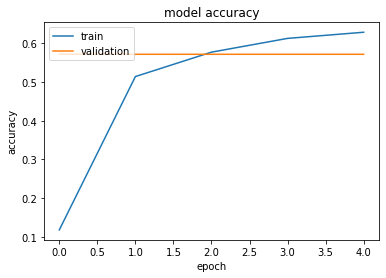

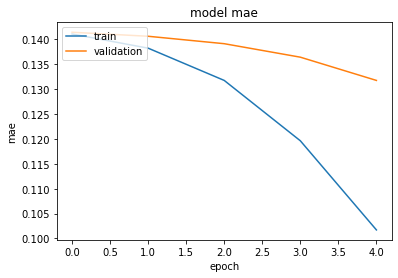

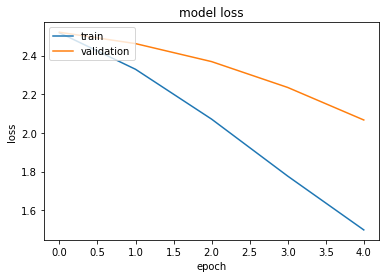

63/63 [==============================] - 1s 20ms/step - loss: 2.0667 - mae: 0.1318 - accuracy: 0.5710

Evaluation:
Loss, MAE, Accuracy [2.0667123794555664, 0.13177385926246643, 0.5710304975509644]
[[456596      0      0      0      0      0      0      0      0      0
       0      0      0]
 [ 30575      0      0      0      0      0      0      0      0      0
       0      0      0]
 [ 29335      0      0      0      0      0      0      0      0      0
       0      0      0]
 [ 28875      0      0      0      0      0      0      0      0      0
       0      0      0]
 [ 29382      0      0      0      0      0      0      0      0      0
       0      0      0]
 [ 28270      0      0      0      0      0      0      0      0      0
       0      0      0]
 [ 28176      0      0      0      0      0      0      0      0      0
       0      0      0]
 [ 28783      0      0      0      0      0      0      0      0      0
       0      0      0]
 [ 28531      0      0      0      

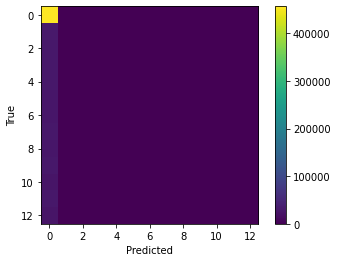

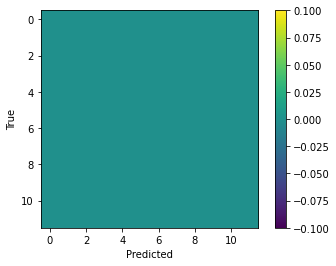

PSDS (nan, "Each file needs to have at least one label. 1999 file(s) missing, e.g. ['04458_mix.wav', '06746_mix.wav', '04439_mix.wav']")

Filling post processing used.
[[456596      0      0      0      0      0      0      0      0      0
       0      0      0]
 [ 30575      0      0      0      0      0      0      0      0      0
       0      0      0]
 [ 29335      0      0      0      0      0      0      0      0      0
       0      0      0]
 [ 28875      0      0      0      0      0      0      0      0      0
       0      0      0]
 [ 29382      0      0      0      0      0      0      0      0      0
       0      0      0]
 [ 28270      0      0      0      0      0      0      0      0      0
       0      0      0]
 [ 28176      0      0      0      0      0      0      0      0      0
       0      0      0]
 [ 28783      0      0      0      0      0      0      0      0      0
       0      0      0]
 [ 28531      0      0      0      0      0      0      0      0

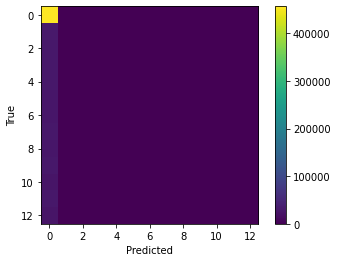

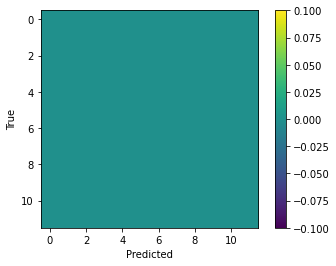

PSDS (nan, "Each file needs to have at least one label. 1999 file(s) missing, e.g. ['04458_mix.wav', '06746_mix.wav', '04439_mix.wav']")
Submission file saved at ./challenge_submission.csv


([2.0667123794555664, 0.13177385926246643, 0.5710304975509644], nan, nan)

In [4]:
pipeline_u_net_3(pipe_param, unet_param)

## val split option

In [2]:
pipe_param = {'data_folder': './../data/',
                  'wav_files_folder': 'final_pre_dataset', # mel parameter
                  'frame_size': 0.04, 'frame_stride': 0.02495,
                  'mel_filter': 32, 'nfft': 512,
                  'dev_csv': 'dev-labels.csv', # filelisten, falls man doch auf kleinerem probieren moechte
                  'eval_csv': 'challenge_filelist_dummy.csv',
                  'scaling': 'standard', # 'standard', 'minmax' oder 'no' wenn kein scaling sein soll
                  'test_split_range': (8000, -1), # index anfang und ende aus dev set 
                  'prediction_path': './', # wo prediction csvs gespeichert werden sollen
                  'post_processing': 'fill', # 'fill' is das von Jannes
                  'submission_file_path': './challenge_submission.csv'}
unet_param = {'channels': [16, 32, 64],
              'lessParameter': True,
              'kernel_size': 3,
              'first_kernel_size': 3,
              'val_split_range': (6400, -1), # 0.2
              'loss': 'categorical_crossentropy', # bbdc.dice_loss moeglich
              'learning_rate': 0.001,
              'batch_size': 512,
              'epochs': 5,
              'model_save_path': './',
              'load_path': None} # Wenn trainiert werden soll: None; Submission 1: 'model9561.h5'

In [3]:
def pipeline_u_net_4(pipe_param, model_param):
    """Current u_net pipeline from loading data to prediction.
    Takes paramater dictionary as argument"""
    print('Pipeline parameter:', pipe_param)
    print('Model parameter:', model_param)
    # load
    x_dev, y_dev, timep, filelist_dev, x_ch, filelist_ch = bbdc.loading_block2(pipe_param)
    # shuffle
    x_dev, y_dev, filelist_dev = bbdc.shuffle_block1(x_dev, y_dev, filelist_dev)
    # split (tv=train and val set)
    x_tv, x_test, y_tv, y_test, filelist_test = bbdc.split_block1(x_dev, y_dev, timep, filelist_dev, pipe_param)
    # model fit (or load)
    history, model = bbdc.model_block2_unet(x_tv, y_tv, model_param)
    # evaluate
    scores_list, model_psds = bbdc.evaluation_block1(x_test, y_test, timep, filelist_test, model, pipe_param)
    # post processing and its evaluation
    pp_pred_test, pp_pred_ch, pp_psds = bbdc.postprocessing_with_evaluation_block1(x_test, y_test, timep,
                                                                                   filelist_test, x_ch,
                                                                                   filelist_ch, model, pipe_param)
    # challenge prediction
    bbdc.challenge_prediction_block1(pp_pred_ch, timep, filelist_ch, pipe_param)
    return scores_list, model_psds, pp_psds

Pipeline parameter: {'data_folder': './../data/', 'wav_files_folder': 'final_pre_dataset', 'frame_size': 0.04, 'frame_stride': 0.02495, 'mel_filter': 32, 'nfft': 512, 'dev_csv': 'dev-labels.csv', 'eval_csv': 'challenge_filelist_dummy.csv', 'scaling': 'standard', 'test_split_range': (8000, -1), 'prediction_path': './', 'post_processing': 'fill', 'submission_file_path': './challenge_submission.csv'}
Model parameter: {'channels': [16, 32, 64], 'lessParameter': True, 'kernel_size': 3, 'first_kernel_size': 3, 'val_split_range': (6400, -1), 'loss': 'categorical_crossentropy', 'learning_rate': 0.001, 'batch_size': 512, 'epochs': 5, 'model_save_path': './', 'load_path': None}
Mel filter version loading block.
Csv from wav files already existend. Skipping calc_fft_mel.
Scaled numpy files already existend. Skipping scaling and load_data function.
Splitting test set at indices 8000 to -1 from dev set.
Tensorflow version: 2.4.1
Splitting val set at indices 6400 to -1 from train set.
Epoch 1/5
20/2

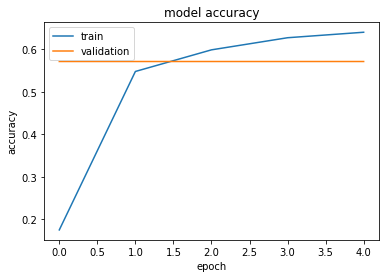

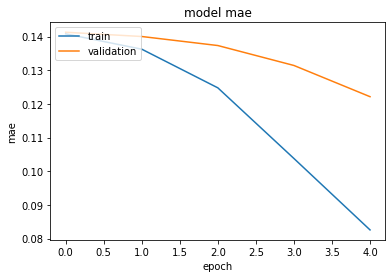

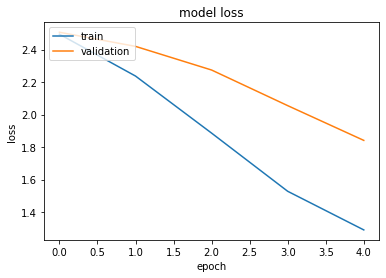

63/63 [==============================] - 1s 22ms/step - loss: 1.8419 - mae: 0.1222 - accuracy: 0.5710

Evaluation:
Loss, MAE, Accuracy [1.841925024986267, 0.12216178327798843, 0.5710304975509644]
[[456596      0      0      0      0      0      0      0      0      0
       0      0      0]
 [ 30575      0      0      0      0      0      0      0      0      0
       0      0      0]
 [ 29335      0      0      0      0      0      0      0      0      0
       0      0      0]
 [ 28875      0      0      0      0      0      0      0      0      0
       0      0      0]
 [ 29382      0      0      0      0      0      0      0      0      0
       0      0      0]
 [ 28270      0      0      0      0      0      0      0      0      0
       0      0      0]
 [ 28176      0      0      0      0      0      0      0      0      0
       0      0      0]
 [ 28783      0      0      0      0      0      0      0      0      0
       0      0      0]
 [ 28531      0      0      0      0

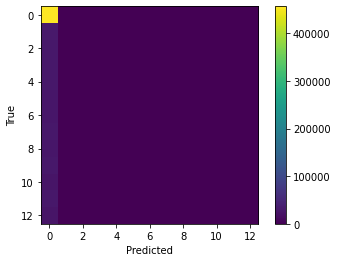

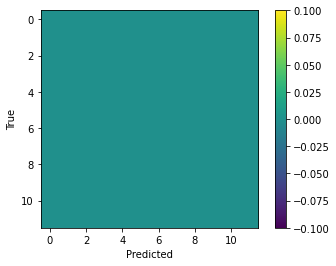

PSDS (nan, "Each file needs to have at least one label. 1999 file(s) missing, e.g. ['08397_mix.wav', '00376_mix.wav', '03125_mix.wav']")

Filling post processing used.
[[456596      0      0      0      0      0      0      0      0      0
       0      0      0]
 [ 30575      0      0      0      0      0      0      0      0      0
       0      0      0]
 [ 29335      0      0      0      0      0      0      0      0      0
       0      0      0]
 [ 28875      0      0      0      0      0      0      0      0      0
       0      0      0]
 [ 29382      0      0      0      0      0      0      0      0      0
       0      0      0]
 [ 28270      0      0      0      0      0      0      0      0      0
       0      0      0]
 [ 28176      0      0      0      0      0      0      0      0      0
       0      0      0]
 [ 28783      0      0      0      0      0      0      0      0      0
       0      0      0]
 [ 28531      0      0      0      0      0      0      0      0

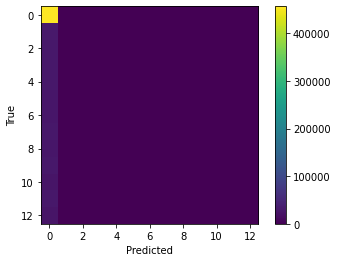

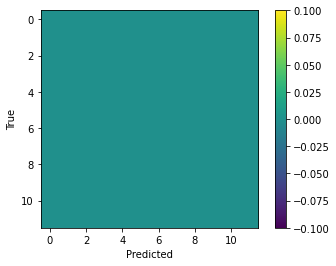

PSDS (nan, "Each file needs to have at least one label. 1999 file(s) missing, e.g. ['08397_mix.wav', '00376_mix.wav', '03125_mix.wav']")
Submission file saved at ./challenge_submission.csv


([1.841925024986267, 0.12216178327798843, 0.5710304975509644], nan, nan)

In [5]:
pipeline_u_net_4(pipe_param, unet_param)

In [8]:
def crossval_u_net_4(pipe_param, model_param, val_split_ranges):
    """Current u_net pipeline from loading data to prediction.
    Takes paramater dictionary as argument"""
    print('Pipeline parameter:', pipe_param)
    print('Model parameter:', model_param)
    # load
    x_dev, y_dev, timep, filelist_dev, x_ch, filelist_ch = bbdc.loading_block2(pipe_param)
    # shuffle
    x_dev, y_dev, filelist_dev = bbdc.shuffle_block1(x_dev, y_dev, filelist_dev)
    # split (tv=train and val set)
    x_tv, x_test, y_tv, y_test, filelist_test = bbdc.split_block1(x_dev, y_dev, timep, filelist_dev, pipe_param)
    all_scores_list = []
    all_model_psds = []
    all_pp_psds = []
    for cross_range in val_split_ranges:
        model_param['val_split_range'] = cross_range
        # model fit (or load)
        history, model = bbdc.model_block2_unet(x_tv, y_tv, model_param)
        # evaluate
        scores_list, model_psds = bbdc.evaluation_block1(x_test, y_test, timep, filelist_test, model, pipe_param)
        # post processing and its evaluation
        pp_pred_test, pp_pred_ch, pp_psds = bbdc.postprocessing_with_evaluation_block1(x_test, y_test, timep,
                                                                                       filelist_test, x_ch,
                                                                                       filelist_ch, model, pipe_param)
        # challenge prediction
        bbdc.challenge_prediction_block1(pp_pred_ch, timep, filelist_ch, pipe_param)
        all_scores_list.append(scores_list)
        all_model_psds.append(model_psds)
        all_pp_psds.append(pp_psds)
        print('\n\n\n')
    fold = len(val_split_ranges)
    print('Cross validation summary:')
    print('Loss ', [elem[0] for elem in all_scores_list])
    print('Mean Loss', sum([elem[0] for elem in all_scores_list])/fold)
    print('')
    print('MAE', [elem[1] for elem in all_scores_list])
    print('Mean MAE', sum([elem[1] for elem in all_scores_list])/fold)
    print('')
    print('Accuracy', [elem[2] for elem in all_scores_list])
    print('Mean Accuracy', sum([elem[2] for elem in all_scores_list])/fold)
    print('')
    print('Model PSDS', all_model_psds)
    print('Mean model PSDS', sum(all_model_psds)/fold)
    print('')
    print('Post processed PSDS', all_pp_psds)
    print('Mean Post processed PSDS', sum(all_pp_psds)/fold)

Pipeline parameter: {'data_folder': './../data/', 'wav_files_folder': 'final_pre_dataset', 'frame_size': 0.04, 'frame_stride': 0.02495, 'mel_filter': 32, 'nfft': 512, 'dev_csv': 'dev-labels.csv', 'eval_csv': 'challenge_filelist_dummy.csv', 'scaling': 'standard', 'test_split_range': (8000, -1), 'prediction_path': './', 'post_processing': 'fill', 'submission_file_path': './challenge_submission.csv'}
Model parameter: {'channels': [16, 32, 64], 'lessParameter': True, 'kernel_size': 3, 'first_kernel_size': 3, 'val_split_range': (6400, -1), 'loss': 'categorical_crossentropy', 'learning_rate': 0.001, 'batch_size': 512, 'epochs': 5, 'model_save_path': './', 'load_path': None}
Mel filter version loading block.
Csv from wav files already existend. Skipping calc_fft_mel.
Scaled numpy files already existend. Skipping scaling and load_data function.
Splitting test set at indices 8000 to -1 from dev set.
Existing model.h5 removed.
Tensorflow version: 2.4.1
Splitting val set at indices 0 to 1600 from

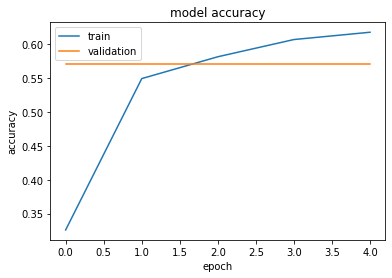

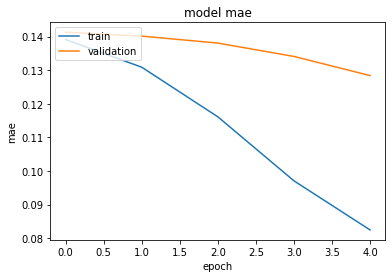

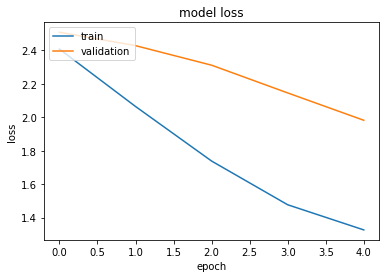

63/63 [==============================] - 1s 22ms/step - loss: 1.9817 - mae: 0.1284 - accuracy: 0.5702

Evaluation:
Loss, MAE, Accuracy [1.9816707372665405, 0.1284000277519226, 0.5701650977134705]
[[455904      0      0      0      0      0      0      0      0      0
       0      0      0]
 [ 26713      0      0      0      0      0      0      0      0      0
       0      0      0]
 [ 28504      0      0      0      0      0      0      0      0      0
       0      0      0]
 [ 28669      0      0      0      0      0      0      0      0      0
       0      0      0]
 [ 30243      0      0      0      0      0      0      0      0      0
       0      0      0]
 [ 32527      0      0      0      0      0      0      0      0      0
       0      0      0]
 [ 28359      0      0      0      0      0      0      0      0      0
       0      0      0]
 [ 30755      0      0      0      0      0      0      0      0      0
       0      0      0]
 [ 24945      0      0      0      0

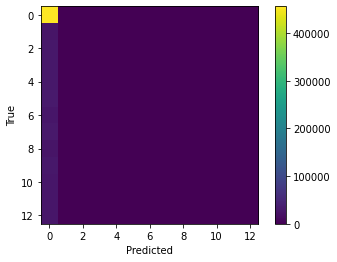

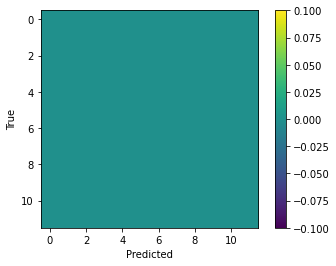

PSDS (nan, "Each file needs to have at least one label. 1999 file(s) missing, e.g. ['00047_mix.wav', '09827_mix.wav', '07096_mix.wav']")

Filling post processing used.
[[455904      0      0      0      0      0      0      0      0      0
       0      0      0]
 [ 26713      0      0      0      0      0      0      0      0      0
       0      0      0]
 [ 28504      0      0      0      0      0      0      0      0      0
       0      0      0]
 [ 28669      0      0      0      0      0      0      0      0      0
       0      0      0]
 [ 30243      0      0      0      0      0      0      0      0      0
       0      0      0]
 [ 32527      0      0      0      0      0      0      0      0      0
       0      0      0]
 [ 28359      0      0      0      0      0      0      0      0      0
       0      0      0]
 [ 30755      0      0      0      0      0      0      0      0      0
       0      0      0]
 [ 24945      0      0      0      0      0      0      0      0

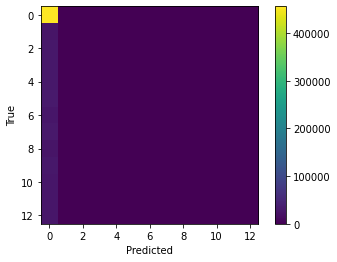

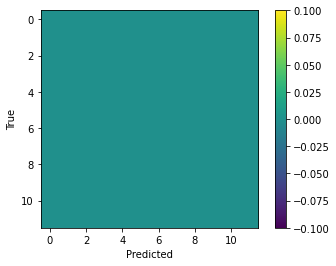

PSDS (nan, "Each file needs to have at least one label. 1999 file(s) missing, e.g. ['00047_mix.wav', '09827_mix.wav', '07096_mix.wav']")
Submission file saved at ./challenge_submission.csv




Existing model.h5 removed.
Tensorflow version: 2.4.1
Splitting val set at indices 1600 to 3200 from train set.
Epoch 1/5
17/17 [==============================] - 29s 1s/step - loss: 2.4487 - mae: 0.1403 - accuracy: 0.1990 - val_loss: 2.5070 - val_mae: 0.1413 - val_accuracy: 0.5693

Epoch 00001: val_loss improved from inf to 2.50705, saving model to model.h5
Epoch 2/5
17/17 [==============================] - 20s 1s/step - loss: 2.1696 - mae: 0.1346 - accuracy: 0.5799 - val_loss: 2.4134 - val_mae: 0.1399 - val_accuracy: 0.5693

Epoch 00002: val_loss improved from 2.50705 to 2.41339, saving model to model.h5
Epoch 3/5
17/17 [==============================] - 20s 1s/step - loss: 1.8243 - mae: 0.1213 - accuracy: 0.5802 - val_loss: 2.2639 - val_mae: 0.1371 - val_accuracy: 0.5693

Epoch 00003: val_loss 

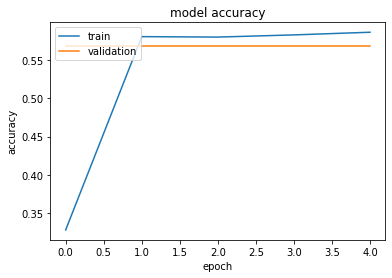

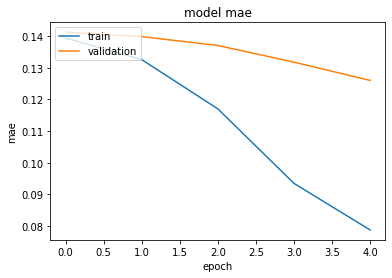

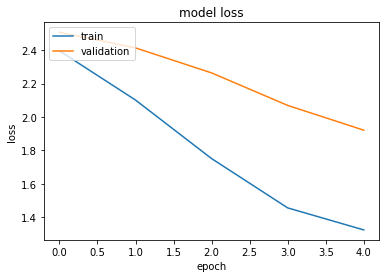

63/63 [==============================] - 1s 22ms/step - loss: 1.9178 - mae: 0.1260 - accuracy: 0.5702

Evaluation:
Loss, MAE, Accuracy [1.9177744388580322, 0.125978484749794, 0.5701650977134705]
[[455904      0      0      0      0      0      0      0      0      0
       0      0      0]
 [ 26713      0      0      0      0      0      0      0      0      0
       0      0      0]
 [ 28504      0      0      0      0      0      0      0      0      0
       0      0      0]
 [ 28669      0      0      0      0      0      0      0      0      0
       0      0      0]
 [ 30243      0      0      0      0      0      0      0      0      0
       0      0      0]
 [ 32527      0      0      0      0      0      0      0      0      0
       0      0      0]
 [ 28359      0      0      0      0      0      0      0      0      0
       0      0      0]
 [ 30755      0      0      0      0      0      0      0      0      0
       0      0      0]
 [ 24945      0      0      0      0 

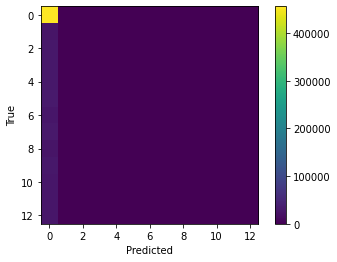

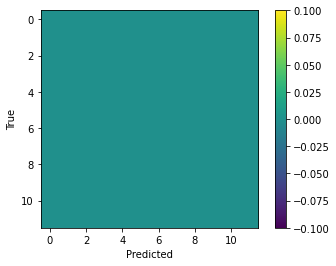

PSDS (nan, "Each file needs to have at least one label. 1999 file(s) missing, e.g. ['00047_mix.wav', '09827_mix.wav', '07096_mix.wav']")

Filling post processing used.
[[455904      0      0      0      0      0      0      0      0      0
       0      0      0]
 [ 26713      0      0      0      0      0      0      0      0      0
       0      0      0]
 [ 28504      0      0      0      0      0      0      0      0      0
       0      0      0]
 [ 28669      0      0      0      0      0      0      0      0      0
       0      0      0]
 [ 30243      0      0      0      0      0      0      0      0      0
       0      0      0]
 [ 32527      0      0      0      0      0      0      0      0      0
       0      0      0]
 [ 28359      0      0      0      0      0      0      0      0      0
       0      0      0]
 [ 30755      0      0      0      0      0      0      0      0      0
       0      0      0]
 [ 24945      0      0      0      0      0      0      0      0

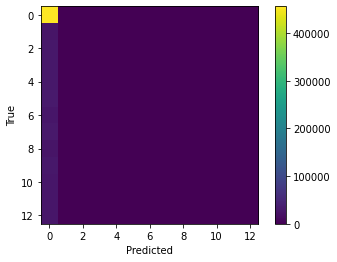

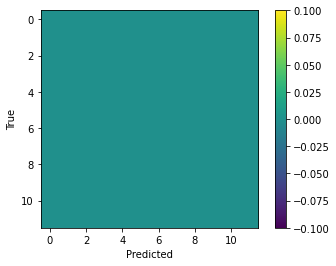

PSDS (nan, "Each file needs to have at least one label. 1999 file(s) missing, e.g. ['00047_mix.wav', '09827_mix.wav', '07096_mix.wav']")
Submission file saved at ./challenge_submission.csv




Existing model.h5 removed.
Tensorflow version: 2.4.1
Splitting val set at indices 3200 to 4800 from train set.
Epoch 1/5
17/17 [==============================] - 31s 1s/step - loss: 2.5305 - mae: 0.1413 - accuracy: 0.1212 - val_loss: 2.5114 - val_mae: 0.1413 - val_accuracy: 0.5761

Epoch 00001: val_loss improved from inf to 2.51144, saving model to model.h5
Epoch 2/5
17/17 [==============================] - 20s 1s/step - loss: 2.2791 - mae: 0.1372 - accuracy: 0.5368 - val_loss: 2.4384 - val_mae: 0.1403 - val_accuracy: 0.5761

Epoch 00002: val_loss improved from 2.51144 to 2.43839, saving model to model.h5
Epoch 3/5
17/17 [==============================] - 23s 1s/step - loss: 1.9514 - mae: 0.1274 - accuracy: 0.5833 - val_loss: 2.3237 - val_mae: 0.1383 - val_accuracy: 0.5761

Epoch 00003: val_loss 

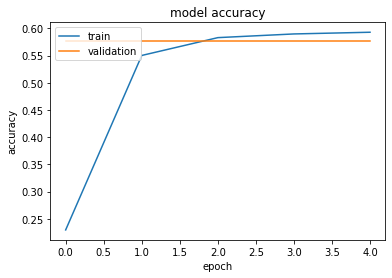

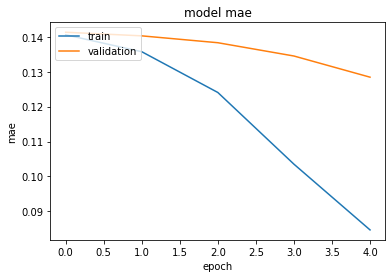

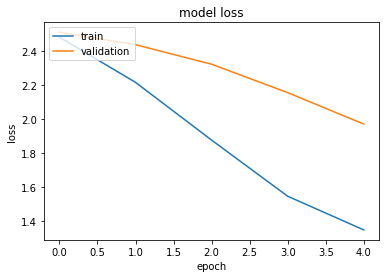

63/63 [==============================] - 1s 23ms/step - loss: 1.9797 - mae: 0.1286 - accuracy: 0.5702

Evaluation:
Loss, MAE, Accuracy [1.9797075986862183, 0.12859860062599182, 0.5701650977134705]
[[455904      0      0      0      0      0      0      0      0      0
       0      0      0]
 [ 26713      0      0      0      0      0      0      0      0      0
       0      0      0]
 [ 28504      0      0      0      0      0      0      0      0      0
       0      0      0]
 [ 28669      0      0      0      0      0      0      0      0      0
       0      0      0]
 [ 30243      0      0      0      0      0      0      0      0      0
       0      0      0]
 [ 32527      0      0      0      0      0      0      0      0      0
       0      0      0]
 [ 28359      0      0      0      0      0      0      0      0      0
       0      0      0]
 [ 30755      0      0      0      0      0      0      0      0      0
       0      0      0]
 [ 24945      0      0      0      

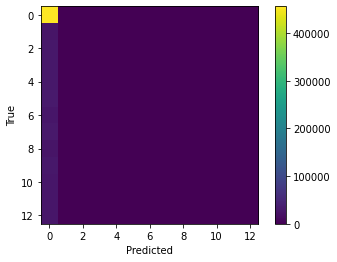

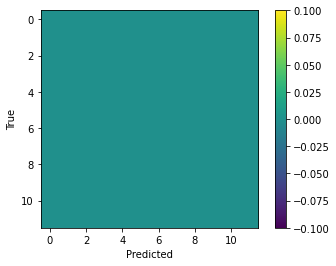

PSDS (nan, "Each file needs to have at least one label. 1999 file(s) missing, e.g. ['00047_mix.wav', '09827_mix.wav', '07096_mix.wav']")

Filling post processing used.
[[455904      0      0      0      0      0      0      0      0      0
       0      0      0]
 [ 26713      0      0      0      0      0      0      0      0      0
       0      0      0]
 [ 28504      0      0      0      0      0      0      0      0      0
       0      0      0]
 [ 28669      0      0      0      0      0      0      0      0      0
       0      0      0]
 [ 30243      0      0      0      0      0      0      0      0      0
       0      0      0]
 [ 32527      0      0      0      0      0      0      0      0      0
       0      0      0]
 [ 28359      0      0      0      0      0      0      0      0      0
       0      0      0]
 [ 30755      0      0      0      0      0      0      0      0      0
       0      0      0]
 [ 24945      0      0      0      0      0      0      0      0

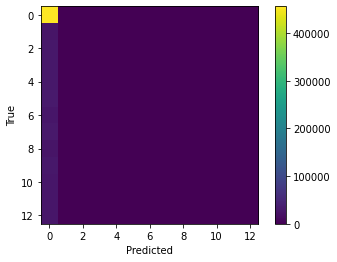

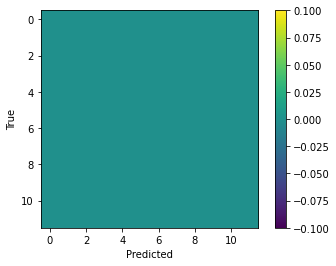

PSDS (nan, "Each file needs to have at least one label. 1999 file(s) missing, e.g. ['00047_mix.wav', '09827_mix.wav', '07096_mix.wav']")
Submission file saved at ./challenge_submission.csv




Existing model.h5 removed.
Tensorflow version: 2.4.1
Splitting val set at indices 4800 to 6400 from train set.
Epoch 1/5
17/17 [==============================] - 30s 1s/step - loss: 2.4158 - mae: 0.1392 - accuracy: 0.2957 - val_loss: 2.4540 - val_mae: 0.1405 - val_accuracy: 0.5728

Epoch 00001: val_loss improved from inf to 2.45397, saving model to model.h5
Epoch 2/5
17/17 [==============================] - 19s 1s/step - loss: 2.0564 - mae: 0.1306 - accuracy: 0.5826 - val_loss: 2.3685 - val_mae: 0.1391 - val_accuracy: 0.5728

Epoch 00002: val_loss improved from 2.45397 to 2.36846, saving model to model.h5
Epoch 3/5
17/17 [==============================] - 19s 1s/step - loss: 1.6908 - mae: 0.1128 - accuracy: 0.5846 - val_loss: 2.2505 - val_mae: 0.1368 - val_accuracy: 0.5728

Epoch 00003: val_loss 

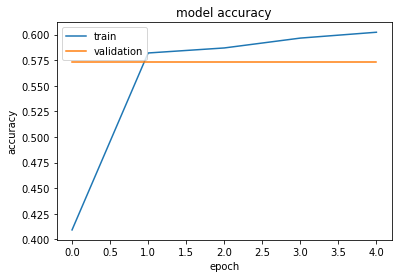

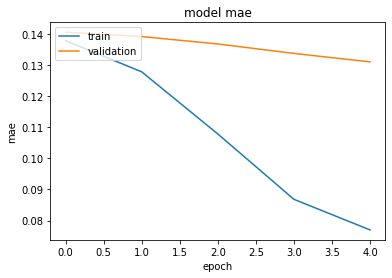

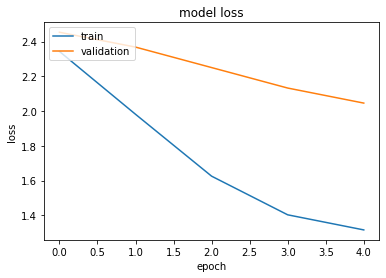

63/63 [==============================] - 1s 19ms/step - loss: 2.0452 - mae: 0.1309 - accuracy: 0.5702

Evaluation:
Loss, MAE, Accuracy [2.0452048778533936, 0.13094355165958405, 0.5701650977134705]
[[455904      0      0      0      0      0      0      0      0      0
       0      0      0]
 [ 26713      0      0      0      0      0      0      0      0      0
       0      0      0]
 [ 28504      0      0      0      0      0      0      0      0      0
       0      0      0]
 [ 28669      0      0      0      0      0      0      0      0      0
       0      0      0]
 [ 30243      0      0      0      0      0      0      0      0      0
       0      0      0]
 [ 32527      0      0      0      0      0      0      0      0      0
       0      0      0]
 [ 28359      0      0      0      0      0      0      0      0      0
       0      0      0]
 [ 30755      0      0      0      0      0      0      0      0      0
       0      0      0]
 [ 24945      0      0      0      

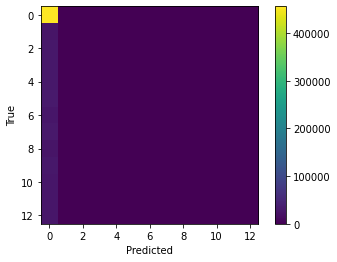

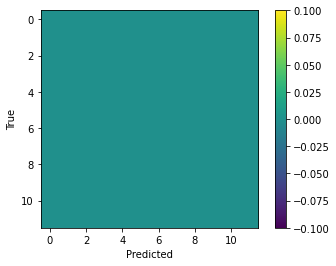

PSDS (nan, "Each file needs to have at least one label. 1999 file(s) missing, e.g. ['00047_mix.wav', '09827_mix.wav', '07096_mix.wav']")

Filling post processing used.
[[455904      0      0      0      0      0      0      0      0      0
       0      0      0]
 [ 26713      0      0      0      0      0      0      0      0      0
       0      0      0]
 [ 28504      0      0      0      0      0      0      0      0      0
       0      0      0]
 [ 28669      0      0      0      0      0      0      0      0      0
       0      0      0]
 [ 30243      0      0      0      0      0      0      0      0      0
       0      0      0]
 [ 32527      0      0      0      0      0      0      0      0      0
       0      0      0]
 [ 28359      0      0      0      0      0      0      0      0      0
       0      0      0]
 [ 30755      0      0      0      0      0      0      0      0      0
       0      0      0]
 [ 24945      0      0      0      0      0      0      0      0

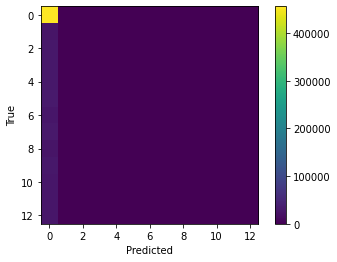

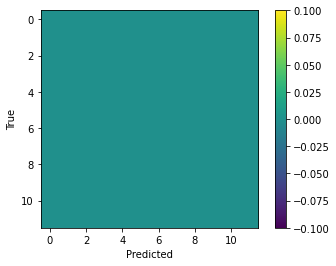

PSDS (nan, "Each file needs to have at least one label. 1999 file(s) missing, e.g. ['00047_mix.wav', '09827_mix.wav', '07096_mix.wav']")
Submission file saved at ./challenge_submission.csv




Existing model.h5 removed.
Tensorflow version: 2.4.1
Splitting val set at indices 6400 to -1 from train set.
Epoch 1/5
20/20 [==============================] - 35s 1s/step - loss: 2.5598 - mae: 0.1416 - accuracy: 0.1455 - val_loss: 2.4932 - val_mae: 0.1411 - val_accuracy: 0.5717

Epoch 00001: val_loss improved from inf to 2.49321, saving model to model.h5
Epoch 2/5
20/20 [==============================] - 24s 1s/step - loss: 2.2556 - mae: 0.1367 - accuracy: 0.5533 - val_loss: 2.3939 - val_mae: 0.1396 - val_accuracy: 0.5717

Epoch 00002: val_loss improved from 2.49321 to 2.39392, saving model to model.h5
Epoch 3/5
20/20 [==============================] - 22s 1s/step - loss: 1.8571 - mae: 0.1237 - accuracy: 0.5937 - val_loss: 2.2501 - val_mae: 0.1368 - val_accuracy: 0.5717

Epoch 00003: val_loss im

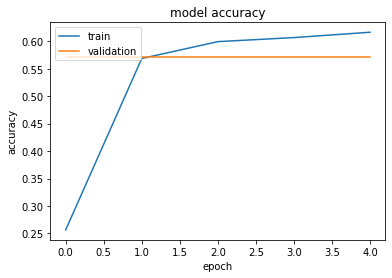

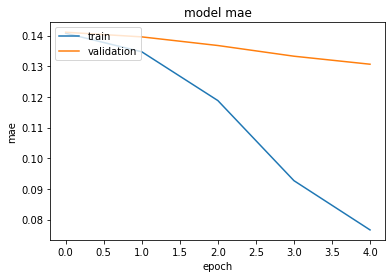

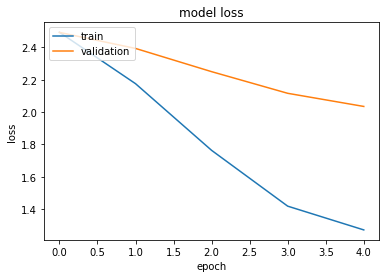

63/63 [==============================] - 1s 18ms/step - loss: 2.0371 - mae: 0.1307 - accuracy: 0.5702

Evaluation:
Loss, MAE, Accuracy [2.0370635986328125, 0.13070860505104065, 0.5701650977134705]
[[455904      0      0      0      0      0      0      0      0      0
       0      0      0]
 [ 26713      0      0      0      0      0      0      0      0      0
       0      0      0]
 [ 28504      0      0      0      0      0      0      0      0      0
       0      0      0]
 [ 28669      0      0      0      0      0      0      0      0      0
       0      0      0]
 [ 30243      0      0      0      0      0      0      0      0      0
       0      0      0]
 [ 32527      0      0      0      0      0      0      0      0      0
       0      0      0]
 [ 28359      0      0      0      0      0      0      0      0      0
       0      0      0]
 [ 30755      0      0      0      0      0      0      0      0      0
       0      0      0]
 [ 24945      0      0      0      

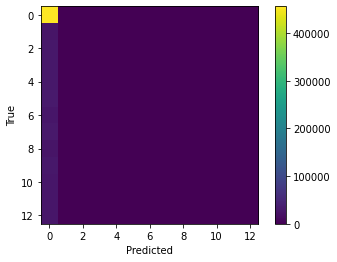

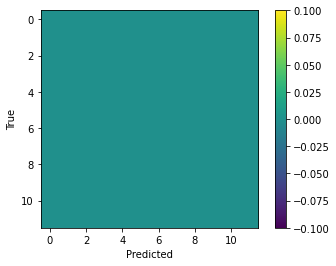

PSDS (nan, "Each file needs to have at least one label. 1999 file(s) missing, e.g. ['00047_mix.wav', '09827_mix.wav', '07096_mix.wav']")

Filling post processing used.
[[455904      0      0      0      0      0      0      0      0      0
       0      0      0]
 [ 26713      0      0      0      0      0      0      0      0      0
       0      0      0]
 [ 28504      0      0      0      0      0      0      0      0      0
       0      0      0]
 [ 28669      0      0      0      0      0      0      0      0      0
       0      0      0]
 [ 30243      0      0      0      0      0      0      0      0      0
       0      0      0]
 [ 32527      0      0      0      0      0      0      0      0      0
       0      0      0]
 [ 28359      0      0      0      0      0      0      0      0      0
       0      0      0]
 [ 30755      0      0      0      0      0      0      0      0      0
       0      0      0]
 [ 24945      0      0      0      0      0      0      0      0

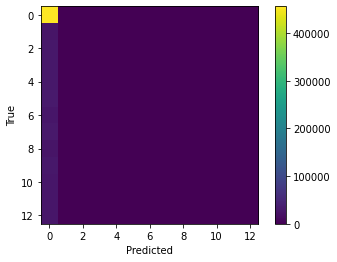

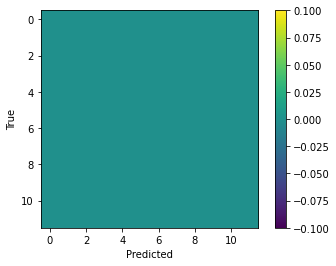

PSDS (nan, "Each file needs to have at least one label. 1999 file(s) missing, e.g. ['00047_mix.wav', '09827_mix.wav', '07096_mix.wav']")
Submission file saved at ./challenge_submission.csv






NameError: name 'test_index_list' is not defined

In [7]:
val_split_ranges = [(0, 1600), (1600, 3200),(3200, 4800), (4800, 6400), (6400, -1)]
crossval_u_net_4(pipe_param, unet_param, val_split_ranges)

# window post processing